In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading, Combining, and Cleaning the dataset

In [13]:
# Load the train/test dataset and dataset of different modes
spotify_train_tabular = pd.read_csv('spotify_data/spotify_train_20k.csv')
spotify_test_tabular = pd.read_csv('spotify_data/spotify_test_20k.csv')

spotify_text_description_manifest = pd.read_csv('text_description_data/text_description_manifest_20k.csv')
spotify_lyrics_manifest = pd.read_csv('lyrics_data/lyrics_manifest_20k_clean.csv')
spotify_audio_manifest = pd.read_csv('audio_data/audio_manifest_20k.csv')
spotify_image_manifest = pd.read_csv('image_data/spotify_album_cover_manifest.csv')


In [11]:
# Sanity Check of track_ids
# Extract track_id sets
desc_ids  = set(spotify_text_description_manifest['track_id'])
lyrics_ids = set(spotify_lyrics_manifest['track_id'])
audio_ids = set(spotify_audio_manifest['track_id'])
image_ids = set(spotify_image_manifest['track_id'])

# Check if all sets are identical
all_manifests_match = (desc_ids == lyrics_ids == audio_ids == image_ids)
print("Do all 4 manifest datasets have identical track_ids? →", all_manifests_match)

train_ids = set(spotify_train_tabular['track_id'])
missing_from_train = train_ids - desc_ids

print("\nAre all TRAIN track_ids in the manifest files? →", len(missing_from_train) == 0)
print("Missing train track_ids:", missing_from_train)

test_ids = set(spotify_test_tabular['track_id'])
missing_from_test = test_ids - desc_ids

print("\nAre all TEST track_ids in the manifest files? →", len(missing_from_test) == 0)
print("Missing test track_ids:", missing_from_test)




Do all 4 manifest datasets have identical track_ids? → True

Are all TRAIN track_ids in the manifest files? → True
Missing train track_ids: set()

Are all TEST track_ids in the manifest files? → True
Missing test track_ids: set()


<Axes: >

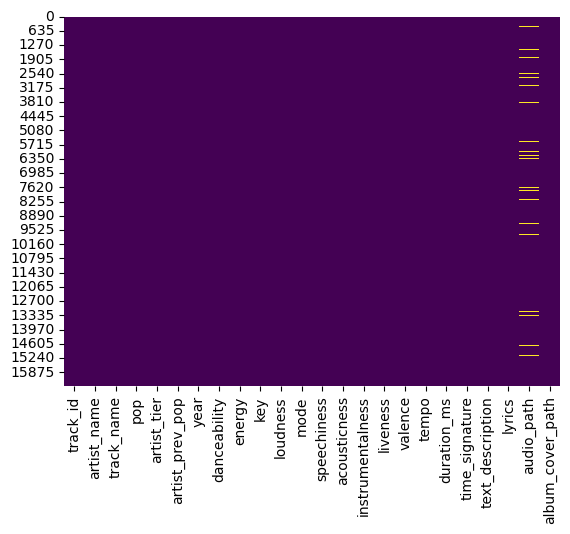

In [26]:
# Merge the other mode datasets on the track_id column to train data
spotify_train_all_modes = pd.merge(spotify_train_tabular, spotify_text_description_manifest[['track_id', 'text_description']], on='track_id', how='left')
spotify_train_all_modes = pd.merge(spotify_train_all_modes, spotify_lyrics_manifest[['track_id', 'lyrics']], on='track_id', how='left')
spotify_train_all_modes = pd.merge(spotify_train_all_modes, spotify_audio_manifest[['track_id', 'audio_path']], on='track_id', how='left')
spotify_train_all_modes = pd.merge(spotify_train_all_modes, spotify_image_manifest[['track_id', 'album_cover_path']], on='track_id', how='left')


# Merge the other mode datasets on the track_id column to test data
spotify_test_all_modes = pd.merge(spotify_test_tabular, spotify_text_description_manifest[['track_id', 'text_description']], on='track_id', how='left')
spotify_test_all_modes = pd.merge(spotify_test_all_modes, spotify_lyrics_manifest[['track_id', 'lyrics']], on='track_id', how='left')
spotify_test_all_modes = pd.merge(spotify_test_all_modes, spotify_audio_manifest[['track_id', 'audio_path']], on='track_id', how='left')
spotify_test_all_modes = pd.merge(spotify_test_all_modes, spotify_image_manifest[['track_id', 'album_cover_path']], on='track_id', how='left')


# plot the missing values
sns.heatmap(spotify_train_all_modes.isnull(), cbar=False, cmap='viridis')
#sns.heatmap(spotify_test_all_modes.isnull(), cbar=False, cmap='viridis')

In [27]:
# filter out rows with missing values in any column
spotify_train_all_modes = spotify_train_all_modes.dropna()
spotify_test_all_modes = spotify_test_all_modes.dropna()


In [32]:
# Save the cleaned datasets
spotify_train_all_modes.to_csv('spotify_data/spotify_train_all_modes.csv', index=False)
spotify_test_all_modes.to_csv('spotify_data/spotify_test_all_modes.csv', index=False)

shape of train data after getting rid of missing values: (15652, 24)
shape of test data after getting rid of missing values: (4706, 24)


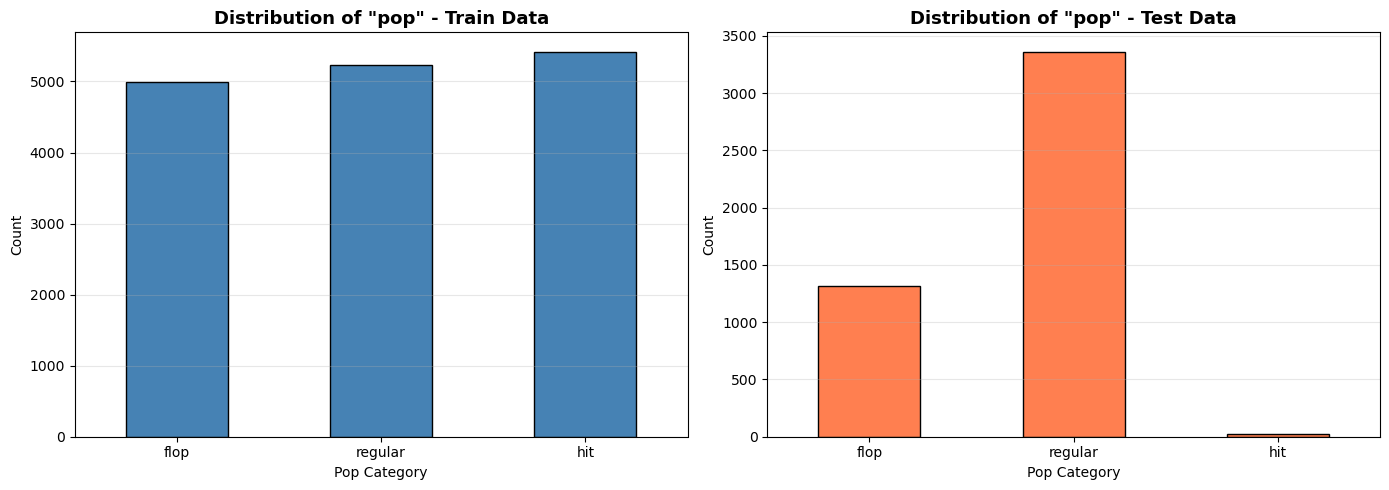

Train 'pop' distribution:
pop
flop       4999
regular    5232
hit        5421
Name: count, dtype: int64

Test 'pop' distribution:
pop
flop       1316
regular    3362
hit          28
Name: count, dtype: int64


In [31]:
# Check the shape of the data after getting rid of missing values
print("shape of train data after getting rid of missing values:", spotify_train_all_modes.shape)
print("shape of test data after getting rid of missing values:", spotify_test_all_modes.shape)

# Plot histogram for 'pop' variable in both datasets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define the order
order = ['flop', 'regular', 'hit']

# Train data
spotify_train_all_modes['pop'].value_counts()[order].plot(kind='bar', ax=axes[0], 
                                                          color='steelblue', edgecolor='black')
axes[0].set_title('Distribution of "pop" - Train Data', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Pop Category')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(order, rotation=0)

# Test data
spotify_test_all_modes['pop'].value_counts()[order].plot(kind='bar', ax=axes[1], 
                                                         color='coral', edgecolor='black')
axes[1].set_title('Distribution of "pop" - Test Data', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Pop Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(order, rotation=0)

plt.tight_layout()
plt.show()

# Print counts
print("Train 'pop' distribution:")
print(spotify_train_all_modes['pop'].value_counts()[order])
print(f"\nTest 'pop' distribution:")
print(spotify_test_all_modes['pop'].value_counts()[order])

##### Training goal 
Note that we are simulating the real life scenario, where hit songs are rare case, so even though accuracy and auc is important for this model, our pripritized metric is the f1 score for hit songs. More specifically, the recall (how many song out of the 28 songs did we capture?)

### Baseline: Tabular Data
The most basic input uses solely the tabular data, and the simple and low dimensional nature of the dataset gives us flexibility to try a wider range of models. which we will try to fit a elastic net, a hyperparameter-tuned random forest, a hyperparameter tuned XGBoost, and a FFNN, and compare the performance on the validation data to select the best model.

In [181]:
# Load the train and test data (all modes)
spotify_train_all_modes = pd.read_csv('spotify_data/spotify_train_all_modes.csv')
spotify_test_all_modes = pd.read_csv('spotify_data/spotify_test_all_modes.csv')


In [182]:
# Extract the tabular data
tabular_columns  = ['track_id', 'artist_name', 'track_name', 'artist_tier', 
                    'artist_prev_pop', 'year', 'danceability', 'energy', 'key', 
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'pop']

train_tabular = spotify_train_all_modes[tabular_columns]
test_tabular = spotify_test_all_modes[tabular_columns]

In [78]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_tabular_processed = pd.get_dummies(train_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_tabular_processed = pd.get_dummies(test_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_tabular_processed = test_tabular_processed[train_tabular_processed.columns]

print(f"Training set shape: {train_tabular_processed.shape}")
print(f"Test set shape: {test_tabular_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_tabular_processed.columns if col not in exclude_cols]

X_train = train_tabular_processed[feature_cols]
y_train = train_tabular_processed['pop']
X_test = test_tabular_processed[feature_cols]
y_test = test_tabular_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 25)
Test set shape: (4706, 25)

Features: 21
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'artist_tier_A', 'artist_tier_B', 'artist_tier_C', 'artist_tier_F', 'artist_tier_S', 'artist_tier_U']

Standardizing Features
✓ Features standardized


#### Elastic Net

In [28]:
from sklearn.metrics import make_scorer, f1_score

### Elastic Net with Hyperparameter Tuning
print("\n" + "="*60)
print("Setting up Elastic Net Model")
print("="*60)

# Define hyperparameter grid
param_grid = {
    'C': [1/10000, 1/1000, 1/100, 1/10, 1, 10, 100],  # C = 1/alpha in sklearn
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Note: sklearn uses C (inverse of alpha), so C = 1/alpha
# Higher C = less regularization, Lower C = more regularization

print(f"Hyperparameter grid:")
print(f"  C (1/alpha): {param_grid['C']}")
print(f"  l1_ratio: {param_grid['l1_ratio']}")
print(f"  Total combinations: {len(param_grid['C']) * len(param_grid['l1_ratio'])}")

# Create Elastic Net model with balanced class weights
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',  # saga supports elasticnet
    class_weight='balanced',  # Handle class imbalance
    max_iter=5000,
    random_state=42,
    multi_class='multinomial'  # For multi-class classification
)

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
}

grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: Accuracy and ROC-AUC (OvR)")
print("  - Class weights: balanced")



Setting up Elastic Net Model
Hyperparameter grid:
  C (1/alpha): [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
  l1_ratio: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  Total combinations: 77

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: Accuracy and ROC-AUC (OvR)
  - Class weights: balanced


In [29]:
# Step 5: Fit the model
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  C (1/alpha): {grid_search.best_params_['C']:.6f}")
print(f"  l1_ratio: {grid_search.best_params_['l1_ratio']:.2f}")
print(f"  (alpha = {1/grid_search.best_params_['C']:.4f})")

# Best cross-validation scores
print(f"\nBest cross-validation scores:")
best_idx = grid_search.best_index_
print(f"  Accuracy: {grid_search.cv_results_['mean_test_accuracy'][best_idx]:.4f} "
      f"(+/- {grid_search.cv_results_['std_test_accuracy'][best_idx]:.4f})")
print(f"  ROC-AUC (OvR): {grid_search.cv_results_['mean_test_roc_auc'][best_idx]:.4f} "
      f"(+/- {grid_search.cv_results_['std_test_roc_auc'][best_idx]:.4f})")

# Test set performance
y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)
y_test_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 77 candidates, totalling 385 fits


KeyboardInterrupt: 

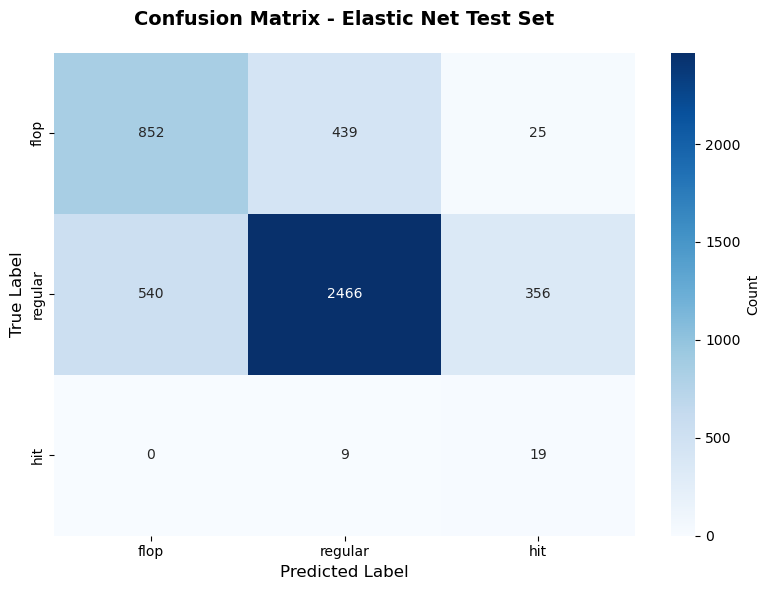

In [ ]:
# Confusion Matrix on Test Set for Elastic Net

from sklearn.metrics import confusion_matrix

# Confusion Matrix on Test Set for Elastic Net
y_test_pred_en = grid_search.predict(X_test_scaled)
cm_test_en = confusion_matrix(y_test, y_test_pred_en, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_en, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Elastic Net Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

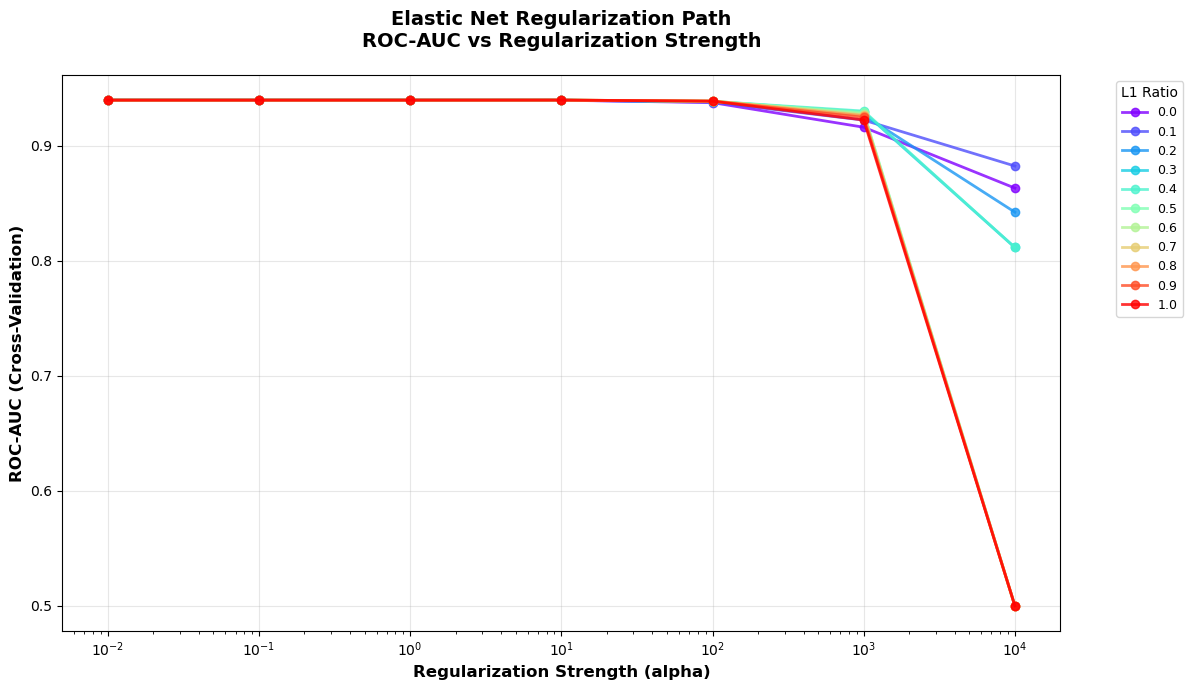

In [ ]:
# Elastic Net Regularization Path
results_df = pd.DataFrame(grid_search.cv_results_)
l1_ratios = sorted(results_df['param_l1_ratio'].unique())
colors = plt.cm.rainbow(np.linspace(0, 1, len(l1_ratios)))

plt.figure(figsize=(12, 7))

for l1_ratio, color in zip(l1_ratios, colors):
    mask = results_df['param_l1_ratio'] == l1_ratio
    data = results_df[mask].sort_values('param_C')
    
    alphas = 1 / data['param_C'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(alphas, roc_aucs, 'o-', color=color, 
            label=f'{l1_ratio:.1f}', linewidth=2, markersize=6, alpha=0.8)

plt.xscale('log')
plt.xlabel('Regularization Strength (alpha)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('Elastic Net Regularization Path\nROC-AUC vs Regularization Strength', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='L1 Ratio', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Save the best model and results for later comparison
elastic_net_model = grid_search.best_estimator_
elastic_net_results = {
    'model_name': 'Elastic Net',
    'best_params': grid_search.best_params_,
    'cv_roc_auc': grid_search.cv_results_['mean_test_roc_auc'][best_idx],
    'cv_roc_auc_std': grid_search.cv_results_['std_test_roc_auc'][best_idx],
    'cv_accuracy': grid_search.cv_results_['mean_test_accuracy'][best_idx],
    'cv_accuracy_std': grid_search.cv_results_['std_test_accuracy'][best_idx],
    'test_roc_auc': test_roc_auc,
    'test_accuracy': test_accuracy,
    'grid_search': grid_search
}

print("✓ Elastic Net model and results saved")
print("\nReady for next model (Random Forest or XGBoost)!")


✓ Elastic Net model and results saved

Ready for next model (Random Forest or XGBoost)!


#### Random forest

In [ ]:
### Random Forest with Hyperparameter Tuning

from sklearn.ensemble import RandomForestClassifier

print("="*60)
print("Random Forest Model Setup")
print("="*60)

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': [2, 3, 4, 5, 8, 10],
    'bootstrap': [True],
    'max_samples': [0.8]
}

print(f"Hyperparameter grid:")
print(f"  n_estimators (# trees): {param_grid_rf['n_estimators']}")
print(f"  min_samples_split (minimal node size): {param_grid_rf['min_samples_split']}")
print(f"  max_features (# randomly selected predictors): {param_grid_rf['max_features']}")
print(f"  bootstrap: {param_grid_rf['bootstrap']}")
print(f"  max_samples: {param_grid_rf['max_samples']}")
print(f"  Total combinations: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['max_features'])}")

# Create Random Forest model with balanced class weights
rf_model = RandomForestClassifier(
    criterion='gini',  # Gini impurity for splits
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Set up GridSearchCV with same CV strategy and scoring as Elastic Net
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class weights: balanced")
print("  - Split criterion: Gini impurity")


Random Forest Model Setup
Hyperparameter grid:
  n_estimators (# trees): [50, 100, 200, 300, 500]
  min_samples_split (minimal node size): [2, 3, 4, 5]
  max_features (# randomly selected predictors): [2, 3, 4, 5, 8, 10]
  bootstrap: [True]
  max_samples: [0.8]
  Total combinations: 120

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class weights: balanced
  - Split criterion: Gini impurity

Starting hyperparameter search...
(This may take a while due to the large number of combinations...)


In [64]:
# Fit the Random Forest model
print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")

grid_search_rf.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_rf.best_params_['n_estimators']}")
print(f"  min_samples_split: {grid_search_rf.best_params_['min_samples_split']}")
print(f"  max_features: {grid_search_rf.best_params_['max_features']}")
print(f"  max_samples: {grid_search_rf.best_params_['max_samples']}")

# Best cross-validation scores
best_idx_rf = grid_search_rf.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_rf.cv_results_['mean_test_roc_auc'][best_idx_rf]:.4f} "
      f"(+/- {grid_search_rf.cv_results_['std_test_roc_auc'][best_idx_rf]:.4f})")
print(f"  Accuracy: {grid_search_rf.cv_results_['mean_test_accuracy'][best_idx_rf]:.4f} "
      f"(+/- {grid_search_rf.cv_results_['std_test_accuracy'][best_idx_rf]:.4f})")

# Test set performance
y_test_pred_rf = grid_search_rf.best_estimator_.predict(X_test_scaled)
y_test_proba_rf = grid_search_rf.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_rf:.4f}")
print(f"  Accuracy: {test_accuracy_rf:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf))



Starting hyperparameter search...
(This may take a while due to the large number of combinations...)
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Grid Search Complete!

Best parameters:
  n_estimators: 500
  min_samples_split: 4
  max_features: 10
  max_samples: 0.8

Best cross-validation scores:
  ROC-AUC (OvR): 0.9410 (+/- 0.0050)
  Accuracy: 0.8237 (+/- 0.0066)

Test set performance:
  ROC-AUC (OvR): 0.8336
  Accuracy: 0.7172

Classification Report (Test Set):
              precision    recall  f1-score   support

        flop       0.65      0.61      0.63      1316
         hit       0.05      0.75      0.09        28
     regular       0.84      0.76      0.80      3362

    accuracy                           0.72      4706
   macro avg       0.51      0.71      0.51      4706
weighted avg       0.78      0.72      0.75      4706



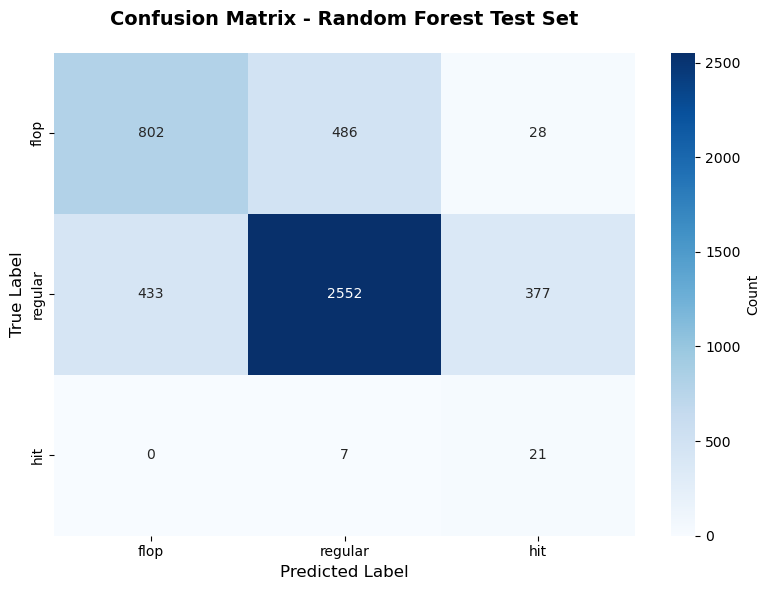

In [68]:
# Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Confusion Matrix on Test Set
y_test_pred_rf = grid_search_rf.predict(X_test_scaled)
cm_test = confusion_matrix(y_test, y_test_pred_rf, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

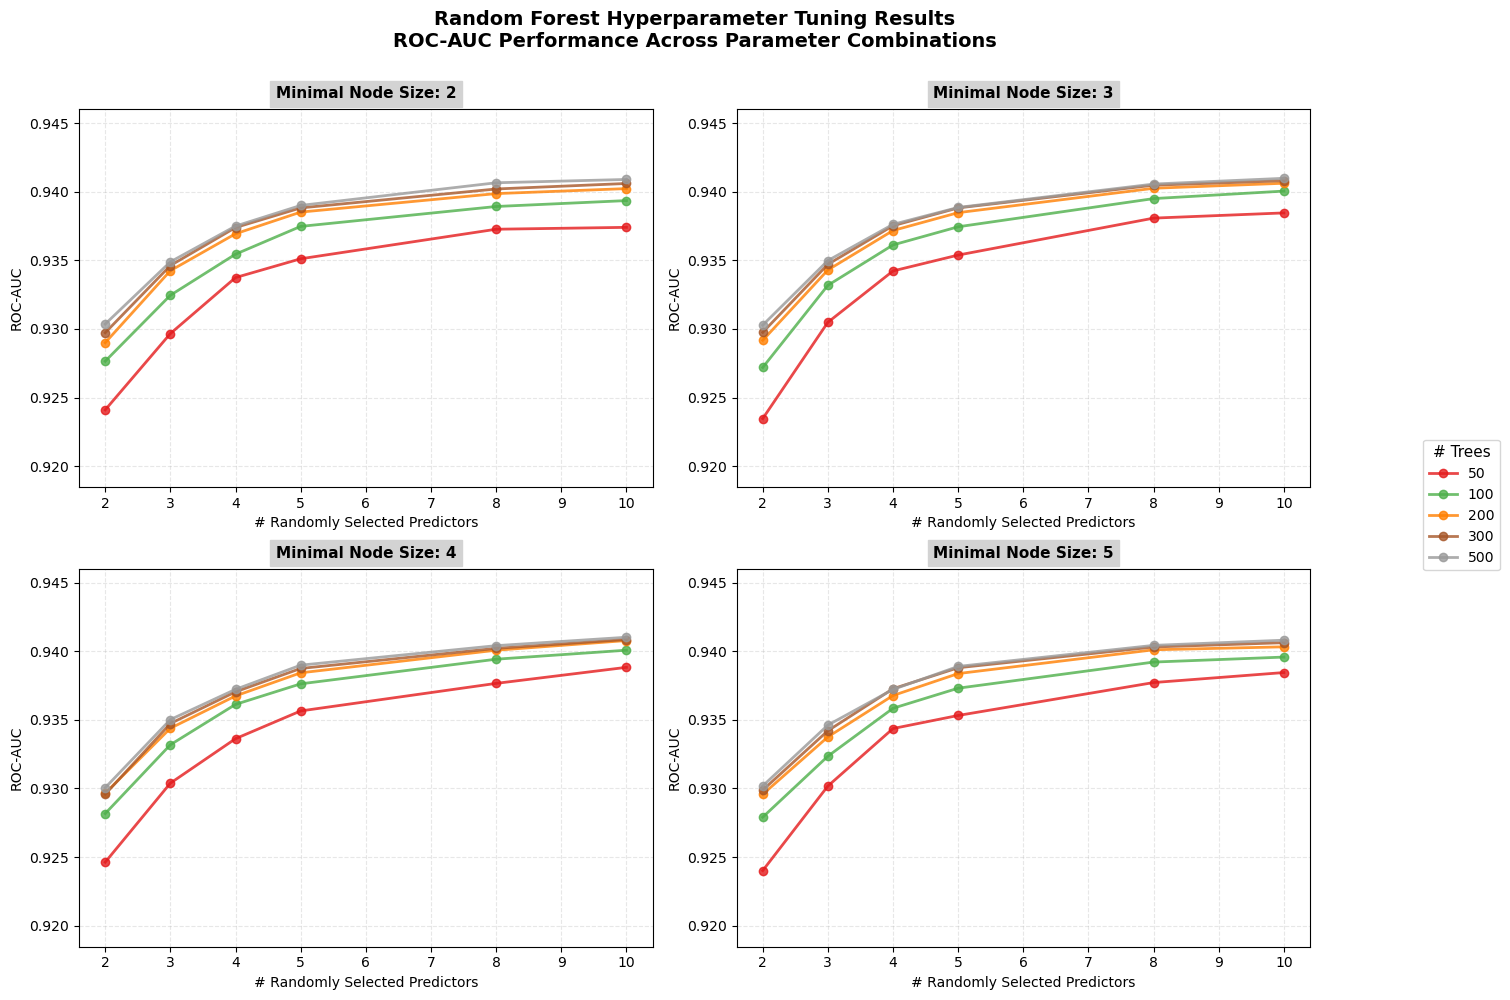

In [69]:
# Faceted Hyperparameter Performance Plot
results_df_rf = pd.DataFrame(grid_search_rf.cv_results_)
min_samples_splits = sorted(results_df_rf['param_min_samples_split'].unique())
n_estimators_list = sorted(results_df_rf['param_n_estimators'].unique())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors_rf = plt.cm.Set1(np.linspace(0, 1, len(n_estimators_list)))

# Plot for each min_samples_split
for idx, min_split in enumerate(min_samples_splits):
    ax = axes[idx]
    
    for n_est, color in zip(n_estimators_list, colors_rf):
        mask = (results_df_rf['param_min_samples_split'] == min_split) & \
               (results_df_rf['param_n_estimators'] == n_est)
        data = results_df_rf[mask].sort_values('param_max_features')
        
        if len(data) > 0:
            max_features = data['param_max_features'].values
            roc_aucs = data['mean_test_roc_auc'].values
            ax.plot(max_features, roc_aucs, 'o-', color=color, 
                   label=f'{n_est}', linewidth=2, markersize=6, alpha=0.8)
    
    ax.set_title(f'Minimal Node Size: {min_split}', fontsize=11, fontweight='bold', 
                 backgroundcolor='lightgray', pad=8)
    ax.set_xlabel('# Randomly Selected Predictors', fontsize=10)
    ax.set_ylabel('ROC-AUC', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([results_df_rf['mean_test_roc_auc'].min() - 0.005, 
                 results_df_rf['mean_test_roc_auc'].max() + 0.005])

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='# Trees', loc='center right', 
          bbox_to_anchor=(1.08, 0.5), frameon=True, fontsize=10, title_fontsize=11)

plt.suptitle('Random Forest Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 0.95, 0.99])
plt.show()

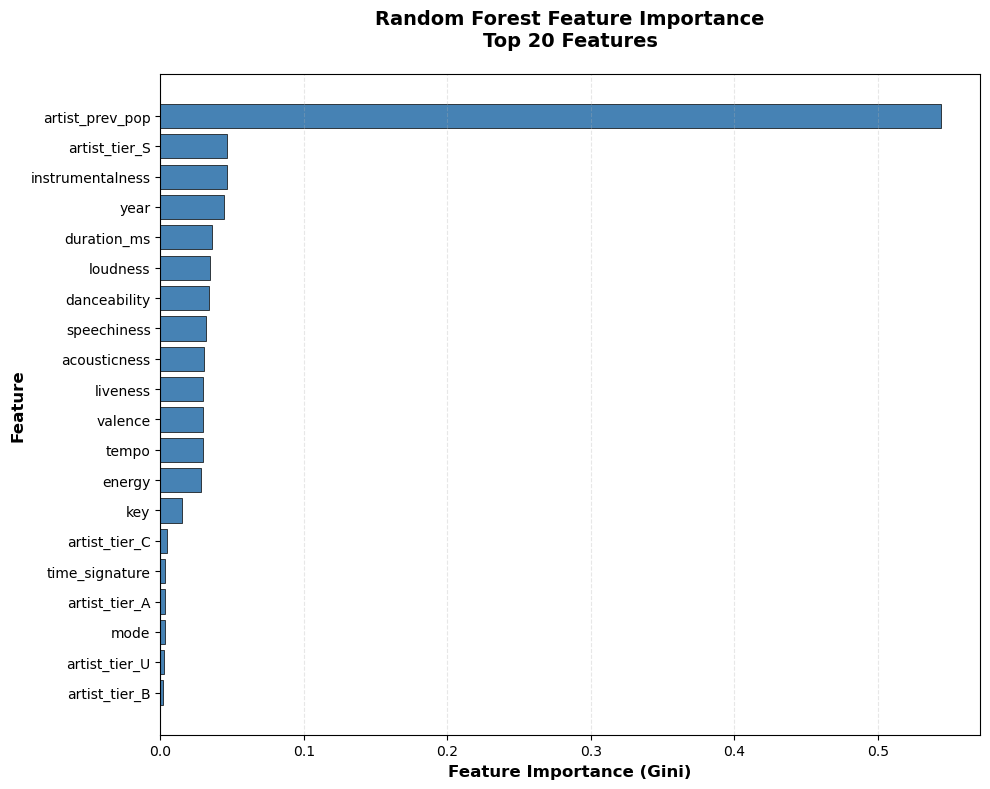

In [78]:
# Feature Importance Plot

# Get feature importances from the best model
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=True)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].tail(20), importance_df['importance'].tail(20), 
         color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Feature Importance (Gini)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Random Forest Feature Importance\nTop 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



In [71]:
# Save the best model and results for later comparison
rf_model_best = grid_search_rf.best_estimator_
rf_results = {
    'model_name': 'Random Forest',
    'best_params': grid_search_rf.best_params_,
    'cv_roc_auc': grid_search_rf.cv_results_['mean_test_roc_auc'][best_idx_rf],
    'cv_roc_auc_std': grid_search_rf.cv_results_['std_test_roc_auc'][best_idx_rf],
    'cv_accuracy': grid_search_rf.cv_results_['mean_test_accuracy'][best_idx_rf],
    'cv_accuracy_std': grid_search_rf.cv_results_['std_test_accuracy'][best_idx_rf],
    'test_roc_auc': test_roc_auc_rf,
    'test_accuracy': test_accuracy_rf,
    'grid_search': grid_search_rf,
    'feature_importance': importance_df
}

print("="*60)
print("✓ Random Forest model and results saved")
print("="*60)
print("\nReady for next model (XGBoost)!")
print("\nComparison so far:")
print(f"  Elastic Net - CV ROC-AUC: {elastic_net_results['cv_roc_auc']:.4f}, Test ROC-AUC: {elastic_net_results['test_roc_auc']:.4f}")
print(f"  Random Forest - CV ROC-AUC: {rf_results['cv_roc_auc']:.4f}, Test ROC-AUC: {rf_results['test_roc_auc']:.4f}")


✓ Random Forest model and results saved

Ready for next model (XGBoost)!

Comparison so far:
  Elastic Net - CV ROC-AUC: 0.9396, Test ROC-AUC: 0.8329
  Random Forest - CV ROC-AUC: 0.9410, Test ROC-AUC: 0.8336


#### XGBoost

In [79]:
# Encode target labels to numeric for XGBoost
from sklearn import preprocessing
label_encoder_xgb = preprocessing.LabelEncoder()
y_train_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_xgb = label_encoder_xgb.transform(y_test)

print("✓ Target labels encoded for XGBoost")
print(f"  Original labels: {label_encoder_xgb.classes_}")
print(f"  Encoded as: {list(range(len(label_encoder_xgb.classes_)))}")


✓ Target labels encoded for XGBoost
  Original labels: ['flop' 'hit' 'regular']
  Encoded as: [0, 1, 2]


In [110]:
### XGBoost with Hyperparameter Tuning
import xgboost as xgb

print("="*60)
print("XGBoost Model Setup")
print("="*60)

# Calculate class weights for handling imbalance
# XGBoost uses scale_pos_weight, but for multiclass we'll use sample_weight in fit
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"Class weights for handling imbalance:")
for cls, weight in class_weights.items():
    print(f"  {cls}: {weight:.3f}")

# Calculate number of features for colsample_bytree
n_features = len(feature_cols)
print(f"\nTotal features: {n_features}")

# Convert max_features counts to fractions for colsample_bytree
# Use this for multimodal whenhave excessive features
colsample_values = [0.6, 0.8, 1.0]
print(f"Column sample fractions (for {[2, 3, 5, 8, 10]} features): {[f'{x:.3f}' for x in colsample_values]}")

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300, 500, 750, 1000, 1500],
    'learning_rate': [0.005],
    'max_depth': [3, 4, 5, 8, 10],
    'subsample': [0.8],
    #'colsample_bytree': colsample_values
}

print(f"\nHyperparameter grid:")
print(f"  n_estimators: {param_grid_xgb['n_estimators']}")
print(f"  learning_rate: {param_grid_xgb['learning_rate']}")
print(f"  max_depth: {param_grid_xgb['max_depth']}")
print(f"  subsample: {param_grid_xgb['subsample']}")
#print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['colsample_bytree'])}")
print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])}")


# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multiclass classification with probability output
    eval_metric='mlogloss',  # Multiclass log loss
    random_state=42,
    n_jobs=-1,
    # early_stopping_rounds=10,  # Low bar for early stopping to push for full potential
    verbosity=0
)

print("\n✓ XGBoost model configured")
print("  - Objective: multi:softprob (multiclass)")
print("  - Class imbalance: handled via sample_weight during training")


XGBoost Model Setup
Class weights for handling imbalance:
  hit: 0.962
  regular: 0.997
  flop: 1.044

Total features: 21
Column sample fractions (for [2, 3, 5, 8, 10] features): ['0.600', '0.800', '1.000']

Hyperparameter grid:
  n_estimators: [50, 100, 200, 300, 500, 750, 1000, 1500]
  learning_rate: [0.005]
  max_depth: [3, 4, 5, 8, 10]
  subsample: [0.8]
  Total combinations: 40

✓ XGBoost model configured
  - Objective: multi:softprob (multiclass)
  - Class imbalance: handled via sample_weight during training


In [111]:
# Set up GridSearchCV
print("\n" + "="*60)
print("Setting up GridSearchCV for XGBoost")
print("="*60)

# Set up 5-fold stratified cross-validation (same as other models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up scoring metrics
scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

# Create sample weights for handling class imbalance
sample_weights = y_train.map(class_weights).values

# GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: sample weights applied")



Setting up GridSearchCV for XGBoost
✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: sample weights applied


In [ ]:
# Fit the XGBoost model with GridSearchCV

print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")
# Note: Early stopping is handled internally during each CV fold
grid_search_xgb.fit(X_train_scaled, y_train_xgb, sample_weight=sample_weights)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_xgb.best_params_['n_estimators']}")
print(f"  learning_rate: {grid_search_xgb.best_params_['learning_rate']}")
print(f"  max_depth: {grid_search_xgb.best_params_['max_depth']}")
print(f"  subsample: {grid_search_xgb.best_params_['subsample']}")

# Best cross-validation scores
best_idx_xgb = grid_search_xgb.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb]:.4f})")
print(f"  Accuracy: {grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb]:.4f})")

# Test set performance
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_test_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_labels)
test_roc_auc_xgb = roc_auc_score(y_test_xgb, y_test_proba_xgb, multi_class='ovr')
print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_xgb:.4f}")
print(f"  Accuracy: {test_accuracy_xgb:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb_labels))


# Save the best model
import joblib
joblib.dump(grid_search_xgb.best_estimator_, 'models/xgb_best_model_tab.pkl')
joblib.dump(grid_search_xgb, 'models/xgb_grid_search_tab.pkl')




Starting hyperparameter search...
(This may take a while due to the large number of combinations...)
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Grid Search Complete!

Best parameters:
  n_estimators: 1000
  learning_rate: 0.005
  max_depth: 8
  subsample: 0.8

Best cross-validation scores:
  ROC-AUC (OvR): 0.9428 (+/- 0.0047)
  Accuracy: 0.8225 (+/- 0.0078)

Test set performance:
  ROC-AUC (OvR): 0.8386
  Accuracy: 0.7184

Classification Report (Test Set):
              precision    recall  f1-score   support

        flop       0.63      0.62      0.62      1316
         hit       0.05      0.75      0.10        28
     regular       0.84      0.76      0.80      3362

    accuracy                           0.72      4706
   macro avg       0.51      0.71      0.51      4706
weighted avg       0.78      0.72      0.74      4706



In [ ]:
# Load the best model 
import joblib
grid_search_xgb = joblib.load('models/xgb_grid_search_tab.pkl')

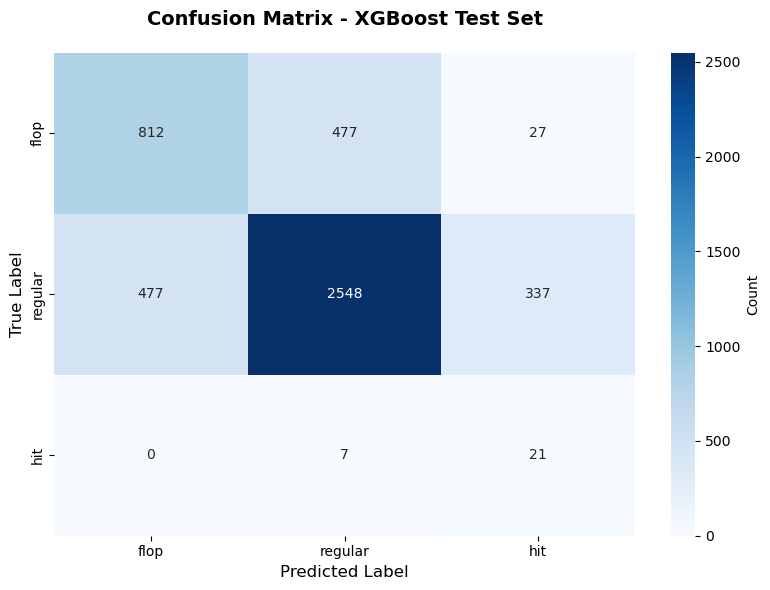

In [115]:
# XGBoost Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)

# Create confusion matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

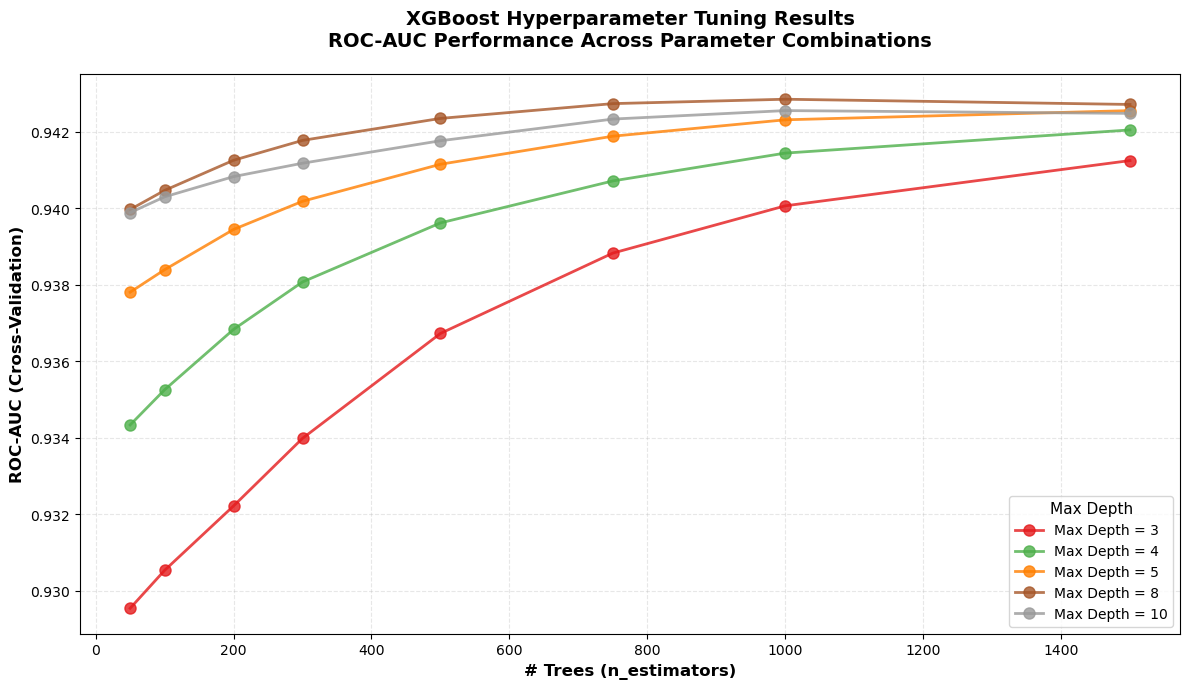

In [116]:
# XGBoost Hyperparameter Performance - Single Plot
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Aggregate over colsample_bytree (take best for each combination)
results_agg = results_df_xgb.groupby(['param_max_depth', 'param_n_estimators']).agg({
    'mean_test_roc_auc': 'max'
}).reset_index()

# Create single plot
plt.figure(figsize=(12, 7))

max_depths = sorted(results_agg['param_max_depth'].unique())
colors_xgb = plt.cm.Set1(np.linspace(0, 1, len(max_depths)))

# Plot for each max_depth
for depth, color in zip(max_depths, colors_xgb):
    mask = results_agg['param_max_depth'] == depth
    data = results_agg[mask].sort_values('param_n_estimators')
    
    n_estimators = data['param_n_estimators'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(n_estimators, roc_aucs, 'o-', color=color, 
           label=f'Max Depth = {depth}', linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('# Trees (n_estimators)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('XGBoost Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Max Depth', fontsize=10, title_fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

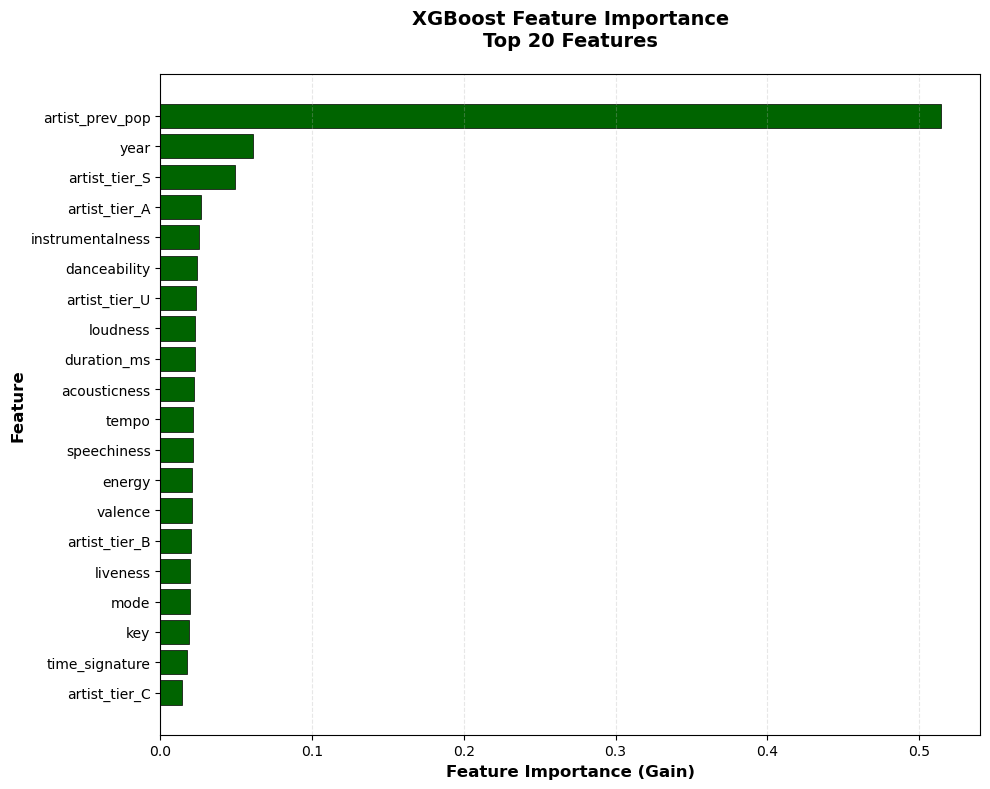

In [117]:
# Feature Importance Plot

# Get feature importances from the best model
feature_importances_xgb = grid_search_xgb.best_estimator_.feature_importances_

# Create a DataFrame for better visualization
importance_df_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances_xgb
}).sort_values('importance', ascending=True)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(importance_df_xgb['feature'].tail(20), importance_df_xgb['importance'].tail(20), 
         color='darkgreen', edgecolor='black', linewidth=0.5)
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('XGBoost Feature Importance\nTop 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


In [118]:
# Save the best model and results for later comparison
xgb_model_best = grid_search_xgb.best_estimator_
xgb_results = {
    'model_name': 'XGBoost',
    'best_params': grid_search_xgb.best_params_,
    'cv_roc_auc': grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb],
    'cv_roc_auc_std': grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb],
    'cv_accuracy': grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb],
    'cv_accuracy_std': grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb],
    'test_roc_auc': test_roc_auc_xgb,
    'test_accuracy': test_accuracy_xgb,
    'grid_search': grid_search_xgb,
    'feature_importance': importance_df_xgb
}

print("="*60)
print("✓ XGBoost model and results saved")
print("="*60)

print("="*60)
print("✓ Random Forest model and results saved")
print("="*60)
print("\nReady for next model (XGBoost)!")
print("\nComparison so far:")
print(f"  Elastic Net - CV ROC-AUC: {elastic_net_results['cv_roc_auc']:.4f}, Test ROC-AUC: {elastic_net_results['test_roc_auc']:.4f}")
print(f"  Random Forest - CV ROC-AUC: {rf_results['cv_roc_auc']:.4f}, Test ROC-AUC: {rf_results['test_roc_auc']:.4f}")
print(f"  XGBoost - CV ROC-AUC: {xgb_results['cv_roc_auc']:.4f}, Test ROC-AUC: {xgb_results['test_roc_auc']:.4f}")

✓ XGBoost model and results saved
✓ Random Forest model and results saved

Ready for next model (XGBoost)!

Comparison so far:
  Elastic Net - CV ROC-AUC: 0.9396, Test ROC-AUC: 0.8329
  Random Forest - CV ROC-AUC: 0.9410, Test ROC-AUC: 0.8336
  XGBoost - CV ROC-AUC: 0.9428, Test ROC-AUC: 0.8386


#### FFNN (Feed Forward Neural Network)

In [79]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [80]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [81]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0253       0.6411        0.8650  0.5471
      2        0.8532       0.6830        0.7491  0.4838
      3        0.7758       0.7130        0.6854  0.4845
      4        0.7134       0.7257        0.6410  0.4951
      5        0.6770       0.7397        0.6103  0.5060
      6        0.6533       0.7593        0.5819  0.4989
      7        0.6211       0.7657        0.5631  0.5061
      8        0.6095       0.7768        0.5424  0.5058
      9        0.5943       0.7752        0.5287  0.5041
     10        0.5788       0.7840        0.5181  0.5054
     11        0.5741       0.7860        0.5062  0.5307
     12        0.5635       0.7844        0.5029  0.5166
     13        0.5534       0.7876        0.4934  0.4993
     14        0.5483 

In [82]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1.pkl")

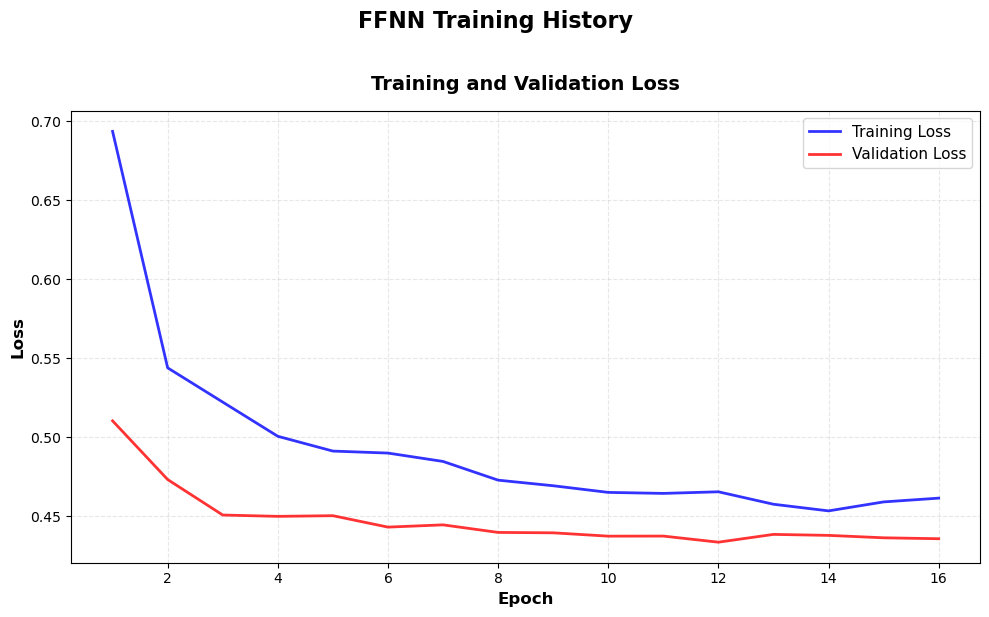

In [83]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


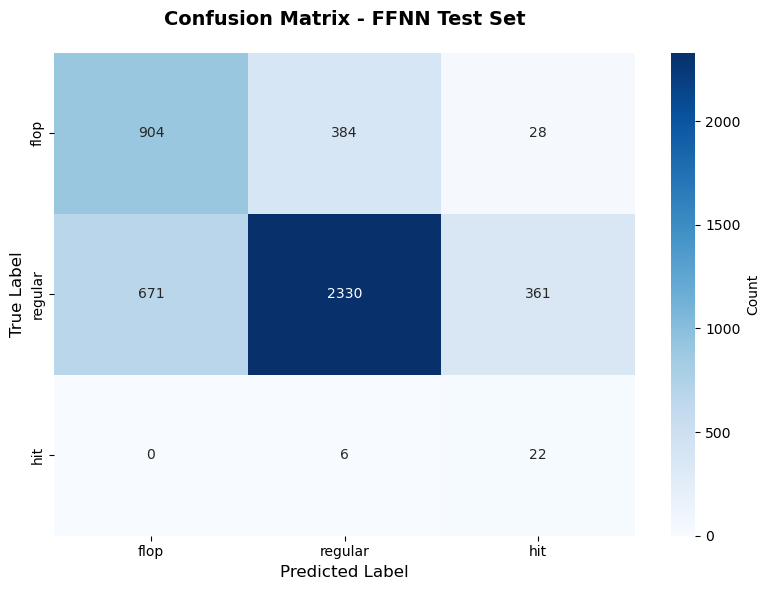

In [84]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

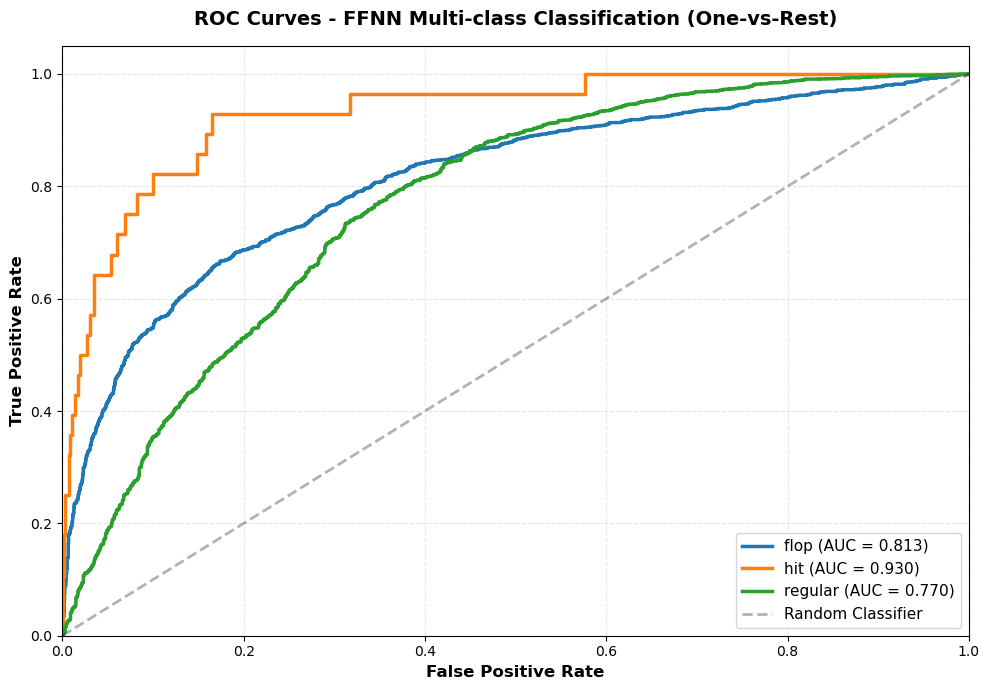

In [85]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



In [36]:
# Save the best model and results
ffnn_model_best = grid_search_ffnn.best_estimator_
ffnn_results = {
    'model_name': 'FFNN (PyTorch)',
    'best_params': grid_search_ffnn.best_params_,
    'cv_roc_auc': grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn],
    'cv_roc_auc_std': grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn],
    'cv_accuracy': grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn],
    'cv_accuracy_std': grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn],
    'test_roc_auc': test_roc_auc_ffnn,
    'test_accuracy': test_accuracy_ffnn,
    'grid_search': grid_search_ffnn,
    'history': history,
    'label_encoder': label_encoder
}

print("="*60)
print("✓ FFNN model and results saved")
print("="*60)
print("\nReady for final model comparison!")


✓ FFNN model and results saved

Ready for final model comparison!


#### Model Comparison Summary


FINAL MODEL COMPARISON - TABULAR DATA BASELINE

          Model Test Accuracy Test ROC-AUC Test F1 (Hit)
   Elastic Net        0.7091       0.8329        0.0888
 Random Forest        0.7172       0.8336        0.0925
       XGBoost        0.7184       0.8386        0.1017
FFNN (PyTorch)        0.7108       0.8345        0.1077

BEST MODEL (by Test ROC-AUC): XGBoost

All models trained and evaluated successfully!


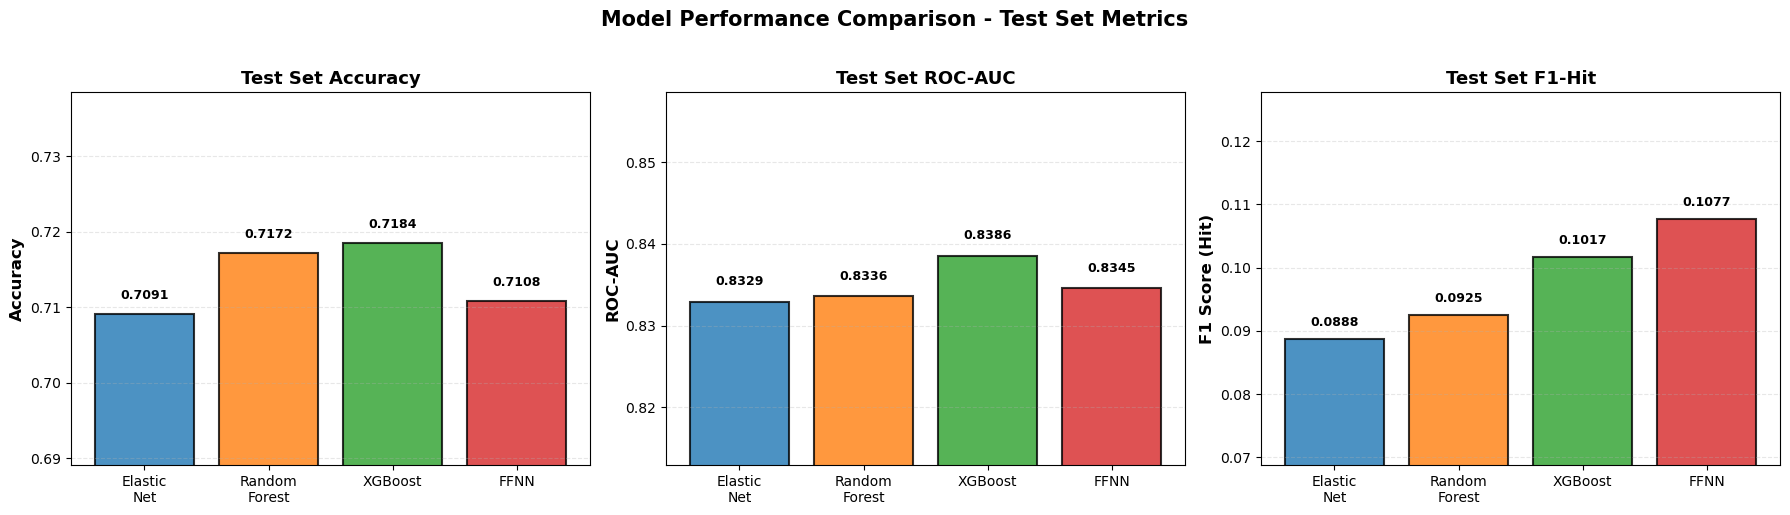


✓ Model comparison visualization created


In [132]:
### Model Comparison Summary
from sklearn.metrics import f1_score

print("\n" + "="*70)
print("FINAL MODEL COMPARISON - TABULAR DATA BASELINE")
print("="*70)

# Calculate F1 scores for 'hit' class on test set
# Elastic Net
y_test_pred_en = elastic_net_results['grid_search'].predict(X_test_scaled)
f1_hit_en = f1_score(y_test, y_test_pred_en, labels=['hit'], average='micro')

# Random Forest
y_test_pred_rf = rf_results['grid_search'].predict(X_test_scaled)
f1_hit_rf = f1_score(y_test, y_test_pred_rf, labels=['hit'], average='micro')

# XGBoost
y_test_pred_xgb = xgb_results['grid_search'].best_estimator_.predict(X_test_scaled)
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
f1_hit_xgb = f1_score(y_test, y_test_pred_xgb_labels, labels=['hit'], average='micro')

# FFNN
X_test_torch = X_test_scaled.astype(np.float32)
y_test_pred_ffnn = ffnn_results['grid_search'].best_estimator_.predict(X_test_torch)
y_test_pred_ffnn_labels = ffnn_results['label_encoder'].inverse_transform(y_test_pred_ffnn)
f1_hit_ffnn = f1_score(y_test, y_test_pred_ffnn_labels, labels=['hit'], average='micro')

# Create updated comparison table
comparison_data_updated = {
    'Model': ['Elastic Net', 'Random Forest', 'XGBoost', 'FFNN (PyTorch)'],
    'Test Accuracy': [
        f"{elastic_net_results['test_accuracy']:.4f}",
        f"{rf_results['test_accuracy']:.4f}",
        f"{xgb_results['test_accuracy']:.4f}",
        f"{ffnn_results['test_accuracy']:.4f}"
    ],
    'Test ROC-AUC': [
        f"{elastic_net_results['test_roc_auc']:.4f}",
        f"{rf_results['test_roc_auc']:.4f}",
        f"{xgb_results['test_roc_auc']:.4f}",
        f"{ffnn_results['test_roc_auc']:.4f}"
    ],
    'Test F1 (Hit)': [
        f"{f1_hit_en:.4f}",
        f"{f1_hit_rf:.4f}",
        f"{f1_hit_xgb:.4f}",
        f"{f1_hit_ffnn:.4f}"
    ]
}

comparison_df_updated = pd.DataFrame(comparison_data_updated)
print("\n", comparison_df_updated.to_string(index=False))

# Determine best model based on Test F1 for Hit class
best_model_idx_roc_auc = np.argmax([elastic_net_results['test_roc_auc'], rf_results['test_roc_auc'], xgb_results['test_roc_auc'], ffnn_results['test_roc_auc']])
best_model_name_roc_auc = ['Elastic Net', 'Random Forest', 'XGBoost', 'FFNN (PyTorch)'][best_model_idx_roc_auc]

print(f"\n{'='*70}")
print(f"BEST MODEL (by Test ROC-AUC): {best_model_name_roc_auc}")
print(f"{'='*70}")

print("\n" + "="*70)
print("All models trained and evaluated successfully!")
print("="*70)

# Create a bar plot comparing all models - 3 metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Elastic\nNet', 'Random\nForest', 'XGBoost', 'FFNN']
test_accuracy = [elastic_net_results['test_accuracy'], rf_results['test_accuracy'], 
                 xgb_results['test_accuracy'], ffnn_results['test_accuracy']]
test_roc_auc = [elastic_net_results['test_roc_auc'], rf_results['test_roc_auc'], 
                xgb_results['test_roc_auc'], ffnn_results['test_roc_auc']]
test_f1_hit = [f1_hit_en, f1_hit_rf, f1_hit_xgb, f1_hit_ffnn]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Test Accuracy
axes[0].bar(models, test_accuracy, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Test Set Accuracy', fontsize=13, fontweight='bold')
axes[0].set_ylim([min(test_accuracy) - 0.02, max(test_accuracy) + 0.02])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(test_accuracy):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

# Test ROC-AUC
axes[1].bar(models, test_roc_auc, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set ROC-AUC', fontsize=13, fontweight='bold')
axes[1].set_ylim([min(test_roc_auc) - 0.02, max(test_roc_auc) + 0.02])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(test_roc_auc):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

# Test F1-Hit
axes[2].bar(models, test_f1_hit, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[2].set_ylabel('F1 Score (Hit)', fontsize=12, fontweight='bold')
axes[2].set_title('Test Set F1-Hit', fontsize=13, fontweight='bold')
axes[2].set_ylim([min(test_f1_hit) - 0.02, max(test_f1_hit) + 0.02])
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(test_f1_hit):
    axes[2].text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Model Performance Comparison - Test Set Metrics', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Model comparison visualization created")

Consider the small size of test hits, we consider XGB and FFNN having similar f1 score for hit. However, XGB has significantly better accuracy and ROC_AUC compared to FFNN, after weighting the tradeoffs, we determine that the best baseline model is the tuned XGBoost model, which we will use as the fixed model for other modes, this is also in line with the framework provided in lecture.

### Add Text Description Data
Concatenate the embedding of test description of each song and tune a XGB to see if bimodal inputs improves the performance

Due to conputational constraints, we only compare with the baseline model (the best grid of XGBoost)

In [183]:
# Load the text description embeddings
text_description_emb = pd.read_csv('text_description_data/text_description_embeddings_20k.csv')

In [184]:
# Update text_desc to the tabular data
train_tab_text = pd.merge(train_tabular, text_description_emb, on='track_id', how='left')
test_tab_text = pd.merge(test_tabular, text_description_emb, on='track_id', how='left')

In [88]:
# Preprocess train and test data
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 793)
Test set shape: (4706, 793)

Features: 789
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35', 

#### XGBoost

In [7]:
# Encode target labels to numeric for XGBoost
from sklearn import preprocessing
label_encoder_xgb = preprocessing.LabelEncoder()
y_train_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_xgb = label_encoder_xgb.transform(y_test)

print("✓ Target labels encoded for XGBoost")
print(f"  Original labels: {label_encoder_xgb.classes_}")
print(f"  Encoded as: {list(range(len(label_encoder_xgb.classes_)))}")


✓ Target labels encoded for XGBoost
  Original labels: ['flop' 'hit' 'regular']
  Encoded as: [0, 1, 2]


In [12]:
### XGBoost with Hyperparameter Tuning
import xgboost as xgb

print("="*60)
print("XGBoost Model Setup")
print("="*60)

# Calculate class weights for handling imbalance
# XGBoost uses scale_pos_weight, but for multiclass we'll use sample_weight in fit
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"Class weights for handling imbalance:")
for cls, weight in class_weights.items():
    print(f"  {cls}: {weight:.3f}")

# Calculate number of features for colsample_bytree
n_features = len(feature_cols)
print(f"\nTotal features: {n_features}")

# Convert max_features counts to fractions for colsample_bytree
# Use this for multimodal whenhave excessive features
colsample_values = [0.6, 0.8, 1.0]

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.01],
    'max_depth': [3, 5, 8],
    'subsample': [0.8],
}

print(f"\nHyperparameter grid:")
print(f"  n_estimators: {param_grid_xgb['n_estimators']}")
print(f"  learning_rate: {param_grid_xgb['learning_rate']}")
print(f"  max_depth: {param_grid_xgb['max_depth']}")
print(f"  subsample: {param_grid_xgb['subsample']}")
#print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['colsample_bytree'])}")
print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])}")


try:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',  # Multiclass classification with probability output
        eval_metric='mlogloss',  # Multiclass log loss
        device='cuda',  # Use GPU (changed from 'cuda' with space)
        tree_method='hist',  # 'hist' is recommended for GPU
        random_state=42,
        verbosity=1  # Changed from 0 to 1 to see GPU messages
    )
    print("\n✓ XGBoost model configured for GPU training")
    print("  - Objective: multi:softprob (multiclass)")
    print("  - Device: CUDA (GPU)")
    print("  - Tree method: hist (GPU-optimized)")
except Exception as e:
    print(f"\n✗ GPU initialization failed: {e}")
    print("  Creating model with CPU fallback")
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        verbosity=1
    )

print("\n✓ XGBoost model configured")
print("  - Objective: multi:softprob (multiclass)")


XGBoost Model Setup
Class weights for handling imbalance:
  hit: 0.962
  regular: 0.997
  flop: 1.044

Total features: 789

Hyperparameter grid:
  n_estimators: [200, 400]
  learning_rate: [0.01]
  max_depth: [3, 5, 8]
  subsample: [0.8]
  Total combinations: 6

✓ XGBoost model configured for GPU training
  - Objective: multi:softprob (multiclass)
  - Device: CUDA (GPU)
  - Tree method: hist (GPU-optimized)

✓ XGBoost model configured
  - Objective: multi:softprob (multiclass)


In [13]:
from tqdm import tqdm
import time

# Set up GridSearchCV
print("\n" + "="*60)
print("Setting up GridSearchCV for XGBoost")
print("="*60)

# Set up 5-fold stratified cross-validation (same as other models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up scoring metrics
scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

class TqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        """Wrap the search with tqdm progress bar"""
        with tqdm(total=len(self.param_grid)) as pbar:
            def evaluate_candidates_progress(*args, **kwargs):
                scores = evaluate_candidates(*args, **kwargs)
                pbar.update(1)
                return scores
            super()._run_search(evaluate_candidates_progress)


# GridSearchCV with XGBoost
grid_search_xgb = TqdmGridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: sample weights applied")



Setting up GridSearchCV for XGBoost
✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: sample weights applied


In [14]:
# Fit the XGBoost model with GridSearchCV

print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")
# Note: Early stopping is handled internally during each CV fold
grid_search_xgb.fit(X_train_scaled, y_train_xgb)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_xgb.best_params_['n_estimators']}")
print(f"  learning_rate: {grid_search_xgb.best_params_['learning_rate']}")
print(f"  max_depth: {grid_search_xgb.best_params_['max_depth']}")
print(f"  subsample: {grid_search_xgb.best_params_['subsample']}")

# Best cross-validation scores
best_idx_xgb = grid_search_xgb.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb]:.4f})")
print(f"  Accuracy: {grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb]:.4f})")

# Test set performance
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_test_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_labels)
test_roc_auc_xgb = roc_auc_score(y_test_xgb, y_test_proba_xgb, multi_class='ovr')
print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_xgb:.4f}")
print(f"  Accuracy: {test_accuracy_xgb:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb_labels))


# Save the best model
import joblib
joblib.dump(grid_search_xgb, 'models/xgb_grid_search_tab_text.pkl')



Starting hyperparameter search...
(This may take a while due to the large number of combinations...)


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


 25%|██▌       | 1/4 [35:40<1:47:00, 2140.14s/it]



Grid Search Complete!

Best parameters:
  n_estimators: 400
  learning_rate: 0.01
  max_depth: 5
  subsample: 0.8

Best cross-validation scores:
  ROC-AUC (OvR): 0.9528 (+/- 0.0041)
  Accuracy: 0.8405 (+/- 0.0094)

Test set performance:
  ROC-AUC (OvR): 0.8205
  Accuracy: 0.7048

Classification Report (Test Set):
              precision    recall  f1-score   support

        flop       0.62      0.59      0.60      1316
         hit       0.05      0.71      0.09        28
     regular       0.83      0.75      0.79      3362

    accuracy                           0.70      4706
   macro avg       0.50      0.68      0.49      4706
weighted avg       0.77      0.70      0.73      4706



['models/xgb_grid_search_tab_text.pkl']

In [ ]:
# Load the best model 
import joblib
grid_search_xgb = joblib.load('models/xgb_grid_search_tab_text.pkl')

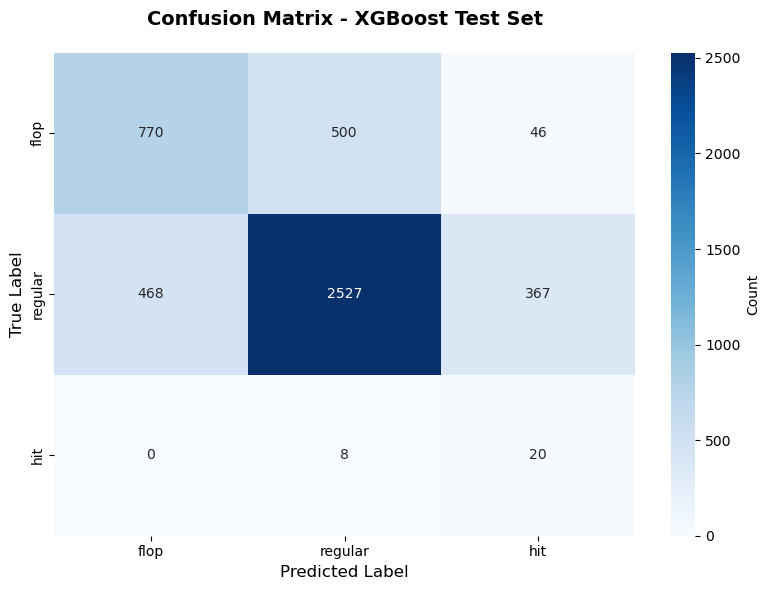

In [15]:
# XGBoost Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)

# Create confusion matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

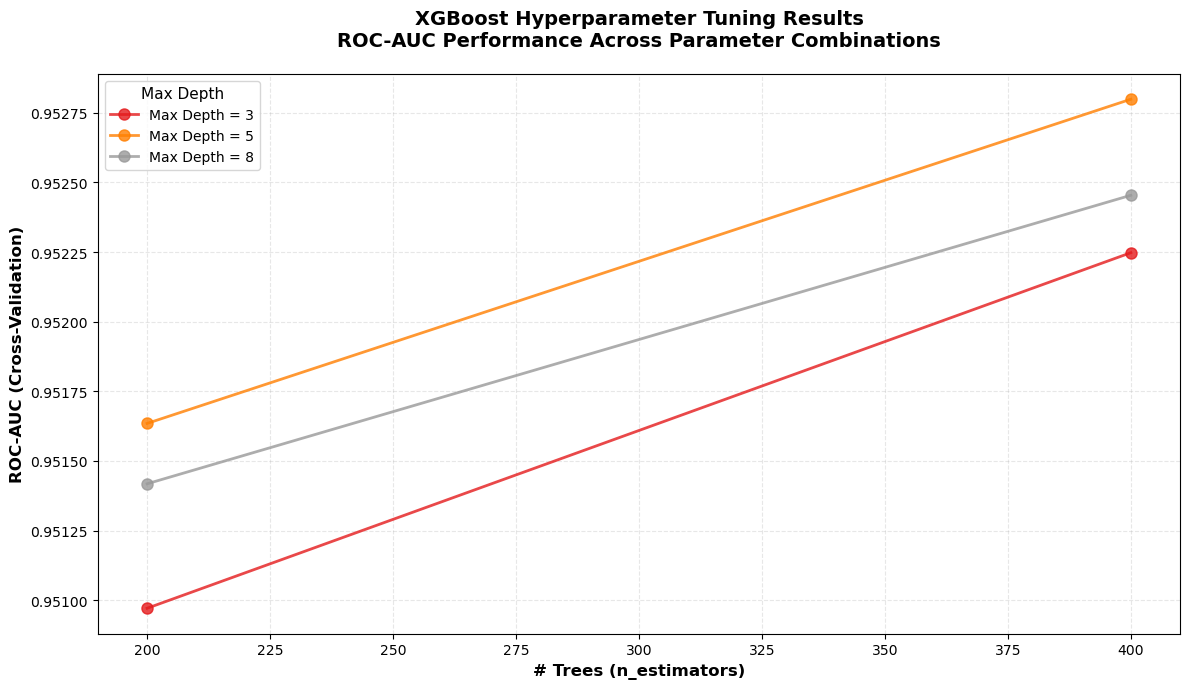

In [18]:
# XGBoost Hyperparameter Performance - Single Plot
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Aggregate over colsample_bytree (take best for each combination)
results_agg = results_df_xgb.groupby(['param_max_depth', 'param_n_estimators']).agg({
    'mean_test_roc_auc': 'max'
}).reset_index()

# Create single plot
plt.figure(figsize=(12, 7))

max_depths = sorted(results_agg['param_max_depth'].unique())
colors_xgb = plt.cm.Set1(np.linspace(0, 1, len(max_depths)))

# Plot for each max_depth
for depth, color in zip(max_depths, colors_xgb):
    mask = results_agg['param_max_depth'] == depth
    data = results_agg[mask].sort_values('param_n_estimators')
    
    n_estimators = data['param_n_estimators'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(n_estimators, roc_aucs, 'o-', color=color, 
           label=f'Max Depth = {depth}', linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('# Trees (n_estimators)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('XGBoost Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Max Depth', fontsize=10, title_fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### FFNN

We also try to see if FFNN gives us comapriable results

In [89]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [90]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0, 0.0001],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [91]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6528       0.8244        0.4621  0.6539
      2        0.4717       0.8299        0.4228  0.5178
      3        0.4401       0.8335        0.4094  0.4893
      4        0.4217       0.8347        0.4021  0.4907
      5        0.4211       0.8327        0.3986  0.4936
      6        0.4164       0.8339        0.3948  0.4973
      7        0.4113       0.8355        0.3929  0.4974
      8        0.4089       0.8339        0.3914  0.4984
      9        0.4125       0.8335        0.3910  0.4934
     10        0.4063       0.8343        0.3887  0.4880
     11        0.4043       0.8323        0.3884  0.4936
     12        0.4025       0.8355        0.3870  0.4874
     13        0.3994       0.8331        0.3879  0.4941
     14        0.3975 

In [92]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2.pkl")


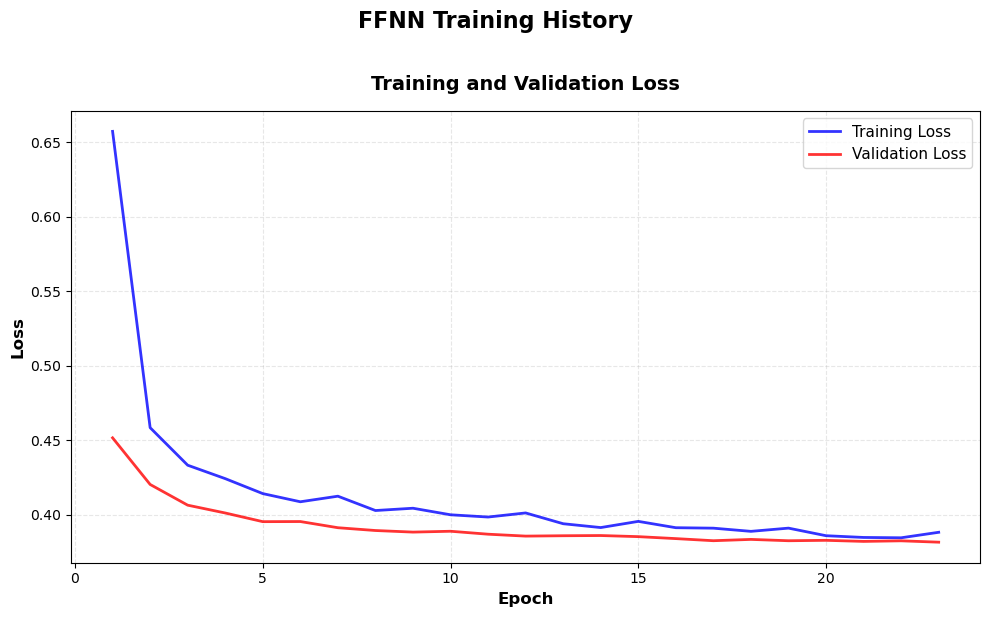

In [93]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


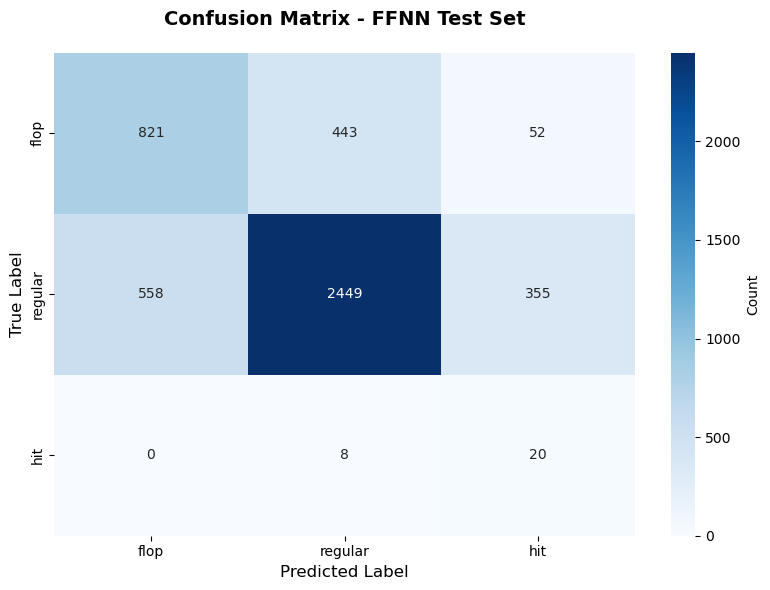

In [94]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

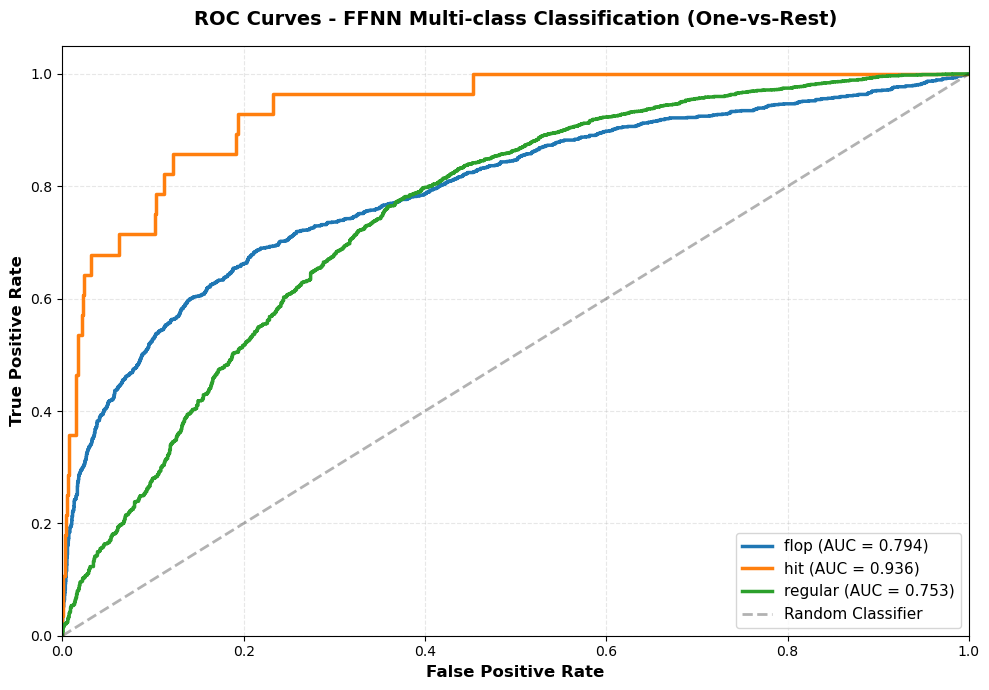

In [95]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Audio Data
Concatenate the embedding of audio of each song and tune a XGB to see if trimodal inputs improves the performance

In [185]:
# Load the text description embeddings
audio_emb = pd.read_parquet('audio_data/audio_embeddings_mert_330M.parquet')

In [186]:
# Update text_desc to the tabular data
train_tab_text_audio = pd.merge(train_tab_text, audio_emb, on='track_id', how='left')
test_tab_text_audio = pd.merge(test_tab_text, audio_emb, on='track_id', how='left')

In [98]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 1817)
Test set shape: (4706, 1817)

Features: 1813
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35

#### XGBoost

In [57]:
# Encode target labels to numeric for XGBoost
from sklearn import preprocessing
label_encoder_xgb = preprocessing.LabelEncoder()
y_train_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_xgb = label_encoder_xgb.transform(y_test)

print("✓ Target labels encoded for XGBoost")
print(f"  Original labels: {label_encoder_xgb.classes_}")
print(f"  Encoded as: {list(range(len(label_encoder_xgb.classes_)))}")


✓ Target labels encoded for XGBoost
  Original labels: ['flop' 'hit' 'regular']
  Encoded as: [0, 1, 2]


In [ ]:
### XGBoost with Hyperparameter Tuning
import xgboost as xgb

print("="*60)
print("XGBoost Model Setup")
print("="*60)

# Calculate class weights for handling imbalance
# XGBoost uses scale_pos_weight, but for multiclass we'll use sample_weight in fit
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"Class weights for handling imbalance:")
for cls, weight in class_weights.items():
    print(f"  {cls}: {weight:.3f}")

# Calculate number of features for colsample_bytree
n_features = len(feature_cols)
print(f"\nTotal features: {n_features}")

# Convert max_features counts to fractions for colsample_bytree
# Use this for multimodal whenhave excessive features
colsample_values = [0.6, 0.8, 1.0]

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.01],
    'max_depth': [3, 5, 8],
    'subsample': [0.8],
    #'colsample_bytree': colsample_values
}

print(f"\nHyperparameter grid:")
print(f"  n_estimators: {param_grid_xgb['n_estimators']}")
print(f"  learning_rate: {param_grid_xgb['learning_rate']}")
print(f"  max_depth: {param_grid_xgb['max_depth']}")
print(f"  subsample: {param_grid_xgb['subsample']}")
#print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['colsample_bytree'])}")
print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])}")


# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multiclass classification with probability output
    eval_metric='mlogloss',  # Multiclass log loss
    random_state=42,
    n_jobs=-1,
    # early_stopping_rounds=10,  # Low bar for early stopping to push for full potential
    verbosity=0
)

print("\n✓ XGBoost model configured")
print("  - Objective: multi:softprob (multiclass)")
print("  - Class imbalance: handled via sample_weight during training")


In [ ]:
# Set up GridSearchCV
print("\n" + "="*60)
print("Setting up GridSearchCV for XGBoost")
print("="*60)

# Set up 5-fold stratified cross-validation (same as other models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up scoring metrics
scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

# Create sample weights for handling class imbalance
sample_weights = y_train.map(class_weights).values

# GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: sample weights applied")


In [ ]:
# Fit the XGBoost model with GridSearchCV

print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")
# Note: Early stopping is handled internally during each CV fold
grid_search_xgb.fit(X_train_scaled, y_train_xgb, sample_weight=sample_weights)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_xgb.best_params_['n_estimators']}")
print(f"  learning_rate: {grid_search_xgb.best_params_['learning_rate']}")
print(f"  max_depth: {grid_search_xgb.best_params_['max_depth']}")
print(f"  subsample: {grid_search_xgb.best_params_['subsample']}")

# Best cross-validation scores
best_idx_xgb = grid_search_xgb.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb]:.4f})")
print(f"  Accuracy: {grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb]:.4f})")

# Test set performance
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_test_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_labels)
test_roc_auc_xgb = roc_auc_score(y_test_xgb, y_test_proba_xgb, multi_class='ovr')
print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_xgb:.4f}")
print(f"  Accuracy: {test_accuracy_xgb:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb_labels))


# Save the best model
import joblib
joblib.dump(grid_search_xgb, 'models/xgb_grid_search_tab_text_audio.pkl')


In [ ]:
# Load the best model 
import joblib
grid_search_xgb = joblib.load('models/xgb_grid_search_tab_text_audio.pkl')

In [ ]:
# XGBoost Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)

# Create confusion matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost Hyperparameter Performance - Single Plot
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Aggregate over colsample_bytree (take best for each combination)
results_agg = results_df_xgb.groupby(['param_max_depth', 'param_n_estimators']).agg({
    'mean_test_roc_auc': 'max'
}).reset_index()

# Create single plot
plt.figure(figsize=(12, 7))

max_depths = sorted(results_agg['param_max_depth'].unique())
colors_xgb = plt.cm.Set1(np.linspace(0, 1, len(max_depths)))

# Plot for each max_depth
for depth, color in zip(max_depths, colors_xgb):
    mask = results_agg['param_max_depth'] == depth
    data = results_agg[mask].sort_values('param_n_estimators')
    
    n_estimators = data['param_n_estimators'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(n_estimators, roc_aucs, 'o-', color=color, 
           label=f'Max Depth = {depth}', linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('# Trees (n_estimators)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('XGBoost Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Max Depth', fontsize=10, title_fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### FFNN

In [99]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [100]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [101]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7667       0.8112        0.5155  0.7239
      2        0.5015       0.8263        0.4421  0.5541
      3        0.4504       0.8279        0.4182  0.5574
      4        0.4317       0.8299        0.4076  0.5364
      5        0.4264       0.8319        0.4024  0.5290
      6        0.4133       0.8343        0.3964  0.5335
      7        0.4105       0.8363        0.3934  0.5377
      8        0.4029       0.8327        0.3912  0.5414
      9        0.3950       0.8363        0.3900  0.5374
     10        0.3886       0.8343        0.3888  0.5378
     11        0.3857       0.8355        0.3883  0.5379
     12        0.3815       0.8375        0.3879  0.5337
     13        0.3769       0.8395        0.3867  0.5340
     14        0.3744 

In [102]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3.pkl")

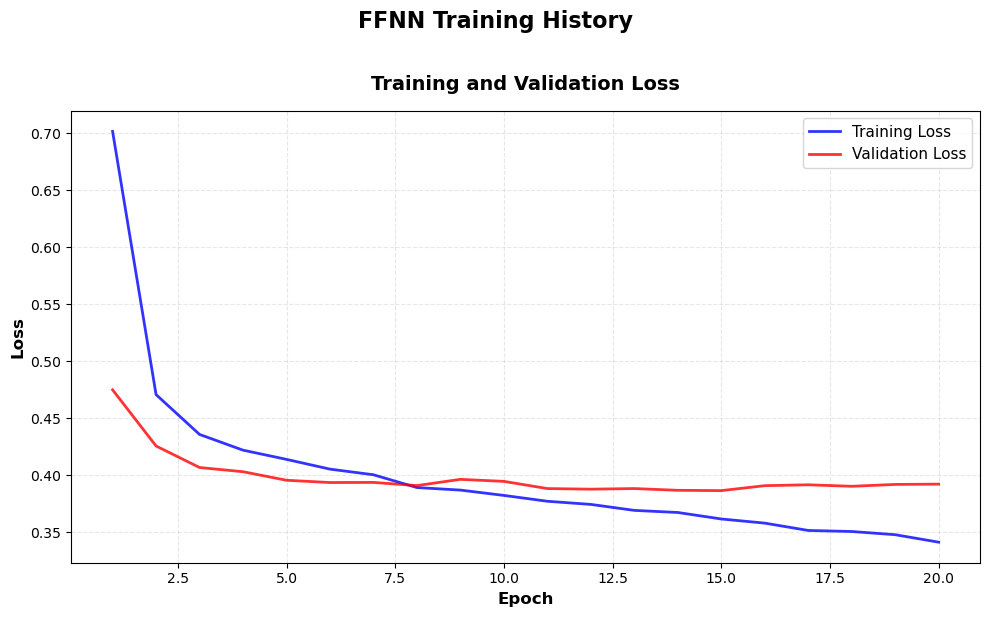

In [103]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


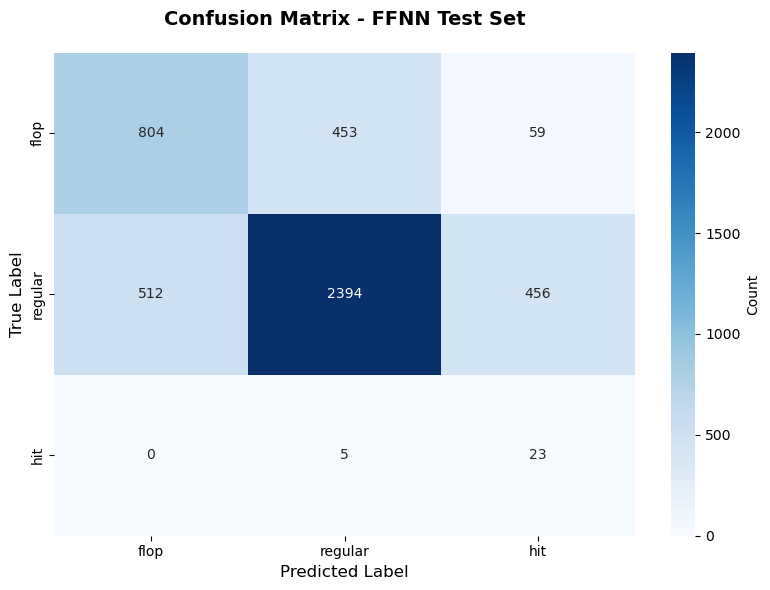

In [104]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

Best threshold: 0.9798994974874372
Best F1: 0.25


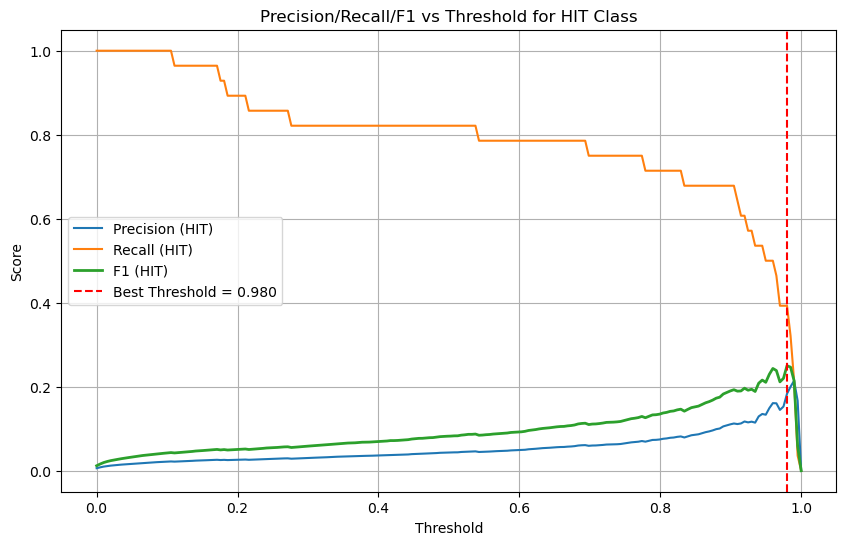

In [105]:
# Tune threshold for best hit f1 score
y_pred_proba = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

hit_index = 1  # Changed from 2 to 1 - this is the actual HIT class with 28 samples
probs_hit = y_pred_proba[:, hit_index]

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.0, 1.0, 200)
precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    y_pred_hit = (probs_hit >= t).astype(int)      # predicted HIT/not-HIT
    y_true_hit = (y_test_encoded == hit_index).astype(int) # ground truth HIT/not-HIT

    precision_list.append(precision_score(y_true_hit, y_pred_hit, zero_division=0))
    recall_list.append(recall_score(y_true_hit, y_pred_hit))
    f1_list.append(f1_score(y_true_hit, y_pred_hit))


best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
best_f1 = f1_list[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label="Precision (HIT)")
plt.plot(thresholds, recall_list, label="Recall (HIT)")
plt.plot(thresholds, f1_list, label="F1 (HIT)", linewidth=2)

plt.axvline(best_threshold, color='red', linestyle='--', 
             label=f"Best Threshold = {best_threshold:.3f}")
plt.title("Precision/Recall/F1 vs Threshold for HIT Class")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()



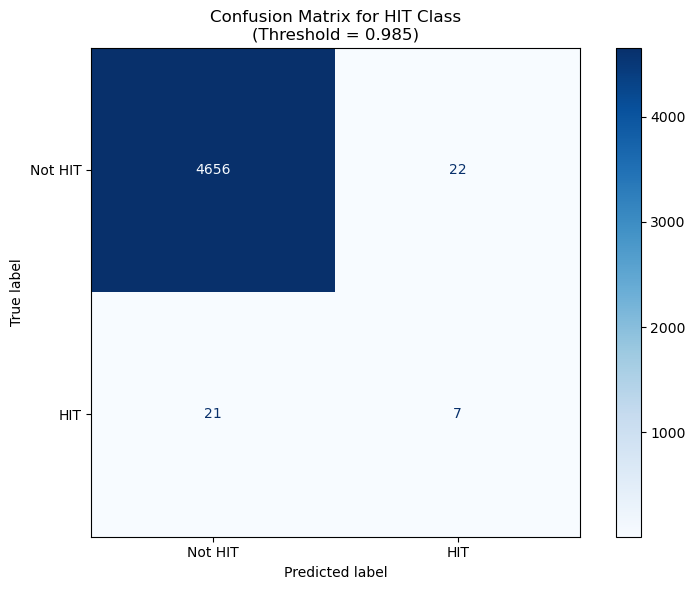


Confusion Matrix:
True Negatives (TN): 4656
False Positives (FP): 22
False Negatives (FN): 21
True Positives (TP): 7

Accuracy: 0.9909
Precision: 0.2414
Recall: 0.2500
F1 Score: 0.2456


In [65]:
# Confusion matrix with best hit threshold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create predictions using the best threshold
y_pred_hit = (probs_hit >= best_threshold).astype(int)
y_true_hit = (y_test_encoded == hit_index).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true_hit, y_pred_hit)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Not HIT', 'HIT'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix for HIT Class\n(Threshold = {best_threshold:.3f})')
plt.tight_layout()
plt.show()

# Print additional metrics
print(f"\nConfusion Matrix:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")
print(f"\nAccuracy: {(cm[0,0] + cm[1,1]) / cm.sum():.4f}")
print(f"Precision: {precision_list[best_idx]:.4f}")
print(f"Recall: {recall_list[best_idx]:.4f}")
print(f"F1 Score: {best_f1:.4f}")

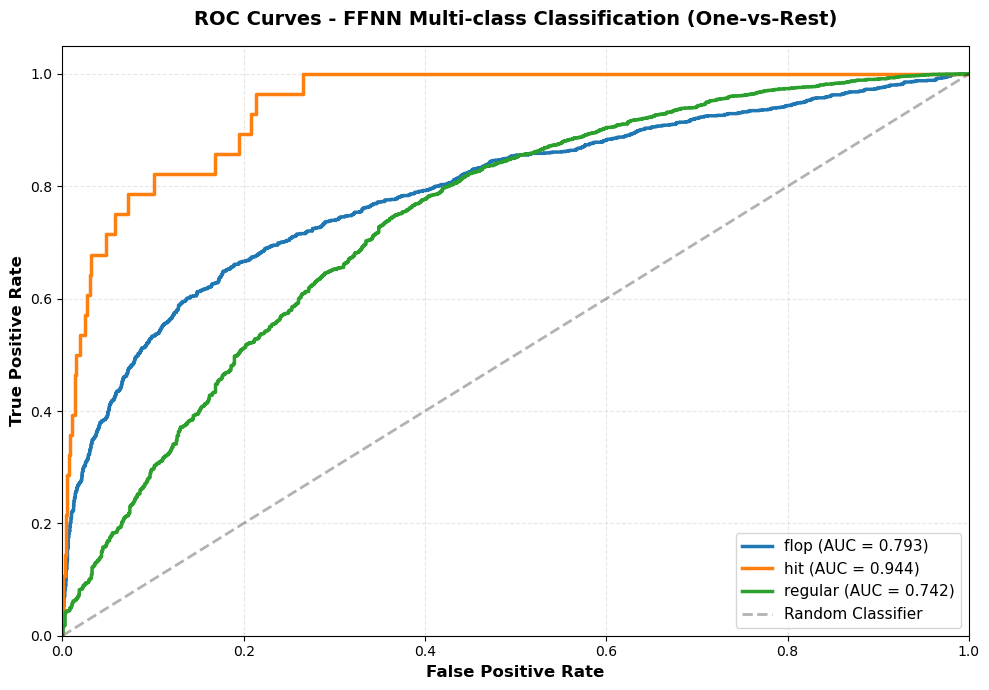

In [106]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Lyrics Data
Concatenate the embedding of lyrics of each song and tune a XGB to see if 4-modal inputs improves the performance

In [187]:
# Load the text description embeddings
lyrics_emb = pd.read_csv('lyrics_data/lyrics_embeddings_20k.csv')

In [188]:
# Update text_desc to the tabular data
train_tab_text_audio_lyrics = pd.merge(train_tab_text_audio, lyrics_emb, on='track_id', how='left')
test_tab_text_audio_lyrics = pd.merge(test_tab_text_audio, lyrics_emb, on='track_id', how='left')

In [164]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 2585)
Test set shape: (4706, 2585)

Features: 2581
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35

#### XGBoost

In [ ]:
# Encode target labels to numeric for XGBoost
from sklearn import preprocessing
label_encoder_xgb = preprocessing.LabelEncoder()
y_train_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_xgb = label_encoder_xgb.transform(y_test)

print("✓ Target labels encoded for XGBoost")
print(f"  Original labels: {label_encoder_xgb.classes_}")
print(f"  Encoded as: {list(range(len(label_encoder_xgb.classes_)))}")


✓ Target labels encoded for XGBoost
  Original labels: ['flop' 'hit' 'regular']
  Encoded as: [0, 1, 2]


In [ ]:
### XGBoost with Hyperparameter Tuning
import xgboost as xgb

print("="*60)
print("XGBoost Model Setup")
print("="*60)

# Calculate class weights for handling imbalance
# XGBoost uses scale_pos_weight, but for multiclass we'll use sample_weight in fit
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"Class weights for handling imbalance:")
for cls, weight in class_weights.items():
    print(f"  {cls}: {weight:.3f}")

# Calculate number of features for colsample_bytree
n_features = len(feature_cols)
print(f"\nTotal features: {n_features}")

# Convert max_features counts to fractions for colsample_bytree
# Use this for multimodal whenhave excessive features
colsample_values = [0.6, 0.8, 1.0]

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.005],
    'max_depth': [3, 5, 8],
    'subsample': [0.8],
    #'colsample_bytree': colsample_values
}

print(f"\nHyperparameter grid:")
print(f"  n_estimators: {param_grid_xgb['n_estimators']}")
print(f"  learning_rate: {param_grid_xgb['learning_rate']}")
print(f"  max_depth: {param_grid_xgb['max_depth']}")
print(f"  subsample: {param_grid_xgb['subsample']}")
#print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['colsample_bytree'])}")
print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])}")


# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multiclass classification with probability output
    eval_metric='mlogloss',  # Multiclass log loss
    random_state=42,
    n_jobs=-1,
    # early_stopping_rounds=10,  # Low bar for early stopping to push for full potential
    verbosity=0
)

print("\n✓ XGBoost model configured")
print("  - Objective: multi:softprob (multiclass)")
print("  - Class imbalance: handled via sample_weight during training")


In [ ]:
# Set up GridSearchCV
print("\n" + "="*60)
print("Setting up GridSearchCV for XGBoost")
print("="*60)

# Set up 5-fold stratified cross-validation (same as other models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up scoring metrics
scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

# Create sample weights for handling class imbalance
sample_weights = y_train.map(class_weights).values

# GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: sample weights applied")


In [ ]:
# Fit the XGBoost model with GridSearchCV

print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")
# Note: Early stopping is handled internally during each CV fold
grid_search_xgb.fit(X_train_scaled, y_train_xgb, sample_weight=sample_weights)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_xgb.best_params_['n_estimators']}")
print(f"  learning_rate: {grid_search_xgb.best_params_['learning_rate']}")
print(f"  max_depth: {grid_search_xgb.best_params_['max_depth']}")
print(f"  subsample: {grid_search_xgb.best_params_['subsample']}")

# Best cross-validation scores
best_idx_xgb = grid_search_xgb.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb]:.4f})")
print(f"  Accuracy: {grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb]:.4f})")

# Test set performance
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_test_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_labels)
test_roc_auc_xgb = roc_auc_score(y_test_xgb, y_test_proba_xgb, multi_class='ovr')
print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_xgb:.4f}")
print(f"  Accuracy: {test_accuracy_xgb:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb_labels))


# Save the best model
import joblib
joblib.dump(grid_search_xgb, 'models/xgb_grid_search_tab_text_audio_lyrics.pkl')


In [ ]:
# Load the best model 
import joblib
grid_search_xgb = joblib.load('models/xgb_grid_search_tab_text_audio_lyrics.pkl')

In [ ]:
# XGBoost Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)

# Create confusion matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost Hyperparameter Performance - Single Plot
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Aggregate over colsample_bytree (take best for each combination)
results_agg = results_df_xgb.groupby(['param_max_depth', 'param_n_estimators']).agg({
    'mean_test_roc_auc': 'max'
}).reset_index()

# Create single plot
plt.figure(figsize=(12, 7))

max_depths = sorted(results_agg['param_max_depth'].unique())
colors_xgb = plt.cm.Set1(np.linspace(0, 1, len(max_depths)))

# Plot for each max_depth
for depth, color in zip(max_depths, colors_xgb):
    mask = results_agg['param_max_depth'] == depth
    data = results_agg[mask].sort_values('param_n_estimators')
    
    n_estimators = data['param_n_estimators'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(n_estimators, roc_aucs, 'o-', color=color, 
           label=f'Max Depth = {depth}', linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('# Trees (n_estimators)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('XGBoost Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Max Depth', fontsize=10, title_fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### FFNN

In [165]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [166]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [167]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6745       0.8216        0.4759  0.6019
      2        0.4655       0.8319        0.4187  0.5664
      3        0.4273       0.8351        0.3981  0.5546
      4        0.4088       0.8391        0.3881  0.5405
      5        0.3982       0.8375        0.3835  0.5452
      6        0.3876       0.8383        0.3814  0.5399
      7        0.3776       0.8379        0.3779  0.5300
      8        0.3719       0.8411        0.3760  0.5524
      9        0.3725       0.8347        0.3760  0.5416
     10        0.3642       0.8375        0.3755  0.5501
     11        0.3570       0.8367        0.3750  0.5505
     12        0.3535       0.8383        0.3746  0.5820
     13        0.3515       0.8387        0.3736  0.5457
     14        0.3468 

In [ ]:
import joblib

# Save the grid_search
#joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3_4.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3_4.pkl")

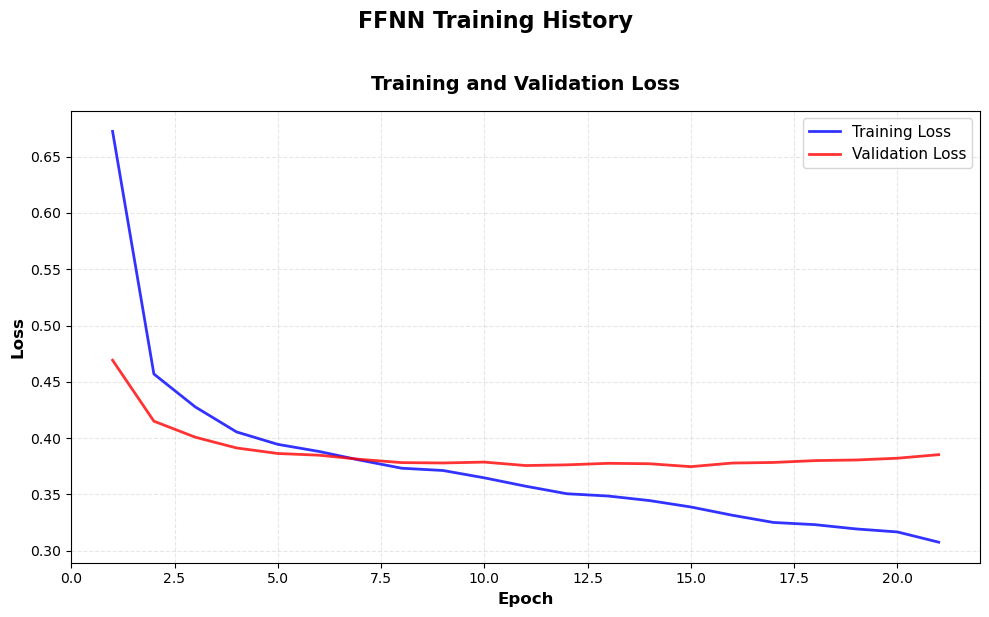

In [169]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


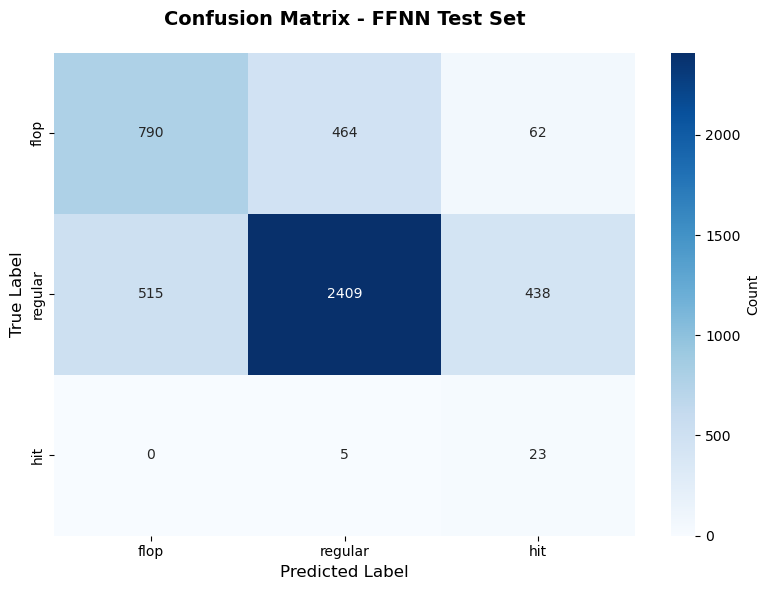

In [170]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

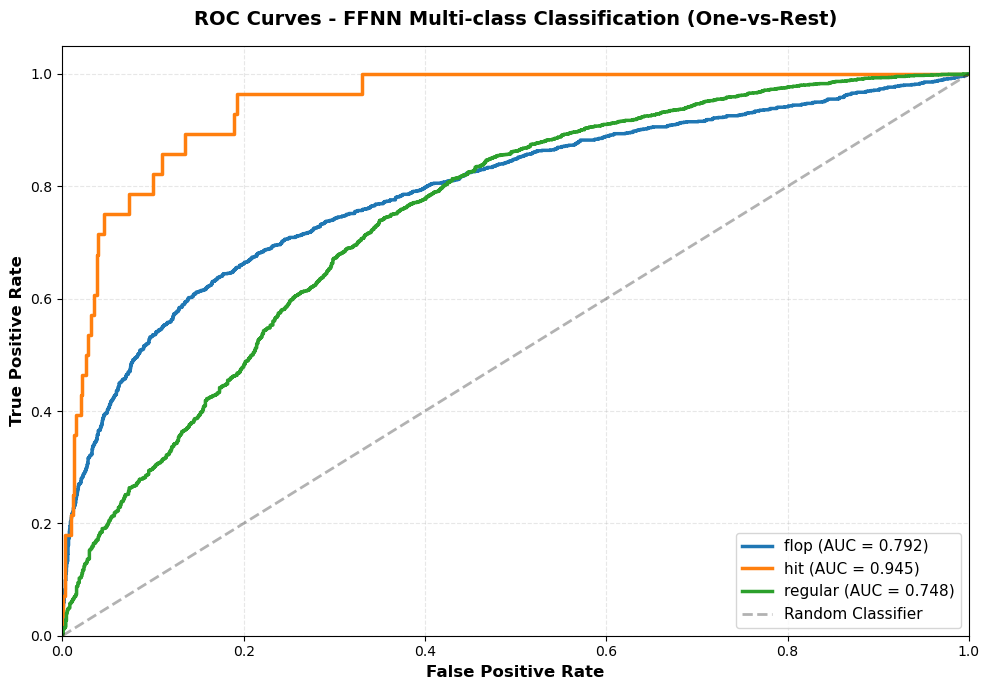

In [116]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Image Data
Concatenate the embedding of album cover of each song and tune a XGB to see if 5-modal inputs improves the performance

In [189]:
# Load the text description embeddings
image_emb = pd.read_csv('image_data/spotify_album_cover_embeddings.csv')

image_emb = image_emb.drop(columns=['artist_name', 'track_name', 'album_cover_path'], axis=1)

In [190]:
# Update text_desc to the tabular data
train_tab_text_audio_lyrics_image = pd.merge(train_tab_text_audio_lyrics, image_emb, on='track_id', how='left')
test_tab_text_audio_lyrics_image = pd.merge(test_tab_text_audio_lyrics, image_emb, on='track_id', how='left')

In [177]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 3097)
Test set shape: (4706, 3097)

Features: 3093
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35

#### XGBoost

In [ ]:
# Encode target labels to numeric for XGBoost
from sklearn import preprocessing
label_encoder_xgb = preprocessing.LabelEncoder()
y_train_xgb = label_encoder_xgb.fit_transform(y_train)
y_test_xgb = label_encoder_xgb.transform(y_test)

print("✓ Target labels encoded for XGBoost")
print(f"  Original labels: {label_encoder_xgb.classes_}")
print(f"  Encoded as: {list(range(len(label_encoder_xgb.classes_)))}")


✓ Target labels encoded for XGBoost
  Original labels: ['flop' 'hit' 'regular']
  Encoded as: [0, 1, 2]


In [ ]:
### XGBoost with Hyperparameter Tuning
import xgboost as xgb

print("="*60)
print("XGBoost Model Setup")
print("="*60)

# Calculate class weights for handling imbalance
# XGBoost uses scale_pos_weight, but for multiclass we'll use sample_weight in fit
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"Class weights for handling imbalance:")
for cls, weight in class_weights.items():
    print(f"  {cls}: {weight:.3f}")

# Calculate number of features for colsample_bytree
n_features = len(feature_cols)
print(f"\nTotal features: {n_features}")

# Convert max_features counts to fractions for colsample_bytree
# Use this for multimodal whenhave excessive features
colsample_values = [0.6, 0.8, 1.0]

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.01],
    'max_depth': [3, 5, 8],
    'subsample': [0.8],
    #'colsample_bytree': colsample_values
}

print(f"\nHyperparameter grid:")
print(f"  n_estimators: {param_grid_xgb['n_estimators']}")
print(f"  learning_rate: {param_grid_xgb['learning_rate']}")
print(f"  max_depth: {param_grid_xgb['max_depth']}")
print(f"  subsample: {param_grid_xgb['subsample']}")
#print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['colsample_bytree'])}")
print(f"  Total combinations: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])}")


# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Multiclass classification with probability output
    eval_metric='mlogloss',  # Multiclass log loss
    random_state=42,
    n_jobs=-1,
    # early_stopping_rounds=10,  # Low bar for early stopping to push for full potential
    verbosity=0
)

print("\n✓ XGBoost model configured")
print("  - Objective: multi:softprob (multiclass)")
print("  - Class imbalance: handled via sample_weight during training")


In [ ]:
# Set up GridSearchCV
print("\n" + "="*60)
print("Setting up GridSearchCV for XGBoost")
print("="*60)

# Set up 5-fold stratified cross-validation (same as other models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up scoring metrics
scoring = {
    'roc_auc': 'roc_auc_ovr',  # One-vs-Rest ROC-AUC for multi-class
    'accuracy': 'accuracy'
}

# Create sample weights for handling class imbalance
sample_weights = y_train.map(class_weights).values

# GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',  # Refit on best ROC-AUC
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: sample weights applied")


In [ ]:
# Fit the XGBoost model with GridSearchCV

print("\nStarting hyperparameter search...")
print("(This may take a while due to the large number of combinations...)")
# Note: Early stopping is handled internally during each CV fold
grid_search_xgb.fit(X_train_scaled, y_train_xgb, sample_weight=sample_weights)

print("\n" + "="*60)
print("Grid Search Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
print(f"  n_estimators: {grid_search_xgb.best_params_['n_estimators']}")
print(f"  learning_rate: {grid_search_xgb.best_params_['learning_rate']}")
print(f"  max_depth: {grid_search_xgb.best_params_['max_depth']}")
print(f"  subsample: {grid_search_xgb.best_params_['subsample']}")

# Best cross-validation scores
best_idx_xgb = grid_search_xgb.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_xgb.cv_results_['mean_test_roc_auc'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_roc_auc'][best_idx_xgb]:.4f})")
print(f"  Accuracy: {grid_search_xgb.cv_results_['mean_test_accuracy'][best_idx_xgb]:.4f} "
      f"(+/- {grid_search_xgb.cv_results_['std_test_accuracy'][best_idx_xgb]:.4f})")

# Test set performance
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_test_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)

# Calculate test metrics
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_labels)
test_roc_auc_xgb = roc_auc_score(y_test_xgb, y_test_proba_xgb, multi_class='ovr')
print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_xgb:.4f}")
print(f"  Accuracy: {test_accuracy_xgb:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb_labels))


# Save the best model
import joblib
joblib.dump(grid_search_xgb, 'models/xgb_grid_search_tab_text_audio_lyrics_image.pkl')


In [ ]:
# Load the best model 
import joblib
grid_search_xgb = joblib.load('models/xgb_grid_search_tab_text_audio_lyrics_image.pkl')

In [ ]:
# XGBoost Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_xgb_labels = label_encoder_xgb.inverse_transform(y_test_pred_xgb)

# Create confusion matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost Hyperparameter Performance - Single Plot
results_df_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Aggregate over colsample_bytree (take best for each combination)
results_agg = results_df_xgb.groupby(['param_max_depth', 'param_n_estimators']).agg({
    'mean_test_roc_auc': 'max'
}).reset_index()

# Create single plot
plt.figure(figsize=(12, 7))

max_depths = sorted(results_agg['param_max_depth'].unique())
colors_xgb = plt.cm.Set1(np.linspace(0, 1, len(max_depths)))

# Plot for each max_depth
for depth, color in zip(max_depths, colors_xgb):
    mask = results_agg['param_max_depth'] == depth
    data = results_agg[mask].sort_values('param_n_estimators')
    
    n_estimators = data['param_n_estimators'].values
    roc_aucs = data['mean_test_roc_auc'].values
    
    plt.plot(n_estimators, roc_aucs, 'o-', color=color, 
           label=f'Max Depth = {depth}', linewidth=2, markersize=8, alpha=0.8)

plt.xlabel('# Trees (n_estimators)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('XGBoost Hyperparameter Tuning Results\nROC-AUC Performance Across Parameter Combinations', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Max Depth', fontsize=10, title_fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### FFNN

In [145]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [146]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [147]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6825       0.8148        0.4922  0.7466
      2        0.4709       0.8311        0.4289  0.5966
      3        0.4302       0.8351        0.4088  0.5443
      4        0.4061       0.8335        0.4015  0.5511
      5        0.3979       0.8387        0.3897  0.5366
      6        0.3847       0.8403        0.3883  0.5296
      7        0.3748       0.8371        0.3854  0.5263
      8        0.3719       0.8387        0.3827  0.5315
      9        0.3617       0.8355        0.3802  0.5333
     10        0.3508       0.8391        0.3802  0.5316
     11        0.3539       0.8367        0.3810  0.5379
     12        0.3409       0.8407        0.3803  0.5291
     13        0.3334       0.8367        0.3827  0.5328
     14        0.3260 

In [174]:
import joblib

# Save the grid_search
# joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3_4_5.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3_4_5.pkl")

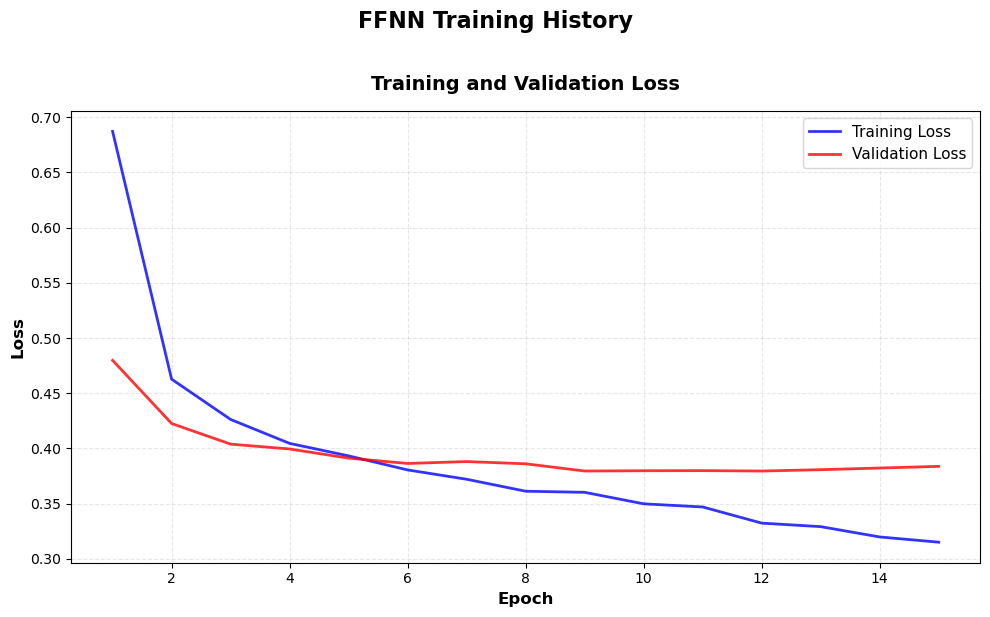

In [175]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


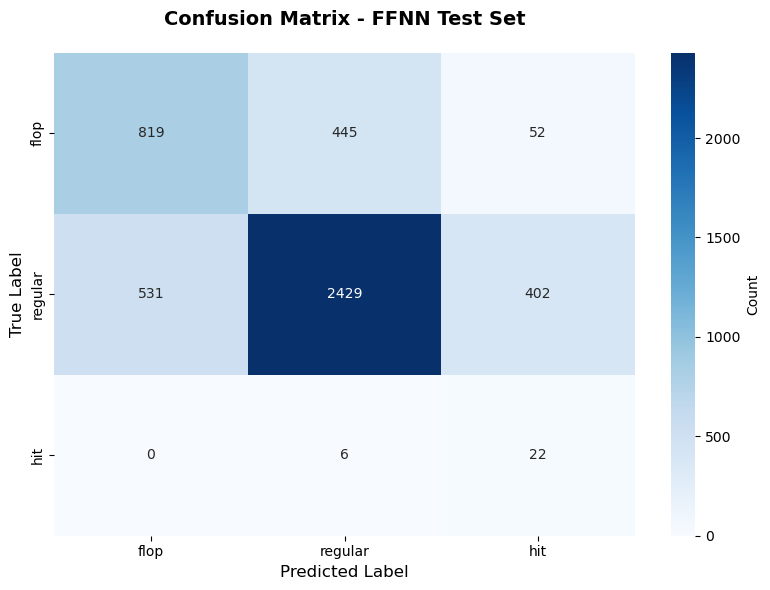

In [178]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

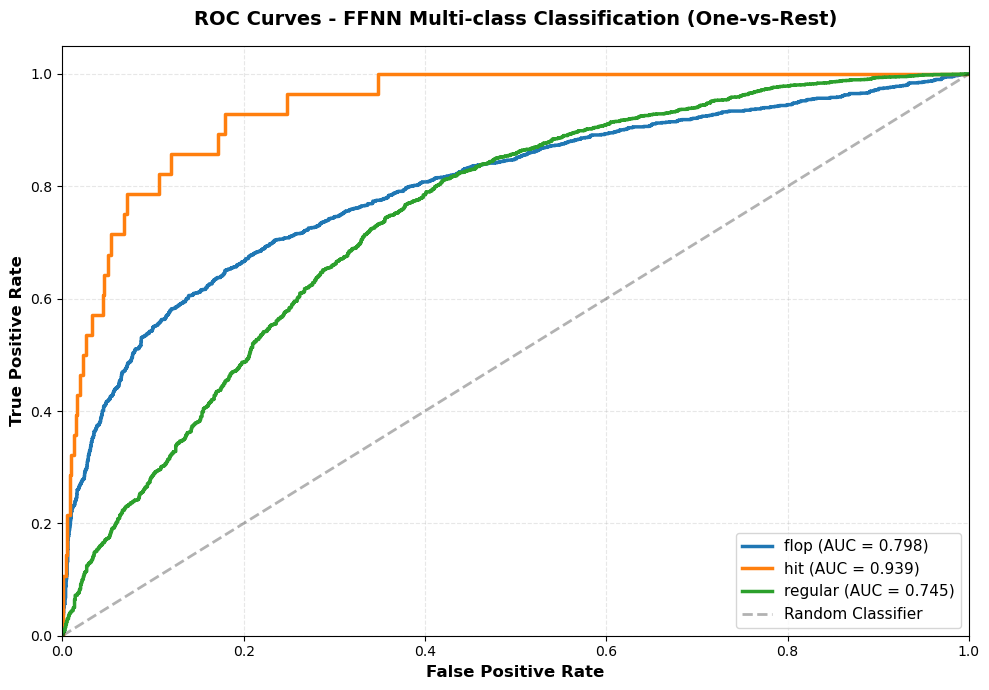

In [89]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Tab + Audio (Other Combinations)

In [90]:
# Load the text description embeddings
audio_emb = pd.read_parquet('audio_data/audio_embeddings_mert_330M.parquet')

In [121]:
# Update text_desc to the tabular data
train_tab_audio = pd.merge(train_tabular, audio_emb, on='track_id', how='left')
test_tab_audio = pd.merge(test_tabular, audio_emb, on='track_id', how='left')

In [122]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 1049)
Test set shape: (4706, 1049)

Features: 1045
Feature columns: ['artist_prev_pop', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'audio_emb_0', 'audio_emb_1', 'audio_emb_2', 'audio_emb_3', 'audio_emb_4', 'audio_emb_5', 'audio_emb_6', 'audio_emb_7', 'audio_emb_8', 'audio_emb_9', 'audio_emb_10', 'audio_emb_11', 'audio_emb_12', 'audio_emb_13', 'audio_emb_14', 'audio_emb_15', 'audio_emb_16', 'audio_emb_17', 'audio_emb_18', 'audio_emb_19', 'audio_emb_20', 'audio_emb_21', 'audio_emb_22', 'audio_emb_23', 'audio_emb_24', 'audio_emb_25', 'audio_emb_26', 'audio_emb_27', 'audio_emb_28', 'audio_emb_29', 'audio_emb_30', 'audio_emb_31', 'audio_emb_32', 'audio_emb_33', 'audio_emb_34', 'audio_emb_35', 'audio_emb_36', 'audio_emb_37', 'audio_emb_38', 'audio_emb_39', 'audio_emb_40', 'audio_emb_41', 'audio_emb_42', 'audio_emb

#### FFNN

In [123]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [124]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=512,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001]
  Total combinations: 3

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [125]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1229       0.4954        1.0137  0.6959
      2        1.0273       0.5409        0.9588  0.5926
      3        0.9789       0.5545        0.9222  0.5625
      4        0.9409       0.5689        0.8946  0.5387
      5        0.9149       0.5772        0.8734  0.5372
      6        0.8884       0.5940        0.8514  0.5378
      7        0.8612       0.6044        0.8351  0.5254
      8        0.8459       0.6104        0.8187  0.5360
      9        0.8230       0.6236        0.8026  0.5675
     10        0.8067       0.6295        0.7903  0.5340
     11        0.7875       0.6375        0.7726  0.5363
     12        0.7702       0.6447        0.7620  0.5163
     13        0.7571       0.6495        0.7505  0.5041
     14        0.7434 

In [126]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_3.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_3.pkl")

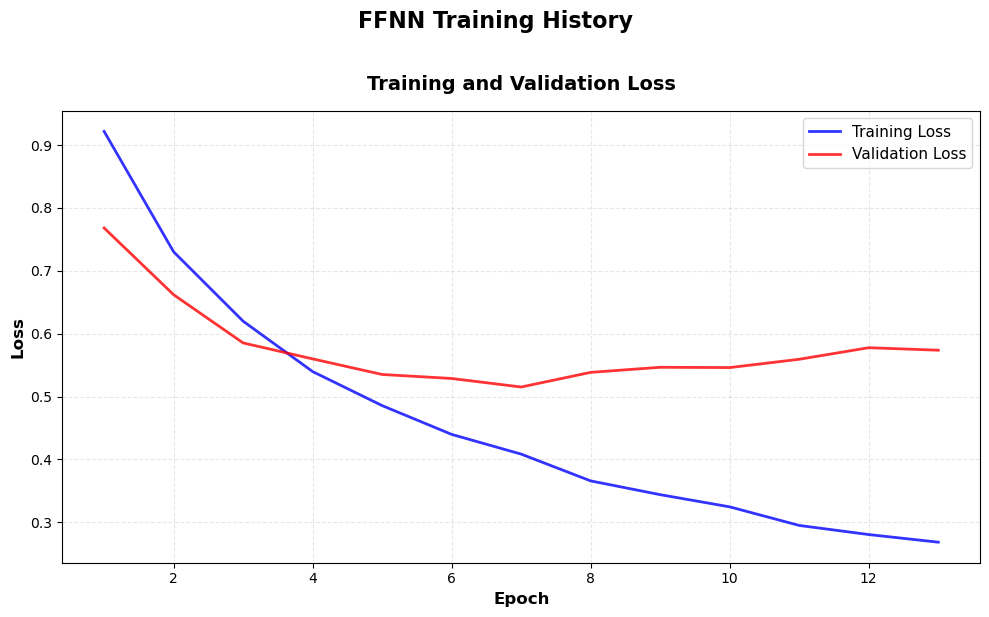

In [127]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


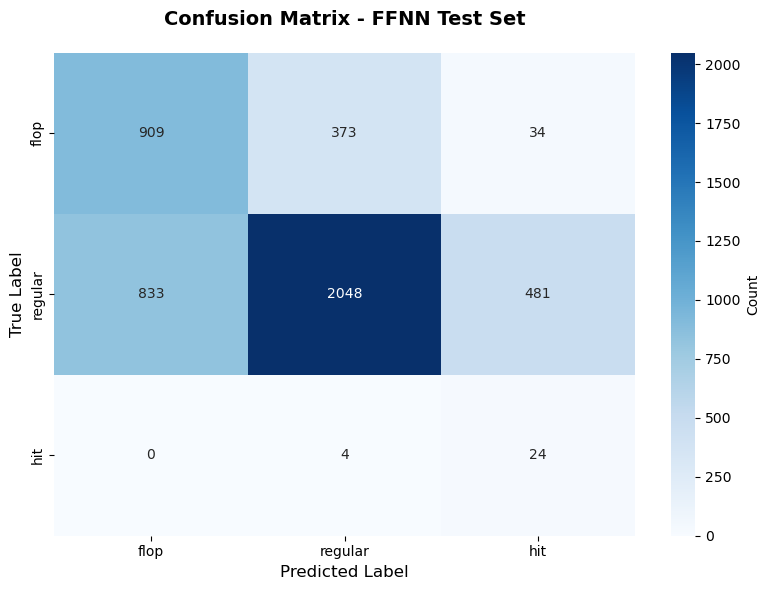

In [128]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

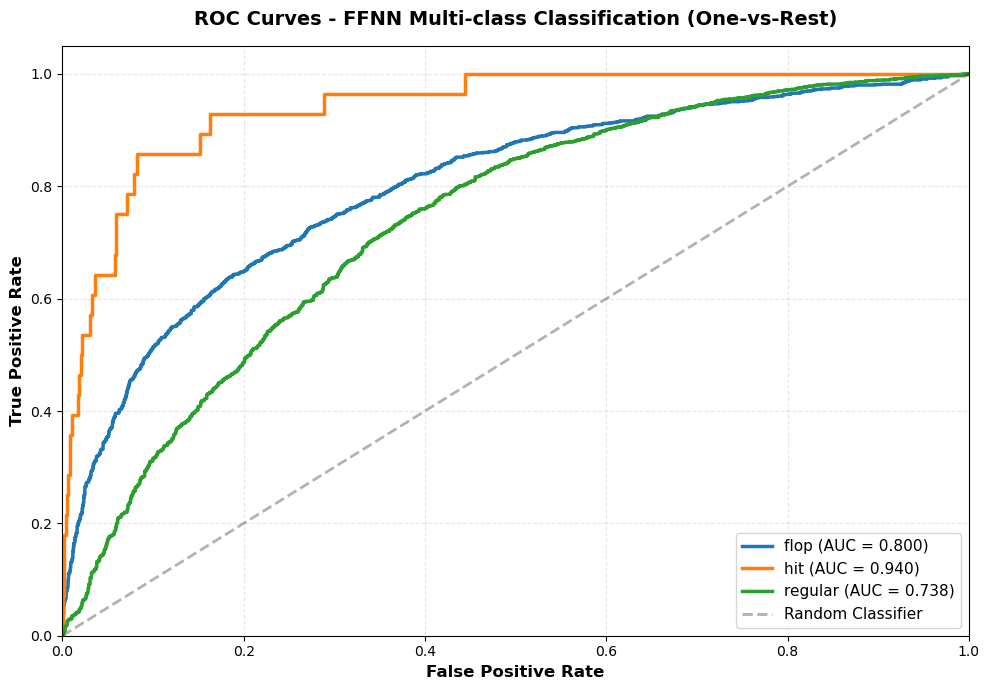

In [129]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



## Removing artist_prev_pop


### Tabular Data

In [196]:
# Load the train and test data (all modes)
spotify_train_all_modes = pd.read_csv('spotify_data/spotify_train_all_modes.csv')
spotify_test_all_modes = pd.read_csv('spotify_data/spotify_test_all_modes.csv')


In [197]:
# Extract the tabular data
# Don't include the crazy good variable, artist_prev_pop
tabular_columns  = ['track_id', 'artist_name', 'track_name', 'artist_tier', 
                    'year', 'danceability', 'energy', 'key', 
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'pop']

train_tabular = spotify_train_all_modes[tabular_columns]
test_tabular = spotify_test_all_modes[tabular_columns]

In [5]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_tabular_processed = pd.get_dummies(train_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_tabular_processed = pd.get_dummies(test_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_tabular_processed = test_tabular_processed[train_tabular_processed.columns]

print(f"Training set shape: {train_tabular_processed.shape}")
print(f"Test set shape: {test_tabular_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_tabular_processed.columns if col not in exclude_cols]

X_train = train_tabular_processed[feature_cols]
y_train = train_tabular_processed['pop']
X_test = test_tabular_processed[feature_cols]
y_test = test_tabular_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 24)
Test set shape: (4706, 24)

Features: 20
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'artist_tier_A', 'artist_tier_B', 'artist_tier_C', 'artist_tier_F', 'artist_tier_S', 'artist_tier_U']

Standardizing Features
✓ Features standardized


#### FFNN (Feed Forward Neural Network)

In [7]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [8]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [9]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1489       0.4383        1.0405  0.7486
      2        1.0803       0.5126        0.9895  0.4500
      3        1.0300       0.5309        0.9574  0.4943
      4        1.0021       0.5417        0.9349  0.4626
      5        0.9781       0.5489        0.9245  0.4590
      6        0.9651       0.5513        0.9142  0.4748
      7        0.9520       0.5629        0.9046  0.4654
      8        0.9497       0.5701        0.8971  0.4531
      9        0.9414       0.5745        0.8884  0.4549
     10        0.9319       0.5756        0.8845  0.4424
     11        0.9293       0.5780        0.8832  0.4622
     12        0.9203       0.5721        0.8833  0.4545
     13        0.9260       0.5788        0.8784  0.4495
     14        0.9165 

In [10]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_new.pkl")

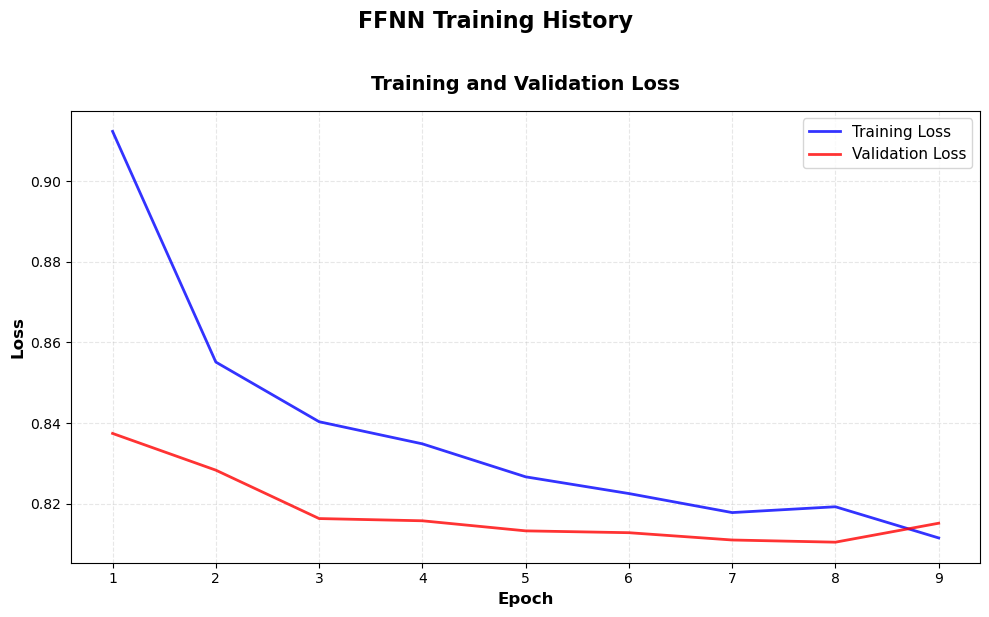

In [11]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


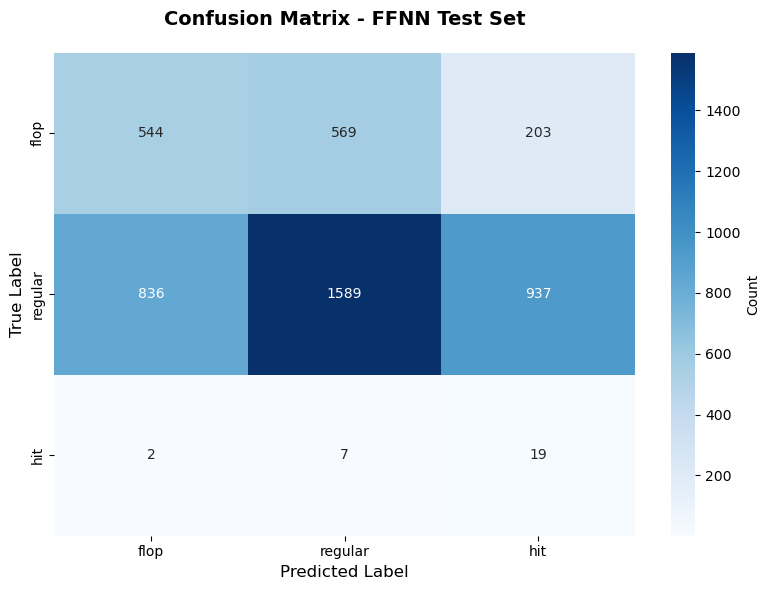

In [12]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

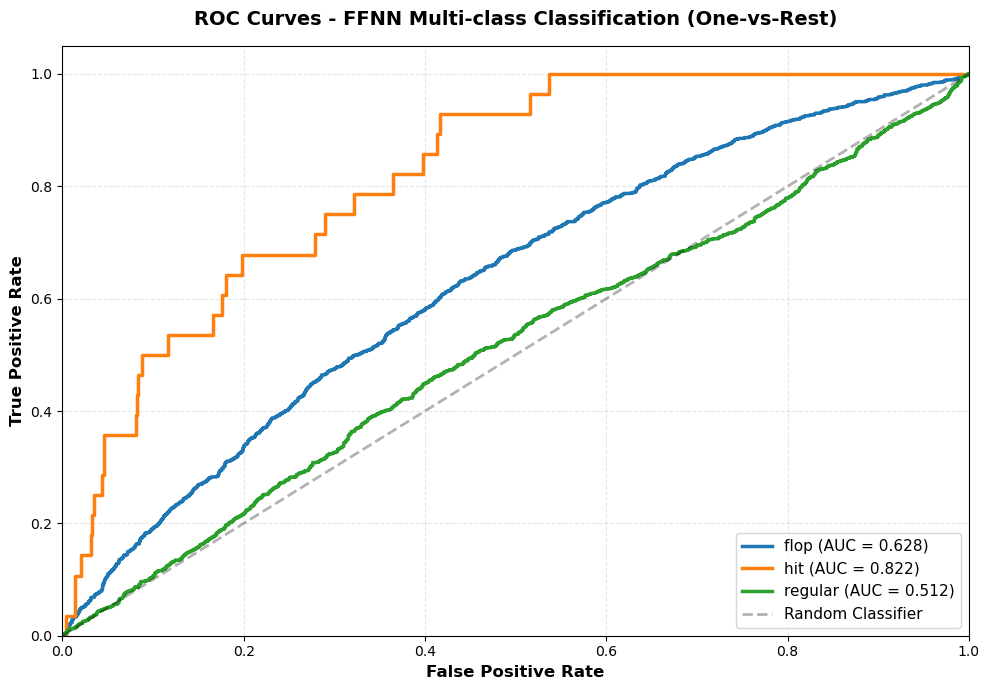

In [13]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Text Description Data
Concatenate the embedding of test description of each song and tune a XGB to see if bimodal inputs improves the performance

Due to conputational constraints, we only compare with the baseline model (the best grid of XGBoost)

In [198]:
# Load the text description embeddings
text_description_emb = pd.read_csv('text_description_data/text_description_embeddings_20k_no_artist_prev_pop.csv')

In [199]:
# Update text_desc to the tabular data
train_tab_text = pd.merge(train_tabular, text_description_emb, on='track_id', how='left')
test_tab_text = pd.merge(test_tabular, text_description_emb, on='track_id', how='left')

In [16]:
# Preprocess train and test data
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 792)
Test set shape: (4706, 792)

Features: 788
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35', 'text_desc_emb_36',

#### FFNN

We also try to see if FFNN gives us comapriable results

In [18]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [19]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0, 0.0001],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [20]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0177       0.6643        0.8598  0.4933
      2        0.8335       0.6886        0.7649  0.4305
      3        0.7694       0.6970        0.7234  0.4741
      4        0.7286       0.7006        0.7006  0.4777
      5        0.7091       0.6990        0.6816  0.4660
      6        0.6994       0.7038        0.6720  0.4614
      7        0.6850       0.7046        0.6655  0.4684
      8        0.6756       0.7094        0.6591  0.4723
      9        0.6675       0.7106        0.6548  0.4648
     10        0.6572       0.7110        0.6506  0.4759
     11        0.6568       0.7146        0.6470  0.4728
     12        0.6510       0.7126        0.6457  0.4767
     13        0.6456       0.7142        0.6411  0.4780
     14        0.6473 

In [21]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_new.pkl")


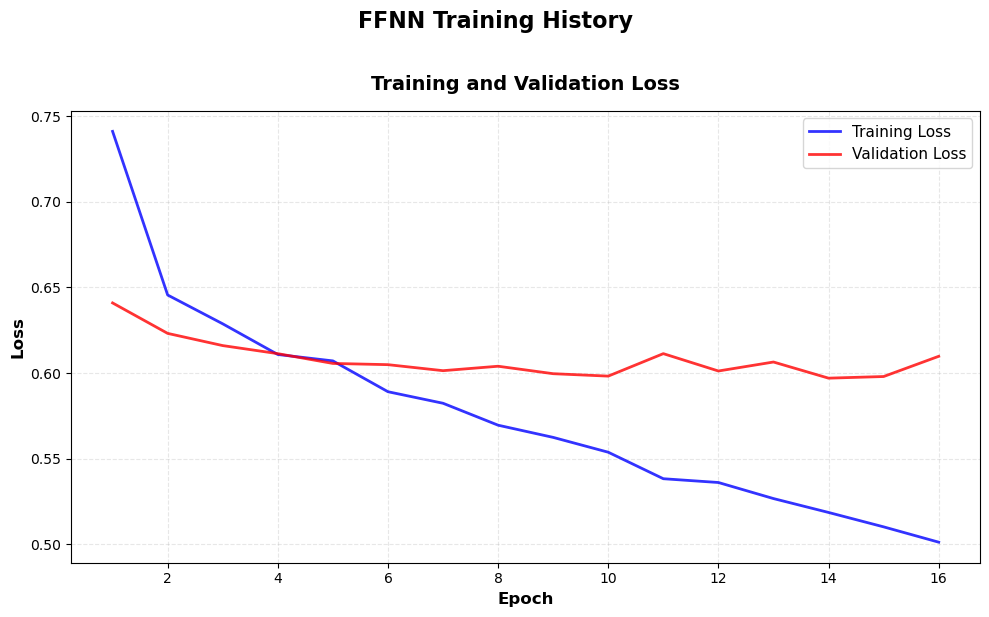

In [22]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


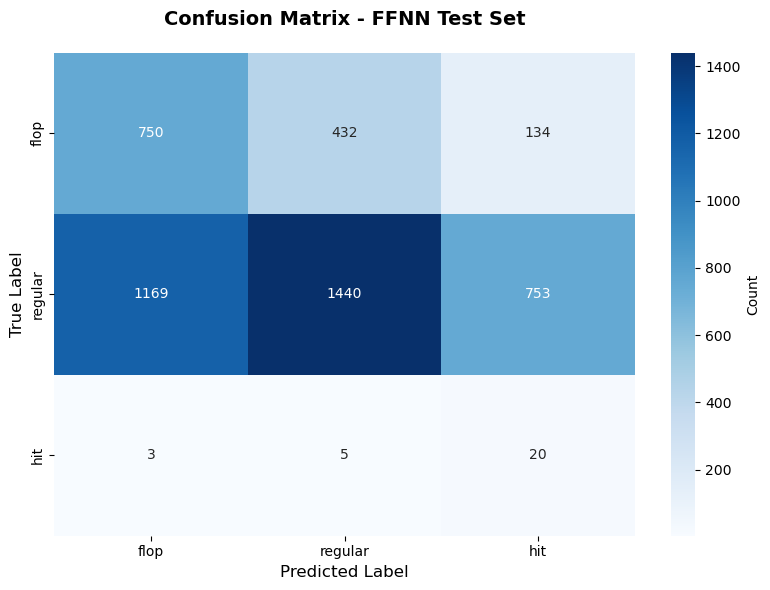

In [23]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

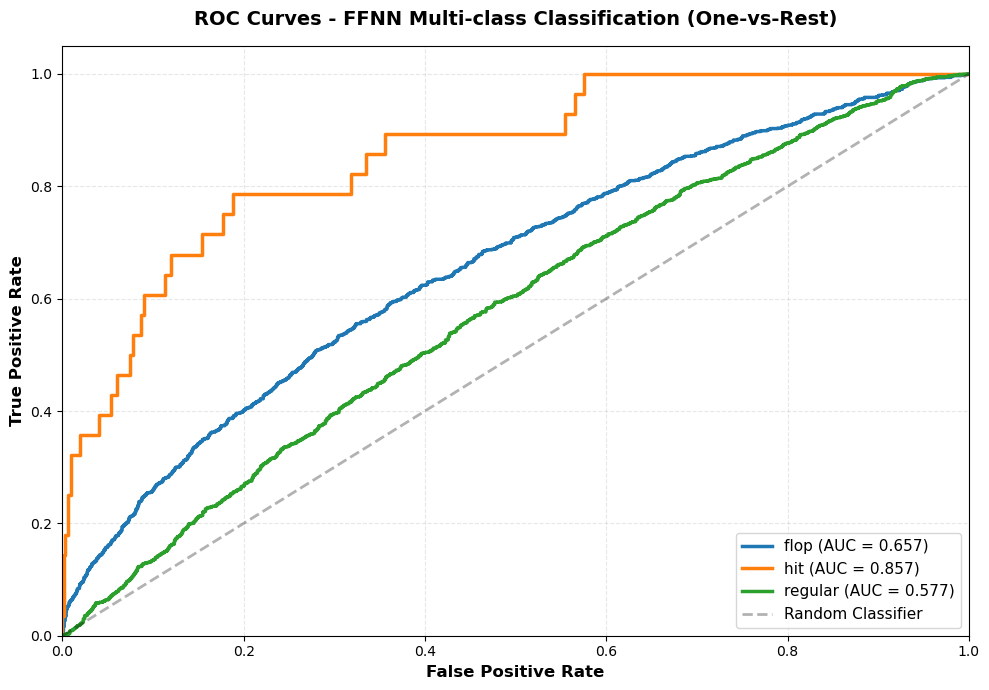

In [24]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Audio Data
Concatenate the embedding of audio of each song and tune a XGB to see if trimodal inputs improves the performance

In [200]:
# Load the text description embeddings
audio_emb = pd.read_parquet('audio_data/audio_embeddings_mert_330M.parquet')

In [201]:
# Update text_desc to the tabular data
train_tab_text_audio = pd.merge(train_tab_text, audio_emb, on='track_id', how='left')
test_tab_text_audio = pd.merge(test_tab_text, audio_emb, on='track_id', how='left')

In [27]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 1816)
Test set shape: (4706, 1816)

Features: 1812
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35', 'text_desc_emb_3

#### FFNN

In [28]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [29]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [30]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9981       0.6639        0.8400  0.5899
      2        0.8286       0.6898        0.7537  0.5437
      3        0.7582       0.6970        0.7084  0.5434
      4        0.7172       0.6986        0.6806  0.5412
      5        0.6956       0.7106        0.6652  0.5343
      6        0.6757       0.7102        0.6578  0.5310
      7        0.6628       0.7174        0.6462  0.5285
      8        0.6523       0.7206        0.6397  0.5697
      9        0.6428       0.7210        0.6335  0.5703
     10        0.6331       0.7238        0.6335  0.5445
     11        0.6272       0.7265        0.6235  0.5438
     12        0.6153       0.7277        0.6207  0.5411
     13        0.6140       0.7325        0.6164  0.5515
     14        0.6044 

In [31]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3_new.pkl")

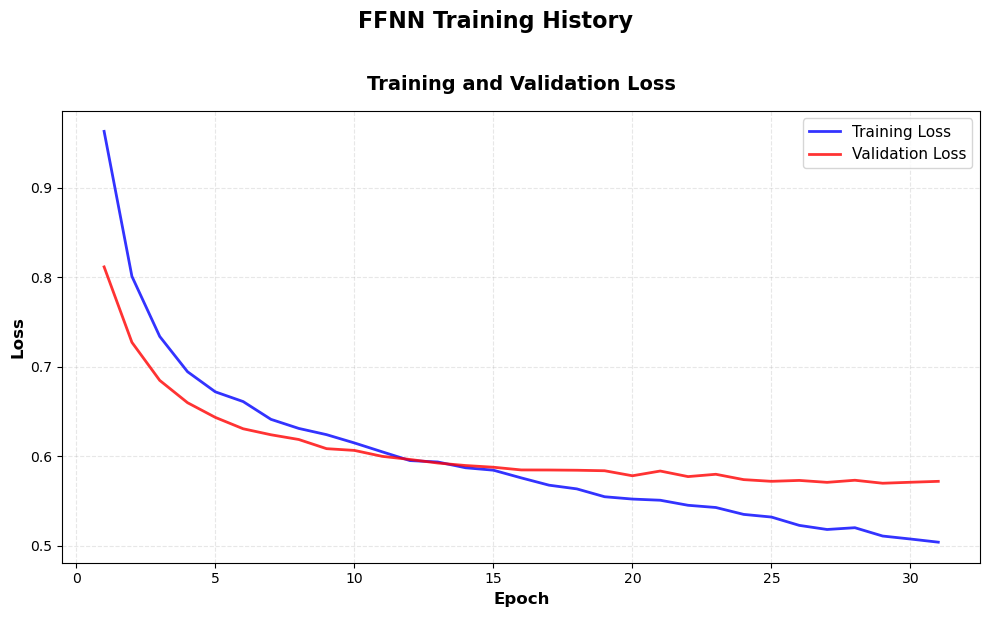

In [32]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


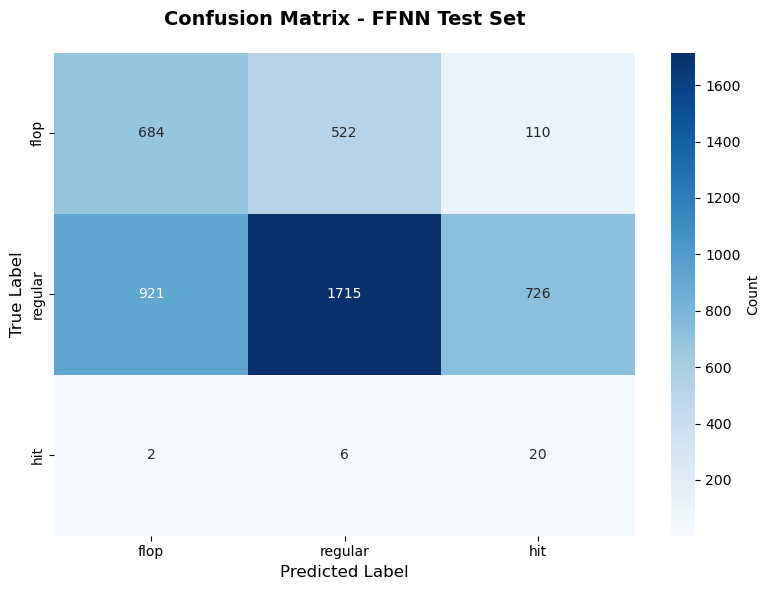

In [33]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

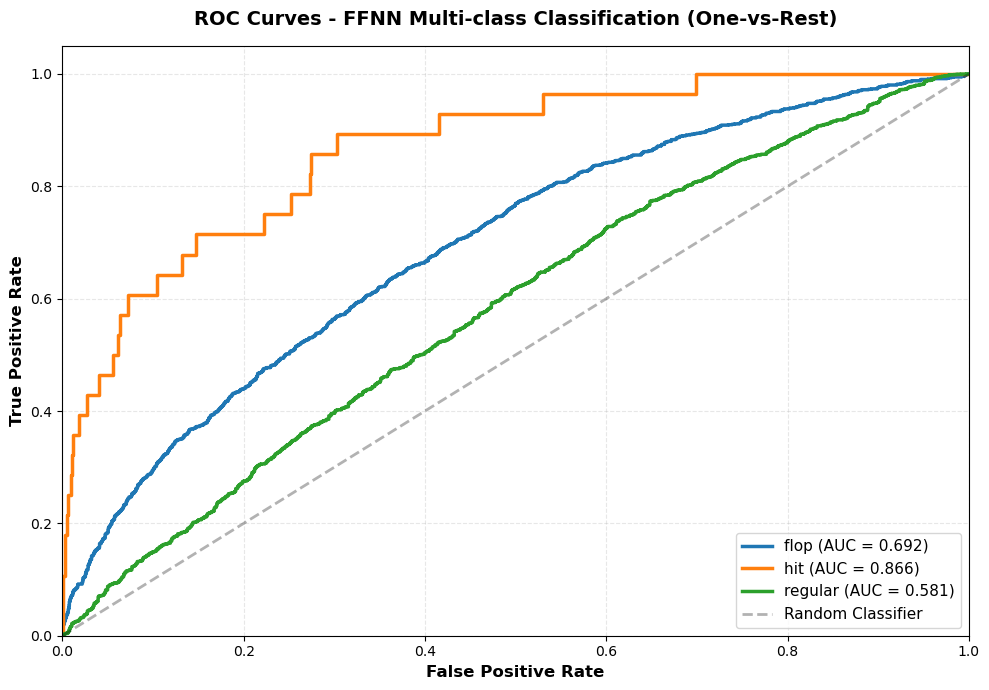

In [34]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Lyrics Data
Concatenate the embedding of lyrics of each song and tune a XGB to see if 4-modal inputs improves the performance

In [208]:
# Load the text description embeddings
lyrics_emb = pd.read_csv('lyrics_data/lyrics_embeddings_20k.csv')

In [209]:
# Update text_desc to the tabular data
train_tab_text_audio_lyrics = pd.merge(train_tab_text_audio, lyrics_emb, on='track_id', how='left')
test_tab_text_audio_lyrics = pd.merge(test_tab_text_audio, lyrics_emb, on='track_id', how='left')

In [210]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 2584)
Test set shape: (4706, 2584)

Features: 2580
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35', 'text_desc_emb_3

#### FFNN

In [211]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [212]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [213]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9125       0.6942        0.7486  0.6294
      2        0.7352       0.7146        0.6739  0.5587
      3        0.6811       0.7261        0.6383  0.5213
      4        0.6478       0.7325        0.6179  0.5473
      5        0.6254       0.7369        0.6030  0.5607
      6        0.6039       0.7441        0.5918  0.6032
      7        0.5979       0.7513        0.5814  0.5569
      8        0.5849       0.7549        0.5719  0.5467
      9        0.5755       0.7553        0.5674  0.5547
     10        0.5669       0.7569        0.5606  0.5624
     11        0.5540       0.7589        0.5567  0.5693
     12        0.5509       0.7605        0.5518  0.5405
     13        0.5396       0.7577        0.5499  0.5552
     14        0.5246 

In [214]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3_4_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3_4_new.pkl")

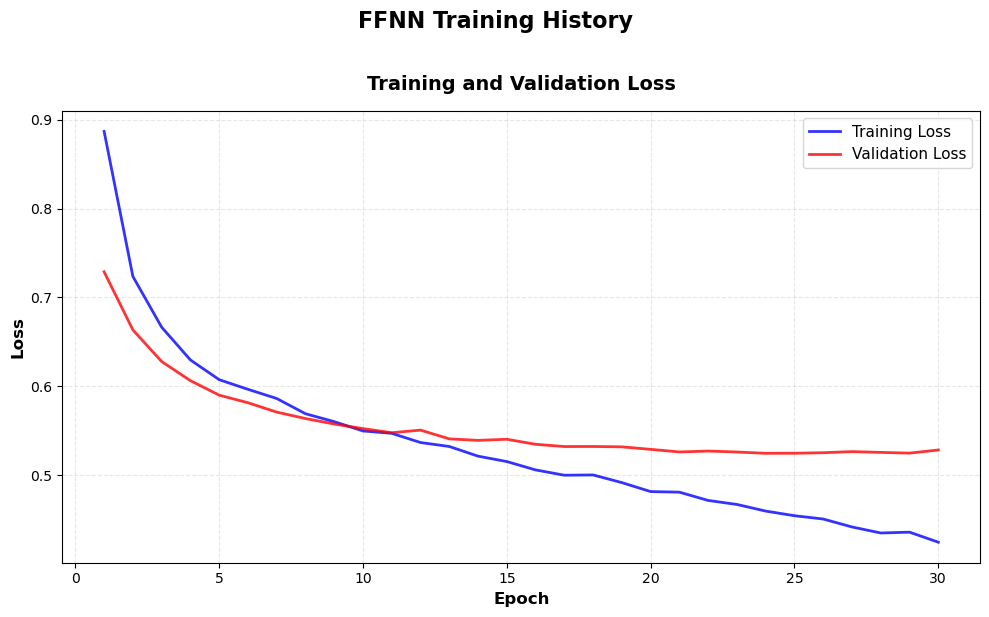

In [42]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


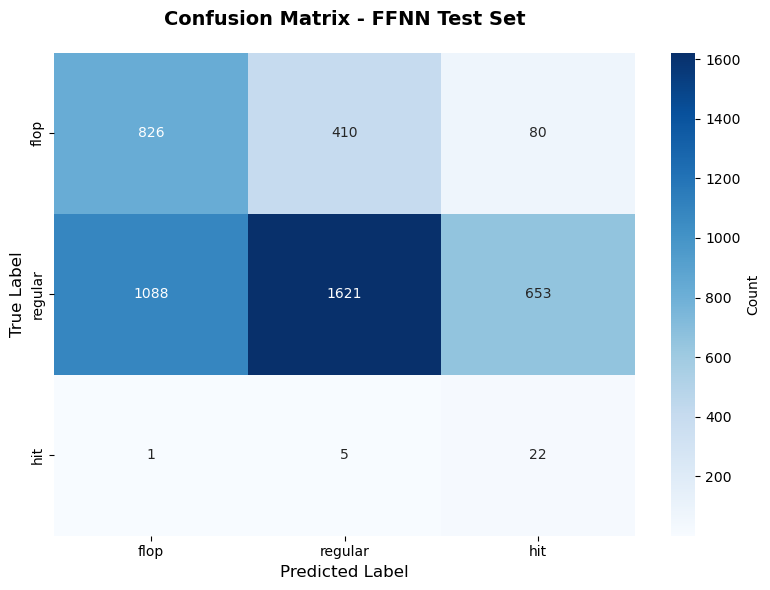

In [43]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

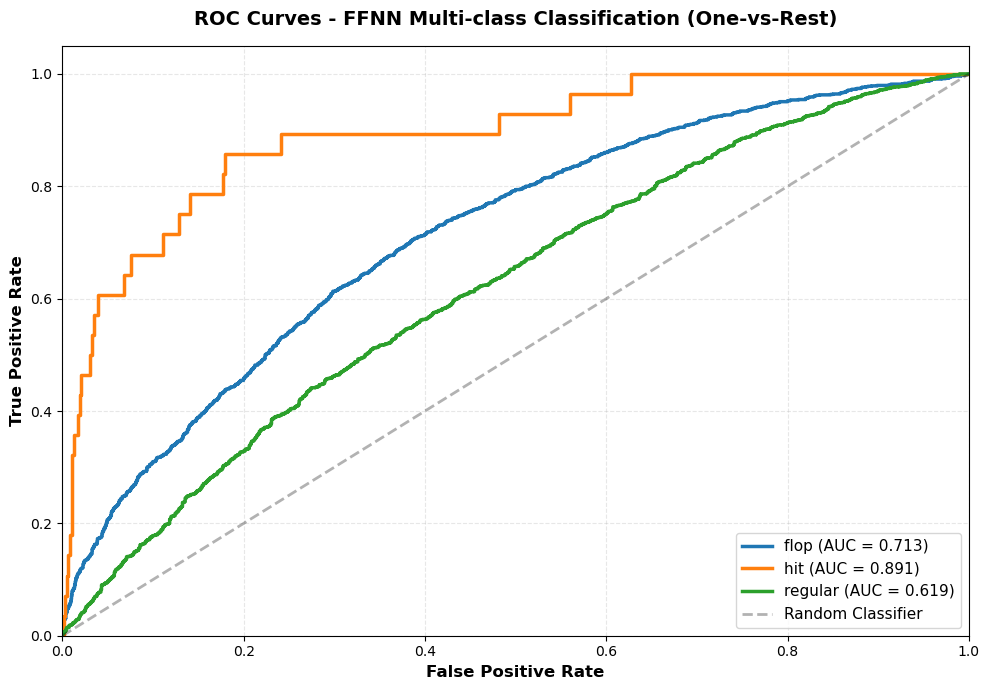

In [44]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Add Image Data
Concatenate the embedding of album cover of each song and tune a XGB to see if 5-modal inputs improves the performance

In [215]:
# Load the text description embeddings
image_emb = pd.read_csv('image_data/spotify_album_cover_embeddings.csv')

image_emb = image_emb.drop(columns=['artist_name', 'track_name', 'album_cover_path'], axis=1)

In [216]:
# Update text_desc to the tabular data
train_tab_text_audio_lyrics_image = pd.merge(train_tab_text_audio_lyrics, image_emb, on='track_id', how='left')
test_tab_text_audio_lyrics_image = pd.merge(test_tab_text_audio_lyrics, image_emb, on='track_id', how='left')

In [217]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 3096)
Test set shape: (4706, 3096)

Features: 3092
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'text_desc_emb_1', 'text_desc_emb_2', 'text_desc_emb_3', 'text_desc_emb_4', 'text_desc_emb_5', 'text_desc_emb_6', 'text_desc_emb_7', 'text_desc_emb_8', 'text_desc_emb_9', 'text_desc_emb_10', 'text_desc_emb_11', 'text_desc_emb_12', 'text_desc_emb_13', 'text_desc_emb_14', 'text_desc_emb_15', 'text_desc_emb_16', 'text_desc_emb_17', 'text_desc_emb_18', 'text_desc_emb_19', 'text_desc_emb_20', 'text_desc_emb_21', 'text_desc_emb_22', 'text_desc_emb_23', 'text_desc_emb_24', 'text_desc_emb_25', 'text_desc_emb_26', 'text_desc_emb_27', 'text_desc_emb_28', 'text_desc_emb_29', 'text_desc_emb_30', 'text_desc_emb_31', 'text_desc_emb_32', 'text_desc_emb_33', 'text_desc_emb_34', 'text_desc_emb_35', 'text_desc_emb_3

#### FFNN

In [218]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [219]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [220]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9395       0.6750        0.7839  0.8619
      2        0.7737       0.7090        0.7029  0.7225
      3        0.6995       0.7230        0.6573  0.5793
      4        0.6540       0.7277        0.6291  0.5694
      5        0.6322       0.7337        0.6112  0.5856
      6        0.6119       0.7489        0.5974  0.5749
      7        0.6011       0.7465        0.5851  0.5918
      8        0.5824       0.7513        0.5765  0.5866
      9        0.5737       0.7581        0.5687  0.5776
     10        0.5634       0.7581        0.5620  0.5962
     11        0.5466       0.7601        0.5575  0.5757
     12        0.5384       0.7609        0.5528  0.5660
     13        0.5303       0.7621        0.5481  0.5727
     14        0.5155 

In [221]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_2_3_4_5_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_2_3_4_5_new.pkl")

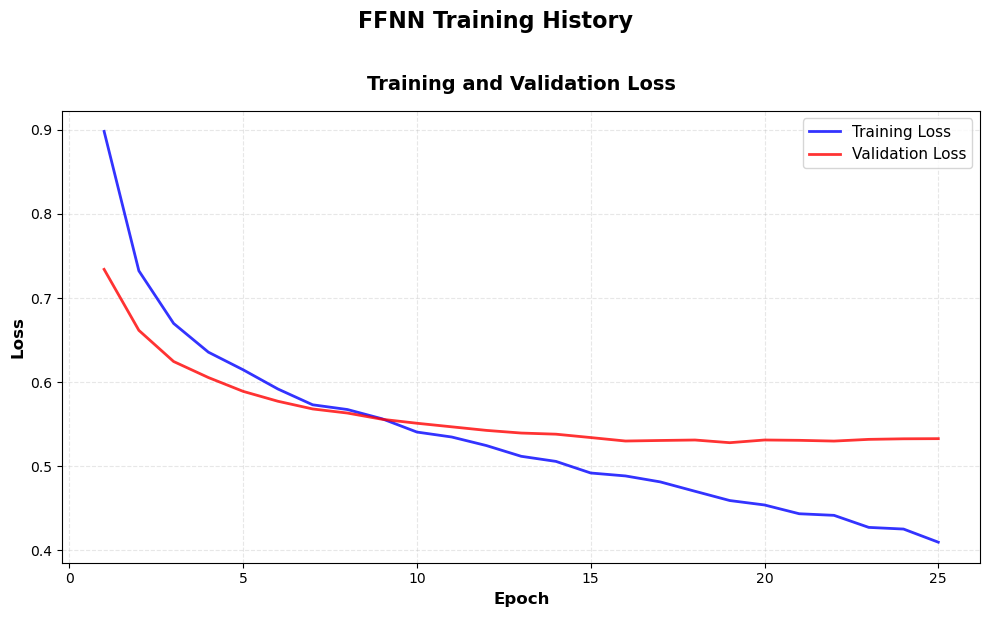

In [59]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


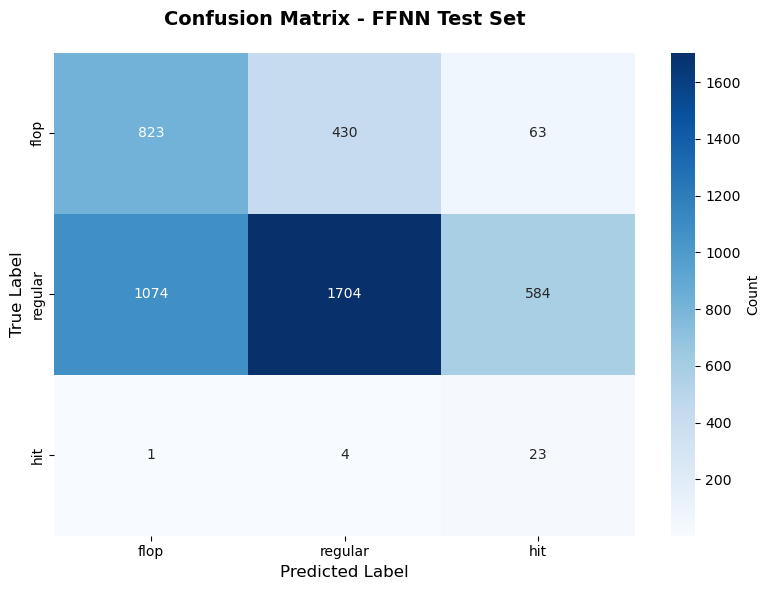

In [60]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

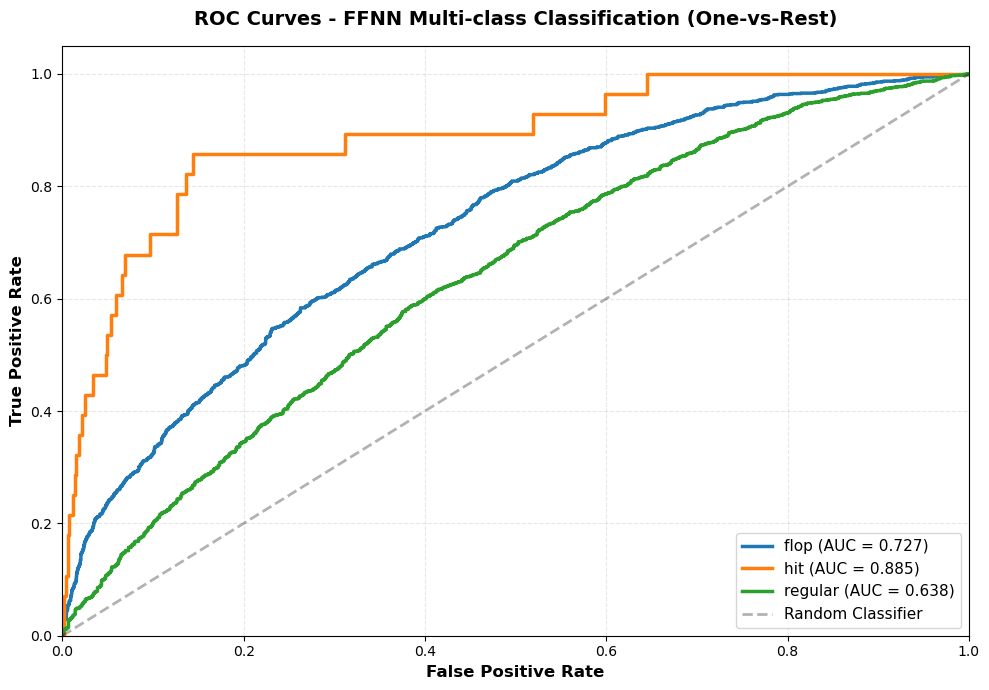

In [61]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



### Tab + Audio (Other Combinations)

In [62]:
# Load the text description embeddings
audio_emb = pd.read_parquet('audio_data/audio_embeddings_mert_330M.parquet')

In [63]:
# Update text_desc to the tabular data
train_tab_audio = pd.merge(train_tabular, audio_emb, on='track_id', how='left')
test_tab_audio = pd.merge(test_tabular, audio_emb, on='track_id', how='left')

In [64]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# One-hot encode artist_tier for train and test sets
train_processed = pd.get_dummies(train_tab_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_processed = pd.get_dummies(test_tab_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)

# Ensure same column order
test_processed = test_processed[train_processed.columns]

print(f"Training set shape: {train_processed.shape}")
print(f"Test set shape: {test_processed.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

X_train = train_processed[feature_cols]
y_train = train_processed['pop']
X_test = test_processed[feature_cols]
y_test = test_processed['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 1048)
Test set shape: (4706, 1048)

Features: 1044
Feature columns: ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'audio_emb_0', 'audio_emb_1', 'audio_emb_2', 'audio_emb_3', 'audio_emb_4', 'audio_emb_5', 'audio_emb_6', 'audio_emb_7', 'audio_emb_8', 'audio_emb_9', 'audio_emb_10', 'audio_emb_11', 'audio_emb_12', 'audio_emb_13', 'audio_emb_14', 'audio_emb_15', 'audio_emb_16', 'audio_emb_17', 'audio_emb_18', 'audio_emb_19', 'audio_emb_20', 'audio_emb_21', 'audio_emb_22', 'audio_emb_23', 'audio_emb_24', 'audio_emb_25', 'audio_emb_26', 'audio_emb_27', 'audio_emb_28', 'audio_emb_29', 'audio_emb_30', 'audio_emb_31', 'audio_emb_32', 'audio_emb_33', 'audio_emb_34', 'audio_emb_35', 'audio_emb_36', 'audio_emb_37', 'audio_emb_38', 'audio_emb_39', 'audio_emb_40', 'audio_emb_41', 'audio_emb_42', 'audio_emb_43', 'audio_emb_44

#### FFNN

In [65]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.2):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [66]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [67]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1402       0.4295        1.0610  0.5509
      2        1.0877       0.4858        1.0199  0.4814
      3        1.0418       0.5198        0.9898  0.4757
      4        1.0143       0.5333        0.9645  0.4665
      5        0.9863       0.5453        0.9468  0.4843
      6        0.9702       0.5461        0.9318  0.4781
      7        0.9535       0.5601        0.9190  0.4881
      8        0.9333       0.5697        0.9054  0.5112
      9        0.9230       0.5705        0.8955  0.4826
     10        0.9157       0.5725        0.8864  0.5198
     11        0.8987       0.5737        0.8781  0.4650
     12        0.8911       0.5824        0.8711  0.5356
     13        0.8776       0.5812        0.8642  0.5285
     14        0.8740 

In [68]:
import joblib

# Save the grid_search
joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_1_3_new.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_1_3_new.pkl")

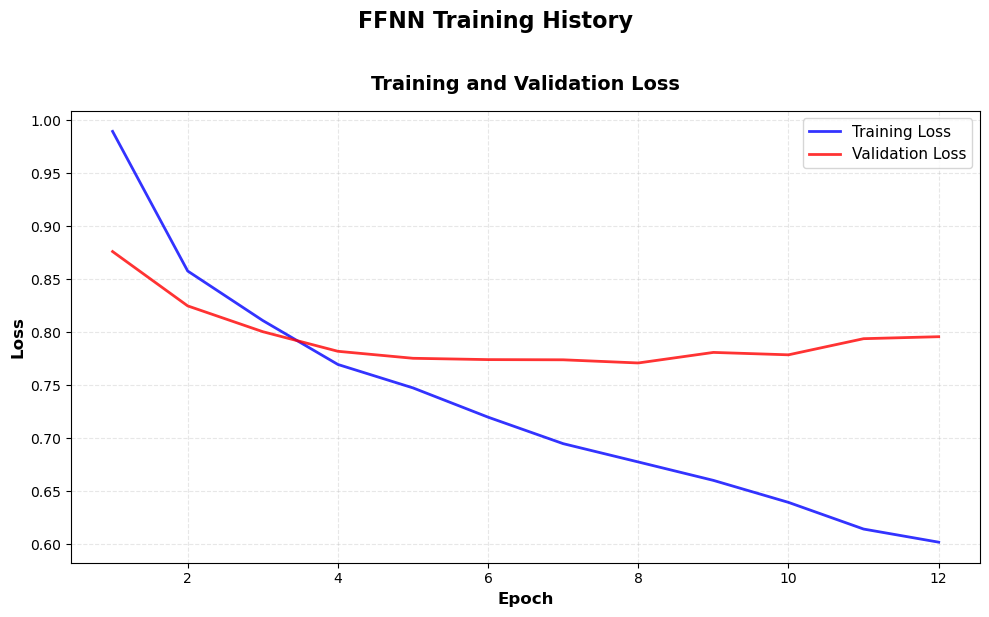

In [69]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


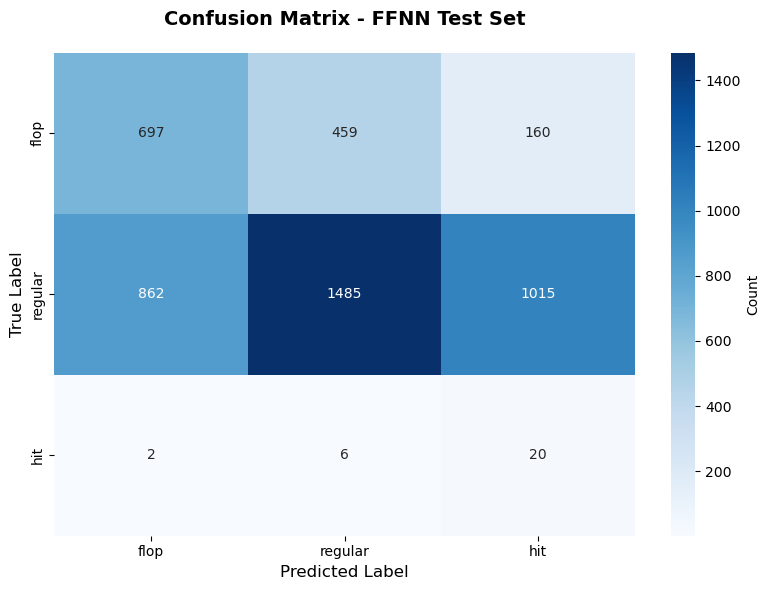

In [70]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

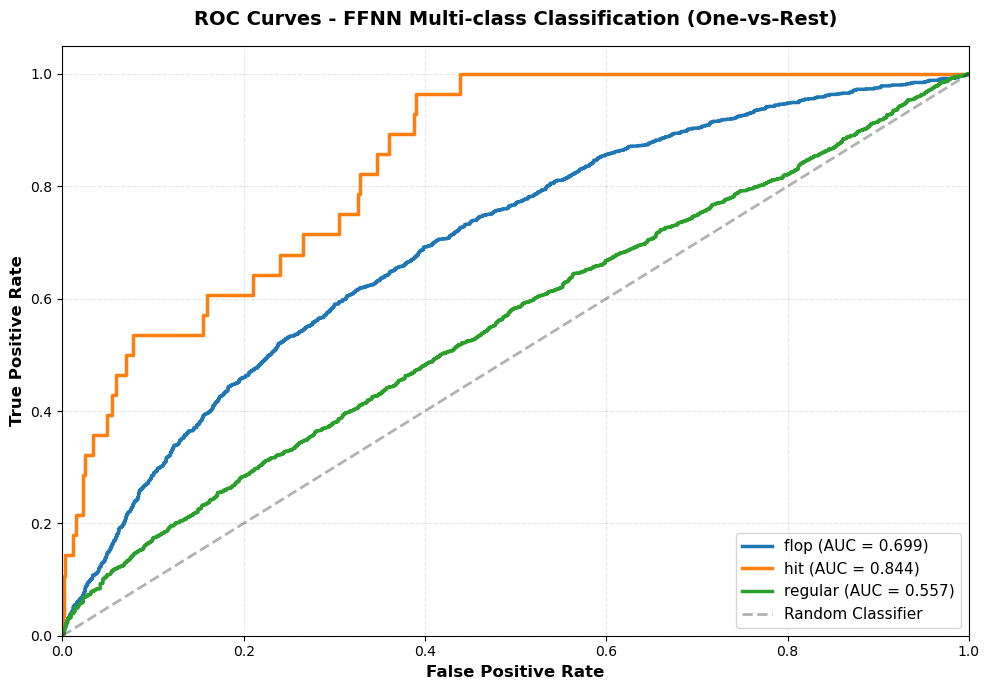

In [71]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



## Only artist_prev_pop

In [92]:
# Load the train and test data (all modes)
spotify_train_all_modes = pd.read_csv('spotify_data/spotify_train_all_modes.csv')
spotify_test_all_modes = pd.read_csv('spotify_data/spotify_test_all_modes.csv')

In [96]:
# Extract the tabular data
tabular_columns  = ['artist_prev_pop', 'pop']

train_tabular = spotify_train_all_modes[tabular_columns]
test_tabular = spotify_test_all_modes[tabular_columns]

In [115]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 1: Prepare the data - one-hot encode artist_tier before modeling
print("="*60)
print("Data Preprocessing")
print("="*60)

# Ensure same column order
test_tabular = test_tabular[train_tabular.columns]

print(f"Training set shape: {train_tabular.shape}")
print(f"Test set shape: {test_tabular.shape}")


# Step 2: Define features and target
# Exclude non-feature columns
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']
feature_cols = [col for col in train_tabular.columns if col not in exclude_cols]

X_train = train_tabular[feature_cols]
y_train = train_tabular['pop']
X_test = test_tabular[feature_cols]
y_test = test_tabular['pop']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


# Step 3: Standardize features
print("\n" + "="*60)
print("Standardizing Features")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")

Data Preprocessing
Training set shape: (15652, 2)
Test set shape: (4706, 2)

Features: 1
Feature columns: ['artist_prev_pop']

Standardizing Features
✓ Features standardized


### FFNN

In [116]:
### Feed-Forward Neural Network (FFNN) with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint
from sklearn.metrics import roc_auc_score

print("="*60)
print("PyTorch FFNN Model Setup")
print("="*60)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

# Define the FFNN architecture
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3, dropout_rate=0.3):
        super(FFNNClassifier, self).__init__()
        
        # 3 hidden layers with 256 neurons each
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output = nn.Linear(hidden_dim, num_classes)
        
        # Activation functions (easily changeable)
        self.relu = nn.ReLU()  # Change to nn.LeakyReLU() or nn.Tanh() if needed
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        # Note: Softmax is handled by loss function (CrossEntropyLoss includes it)
        
        return x

# Calculate class weights for handling imbalance
class_counts_nn = y_train.value_counts().sort_index()
class_weights_nn = torch.tensor([1.0 / count for count in class_counts_nn.values], dtype=torch.float32).to(device)



PyTorch FFNN Model Setup

Device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA Version: 11.8


In [124]:
# Set up skorch wrapper for sklearn compatibility
print("\n" + "="*60)
print("Setting up Neural Network with sklearn Integration")
print("="*60)

# Convert target labels to numeric for PyTorch
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=6,
    threshold=0.01,
    threshold_mode='rel',
    lower_is_better=True
)

# Create the skorch neural network classifier
ffnn_model = NeuralNetClassifier(
    module=FFNNClassifier,
    module__input_dim=len(feature_cols),
    module__hidden_dim=256,
    module__num_classes=3,
    module__dropout_rate=0.3,
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights_nn,  # Class weights for imbalance
    optimizer=optim.Adam,
    optimizer__weight_decay=0,  # L2 regularization
    lr=0.001,  # Learning rate
    batch_size=64,
    max_epochs=50,
    callbacks=[early_stopping],
    device=device,
    iterator_train__shuffle=True,
    verbose=1
)

# Set up hyperparameter grid (single configuration for now)
param_grid_ffnn = {
    'lr': [0.00001, 0.0001, 0.001, 0.01],  # Can add more values like [0.0001, 0.001, 0.01] to tune
    # Add more hyperparameters here if you want to tune later:
    # 'module__hidden_dim': [128, 256, 512],
    # 'module__dropout_rate': [0.1, 0.2, 0.3],
    # 'optimizer__weight_decay': [0.0001, 0.001, 0.01],
    # 'batch_size': [32, 64, 128],
}

print(f"Hyperparameter grid:")
print(f"  lr: {param_grid_ffnn['lr']}")
print(f"  Total combinations: {len(param_grid_ffnn['lr'])}")
print(f"\n  (Add more hyperparameters to param_grid_ffnn for tuning)")

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc_ovr',
    'accuracy': 'accuracy'
}

grid_search_ffnn = GridSearchCV(
    estimator=ffnn_model,
    param_grid=param_grid_ffnn,
    cv=cv,
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,  # PyTorch handles parallelism internally
    verbose=2,
    return_train_score=True
)

print("\n✓ GridSearchCV configured")
print("  - 5-fold stratified cross-validation")
print("  - Scoring: ROC-AUC (OvR) and Accuracy")
print("  - Class imbalance: handled via weighted loss function")
print("  - Device: " + str(device))



Setting up Neural Network with sklearn Integration
Hyperparameter grid:
  lr: [1e-05, 0.0001, 0.001, 0.01]
  Total combinations: 4

  (Add more hyperparameters to param_grid_ffnn for tuning)

✓ GridSearchCV configured
  - 5-fold stratified cross-validation
  - Scoring: ROC-AUC (OvR) and Accuracy
  - Class imbalance: handled via weighted loss function
  - Device: cuda


In [126]:
# Fit the FFNN model
print("\nStarting training...")
print("(Neural network training in progress...)")
# Convert data to float32 for PyTorch and labels to int64 (long)
X_train_torch = X_train_scaled.astype(np.float32)
X_test_torch = X_test_scaled.astype(np.float32)
y_train_torch = y_train_encoded.astype(np.int64)  # PyTorch requires int64 for CrossEntropyLoss

grid_search_ffnn.fit(X_train_torch, y_train_torch)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Best parameters
print(f"\nBest parameters:")
for param, value in grid_search_ffnn.best_params_.items():
    print(f"  {param}: {value}")

# Best cross-validation scores
best_idx_ffnn = grid_search_ffnn.best_index_
print(f"\nBest cross-validation scores:")
print(f"  ROC-AUC (OvR): {grid_search_ffnn.cv_results_['mean_test_roc_auc'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_roc_auc'][best_idx_ffnn]:.4f})")
print(f"  Accuracy: {grid_search_ffnn.cv_results_['mean_test_accuracy'][best_idx_ffnn]:.4f} "
      f"(+/- {grid_search_ffnn.cv_results_['std_test_accuracy'][best_idx_ffnn]:.4f})")

# Test set performance
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)
y_test_proba_ffnn = grid_search_ffnn.best_estimator_.predict_proba(X_test_torch)

# Convert predictions back to original labels
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Calculate test metrics
test_accuracy_ffnn = accuracy_score(y_test, y_test_pred_ffnn_labels)
test_roc_auc_ffnn = roc_auc_score(y_test_encoded, y_test_proba_ffnn, multi_class='ovr')

print(f"\nTest set performance:")
print(f"  ROC-AUC (OvR): {test_roc_auc_ffnn:.4f}")
print(f"  Accuracy: {test_accuracy_ffnn:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_ffnn_labels))



Starting training...
(Neural network training in progress...)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8666       0.7717        0.6705  0.4531
      2        0.6518       0.7697        0.5833  0.3436
      3        0.5908       0.7709        0.5548  0.4404
      4        0.5697       0.7725        0.5366  0.4458
      5        0.5606       0.7705        0.5308  0.4686
      6        0.5526       0.7705        0.5228  0.4375
      7        0.5429       0.7717        0.5220  0.4453
      8        0.5357       0.7693        0.5194  0.4567
      9        0.5394       0.7729        0.5130  0.4473
     10        0.5345       0.7717        0.5113  0.4568
     11        0.5374       0.7709        0.5100  0.4687
     12        0.5342       0.7649        0.5126  0.4743
     13        0.5299       0.7709        0.5073  0.4709
     14        0.5276 

In [131]:
import joblib

# Save the grid_search
#joblib.dump(grid_search_ffnn, "models/grid_search_ffnn_secret.pkl")

# Load gris_search
grid_search_ffnn = joblib.load("models/grid_search_ffnn_secret.pkl")

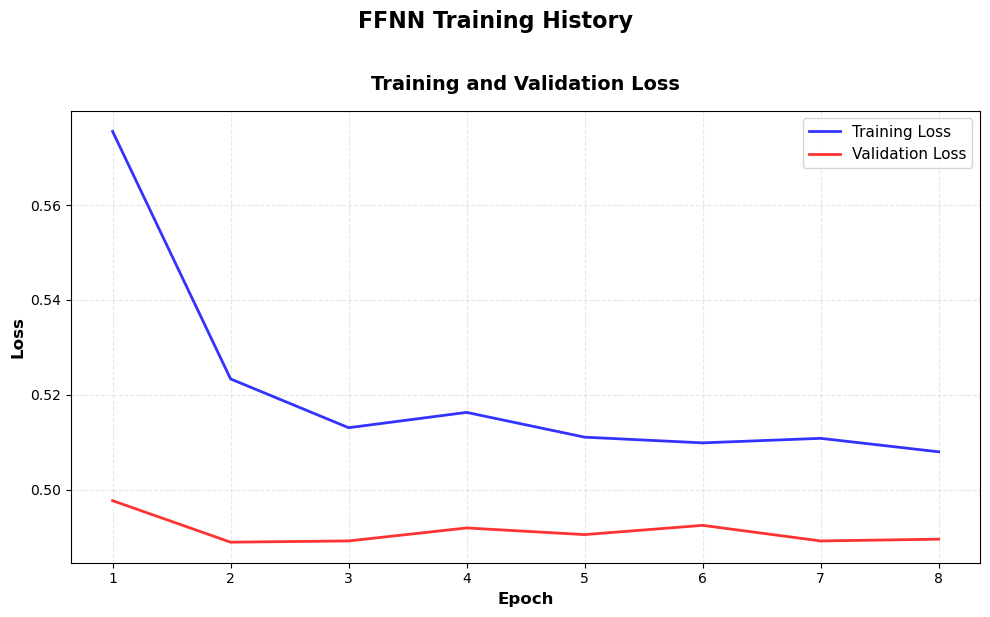

In [128]:
# Training History Visualization

# Extract training history from the best estimator
history = grid_search_ffnn.best_estimator_.history

# Extract training and validation metrics
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Check if accuracy is tracked in history
has_accuracy = 'train_acc' in history[0] if len(history) > 0 else False

if has_accuracy:
    train_acc = [h['train_acc'] for h in history]
    valid_acc = [h['valid_acc'] for h in history]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
else:
    # Only plot loss if accuracy is not available
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes = [axes]

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs, valid_loss, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Accuracy curves (only if available)
if has_accuracy:
    ax2 = axes[1]
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('FFNN Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


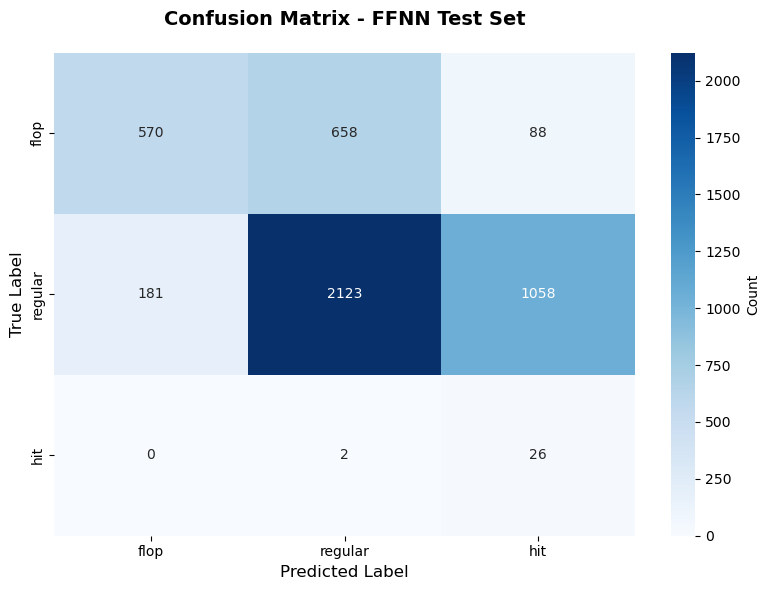

In [129]:
# FFNN Confusion Matrix on Test Set
from sklearn.metrics import confusion_matrix

# Convert test data to float32 for PyTorch
X_test_torch = X_test_scaled.astype(np.float32)

# Get predictions (these will be encoded: 0, 1, 2)
y_test_pred_ffnn = grid_search_ffnn.best_estimator_.predict(X_test_torch)

# Convert predictions back to original labels ('flop', 'regular', 'hit')
y_test_pred_ffnn_labels = label_encoder.inverse_transform(y_test_pred_ffnn)

# Create confusion matrix
cm_test_ffnn = confusion_matrix(y_test, y_test_pred_ffnn_labels, labels=['flop', 'regular', 'hit'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ffnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['flop', 'regular', 'hit'],
            yticklabels=['flop', 'regular', 'hit'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - FFNN Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

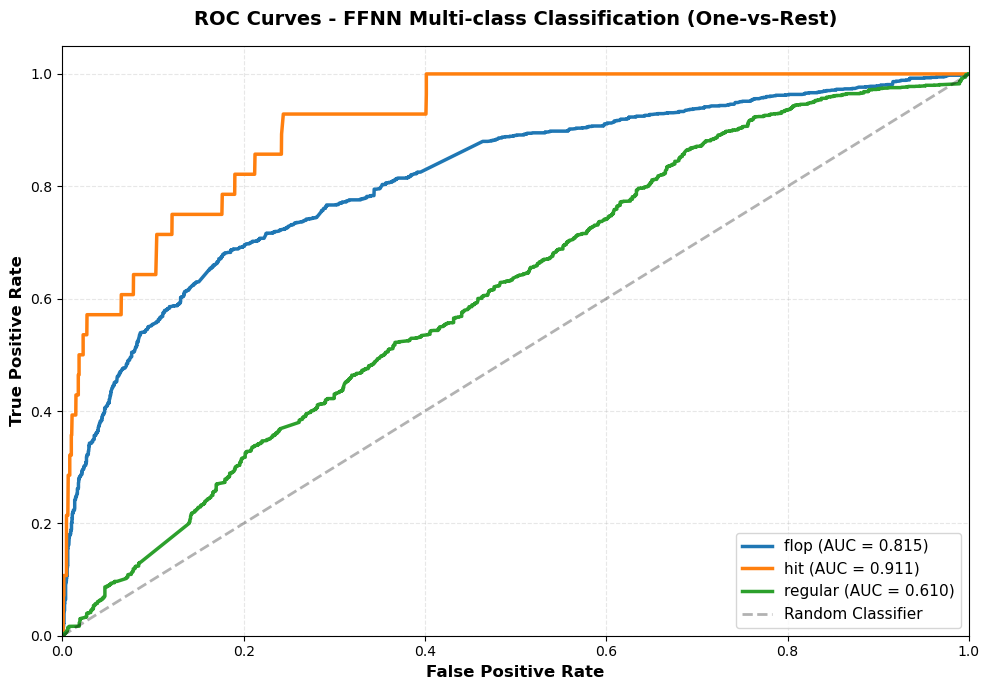

In [130]:
# ROC Curve Visualization

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for ROC curve
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

class_names = label_encoder.classes_

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_ffnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - FFNN Multi-class Classification (One-vs-Rest)', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()



## Final Comparison

PREPARING TEST DATASETS FOR 5 MODEL CONFIGURATIONS

[1/5] Processing Tabular Only...
  ✓ Features: 21
  ✓ Test shape: (4706, 21)

[2/5] Processing Tabular + Text...
  ✓ Features: 789
  ✓ Test shape: (4706, 789)

[3/5] Processing Tabular + Text + Audio...
  ✓ Features: 1813
  ✓ Test shape: (4706, 1813)

[4/5] Processing Tabular + Text + Audio + Lyrics...
  ✓ Features: 2581
  ✓ Test shape: (4706, 2581)

[5/5] Processing All Features...
  ✓ Features: 3093
  ✓ Test shape: (4706, 3093)

✓ ALL TEST DATASETS PREPARED

LOADING MODELS AND EVALUATING PERFORMANCE

Evaluating Model 1: Tabular Only
  Input shape: (4706, 21)
  ✓ Accuracy:    0.6919
  ✓ Overall AUC: 0.8379
  ✓ Hit AUC:     0.9303

Evaluating Model 2: Tabular + Text
  Input shape: (4706, 789)
  ✓ Accuracy:    0.6991
  ✓ Overall AUC: 0.8278
  ✓ Hit AUC:     0.9362

Evaluating Model 3: Tabular + Text + Audio
  Input shape: (4706, 1813)
  ✓ Accuracy:    0.6844
  ✓ Overall AUC: 0.8266
  ✓ Hit AUC:     0.9444

Evaluating Model 4: Tabular +

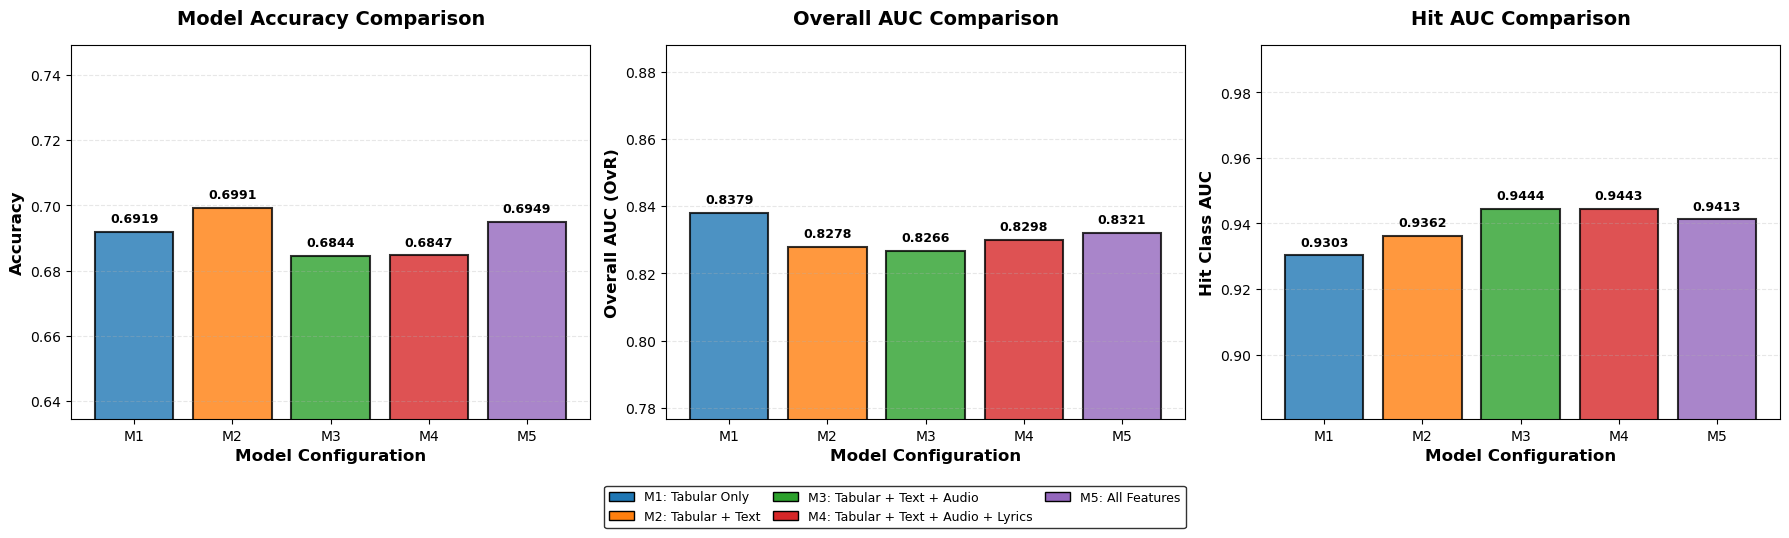


PERFORMANCE COMPARISON SUMMARY
Model                                                  Accuracy    Overall AUC      Hit AUC
------------------------------------------------------------------------------------------
M1: Tabular Only                                         0.6919         0.8379       0.9303
M2: Tabular + Text                                       0.6991         0.8278       0.9362
M3: Tabular + Text + Audio                               0.6844         0.8266       0.9444
M4: Tabular + Text + Audio + Lyrics                      0.6847         0.8298       0.9443
M5: All Features                                         0.6949         0.8321       0.9413

BEST MODELS BY METRIC
  🏆 Accuracy:    M2 (Tabular + Text) - 0.6991
  🏆 Overall AUC: M1 (Tabular Only) - 0.8379
  🏆 Hit AUC:     M3 (Tabular + Text + Audio) - 0.9444


In [ ]:
# For including artist_prev_pop
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PREPARING TEST DATASETS FOR 5 MODEL CONFIGURATIONS")
print("="*70)

# Define columns to exclude
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']

# ============================================================================
# Model 1: Tabular Only
# ============================================================================
print("\n[1/5] Processing Tabular Only...")
train_1 = pd.get_dummies(train_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_1 = pd.get_dummies(test_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_1 = test_1[train_1.columns]

feature_cols_1 = [col for col in train_1.columns if col not in exclude_cols]
X_train_1 = train_1[feature_cols_1]
X_test_1 = test_1[feature_cols_1]

scaler_1 = StandardScaler()
X_train_1_scaled = scaler_1.fit_transform(X_train_1)
X_test_1_scaled = scaler_1.transform(X_test_1)
X_test_1_torch = X_test_1_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_1)}")
print(f"  ✓ Test shape: {X_test_1_torch.shape}")

# ============================================================================
# Model 2: Tabular + Text
# ============================================================================
print("\n[2/5] Processing Tabular + Text...")
train_2 = pd.get_dummies(train_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_2 = pd.get_dummies(test_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_2 = test_2[train_2.columns]

feature_cols_2 = [col for col in train_2.columns if col not in exclude_cols]
X_train_2 = train_2[feature_cols_2]
X_test_2 = test_2[feature_cols_2]

scaler_2 = StandardScaler()
X_train_2_scaled = scaler_2.fit_transform(X_train_2)
X_test_2_scaled = scaler_2.transform(X_test_2)
X_test_2_torch = X_test_2_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_2)}")
print(f"  ✓ Test shape: {X_test_2_torch.shape}")

# ============================================================================
# Model 3: Tabular + Text + Audio
# ============================================================================
print("\n[3/5] Processing Tabular + Text + Audio...")
train_3 = pd.get_dummies(train_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_3 = pd.get_dummies(test_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_3 = test_3[train_3.columns]

feature_cols_3 = [col for col in train_3.columns if col not in exclude_cols]
X_train_3 = train_3[feature_cols_3]
X_test_3 = test_3[feature_cols_3]

scaler_3 = StandardScaler()
X_train_3_scaled = scaler_3.fit_transform(X_train_3)
X_test_3_scaled = scaler_3.transform(X_test_3)
X_test_3_torch = X_test_3_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_3)}")
print(f"  ✓ Test shape: {X_test_3_torch.shape}")

# ============================================================================
# Model 4: Tabular + Text + Audio + Lyrics
# ============================================================================
print("\n[4/5] Processing Tabular + Text + Audio + Lyrics...")
train_4 = pd.get_dummies(train_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_4 = pd.get_dummies(test_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_4 = test_4[train_4.columns]

feature_cols_4 = [col for col in train_4.columns if col not in exclude_cols]
X_train_4 = train_4[feature_cols_4]
X_test_4 = test_4[feature_cols_4]

scaler_4 = StandardScaler()
X_train_4_scaled = scaler_4.fit_transform(X_train_4)
X_test_4_scaled = scaler_4.transform(X_test_4)
X_test_4_torch = X_test_4_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_4)}")
print(f"  ✓ Test shape: {X_test_4_torch.shape}")

# ============================================================================
# Model 5: All Features (Tabular + Text + Audio + Lyrics + Image)
# ============================================================================
print("\n[5/5] Processing All Features...")
train_5 = pd.get_dummies(train_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_5 = pd.get_dummies(test_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_5 = test_5[train_5.columns]

feature_cols_5 = [col for col in train_5.columns if col not in exclude_cols]
X_train_5 = train_5[feature_cols_5]
X_test_5 = test_5[feature_cols_5]

scaler_5 = StandardScaler()
X_train_5_scaled = scaler_5.fit_transform(X_train_5)
X_test_5_scaled = scaler_5.transform(X_test_5)
X_test_5_torch = X_test_5_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_5)}")
print(f"  ✓ Test shape: {X_test_5_torch.shape}")

print("\n" + "="*70)
print("✓ ALL TEST DATASETS PREPARED")
print("="*70)

# ============================================================================
# Load Models and Evaluate
# ============================================================================
print("\n" + "="*70)
print("LOADING MODELS AND EVALUATING PERFORMANCE")
print("="*70)

# Load the 5 grid search models
grid_search_ffnn_1 = joblib.load("models/grid_search_ffnn_1.pkl")
grid_search_ffnn_2 = joblib.load("models/grid_search_ffnn_1_2.pkl")
grid_search_ffnn_3 = joblib.load("models/grid_search_ffnn_1_2_3.pkl")
grid_search_ffnn_4 = joblib.load("models/grid_search_ffnn_1_2_3_4.pkl")
grid_search_ffnn_5 = joblib.load("models/grid_search_ffnn_1_2_3_4_5.pkl")

models = [grid_search_ffnn_1, grid_search_ffnn_2, grid_search_ffnn_3, 
          grid_search_ffnn_4, grid_search_ffnn_5]

test_datasets = [X_test_1_torch, X_test_2_torch, X_test_3_torch, 
                 X_test_4_torch, X_test_5_torch]

model_names = [
    'Tabular Only',
    'Tabular + Text',
    'Tabular + Text + Audio',
    'Tabular + Text + Audio + Lyrics',
    'All Features'
]

# Evaluate each model
accuracies = []
overall_aucs = []
hit_aucs = []

for i, (model, X_test_torch, name) in enumerate(zip(models, test_datasets, model_names)):
    print(f"\n{'='*70}")
    print(f"Evaluating Model {i+1}: {name}")
    print(f"{'='*70}")
    
    # Get best model from grid search
    best_model = model.best_estimator_
    
    print(f"  Input shape: {X_test_torch.shape}")
    
    # Get predictions
    y_test_pred = best_model.predict(X_test_torch)
    y_test_proba = best_model.predict_proba(X_test_torch)
    
    # Convert predictions back to original labels
    y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_test_pred_labels)
    accuracies.append(accuracy)
    
    # Calculate Overall AUC (OvR - One vs Rest)
    overall_auc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr')
    overall_aucs.append(overall_auc)
    
    # Calculate Hit AUC (per-class AUC for 'hit' class)
    y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
    hit_class_idx = list(label_encoder.classes_).index('hit')
    
    fpr_hit, tpr_hit, _ = roc_curve(y_test_binarized[:, hit_class_idx], 
                                      y_test_proba[:, hit_class_idx])
    hit_auc = auc(fpr_hit, tpr_hit)
    hit_aucs.append(hit_auc)
    
    print(f"  ✓ Accuracy:    {accuracy:.4f}")
    print(f"  ✓ Overall AUC: {overall_auc:.4f}")
    print(f"  ✓ Hit AUC:     {hit_auc:.4f}")

# ============================================================================
# Visualization
# ============================================================================
print("\n" + "="*70)
print("CREATING COMPARISON CHARTS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
x_pos = range(len(model_names))

# Plot 1: Accuracy
axes[0].bar(x_pos, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[0].set_ylim([min(accuracies) - 0.05, min(1.0, max(accuracies) + 0.05)])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Overall AUC
axes[1].bar(x_pos, overall_aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Overall AUC (OvR)', fontsize=12, fontweight='bold')
axes[1].set_title('Overall AUC Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[1].set_ylim([min(overall_aucs) - 0.05, min(1.0, max(overall_aucs) + 0.05)])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(overall_aucs):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Hit AUC
axes[2].bar(x_pos, hit_aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Hit Class AUC', fontsize=12, fontweight='bold')
axes[2].set_title('Hit AUC Comparison', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[2].set_ylim([min(hit_aucs) - 0.05, min(1.0, max(hit_aucs) + 0.05)])
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(hit_aucs):
    axes[2].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add legend with proper colors - TIGHTER SPACING
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'M{i+1}: {name}') 
                   for i, name in enumerate(model_names)]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), 
           ncol=3, frameon=True, fontsize=9, edgecolor='black',
           columnspacing=1.0)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Reduced from 0.25
plt.show()

# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "="*90)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*90)
print(f"{'Model':<50} {'Accuracy':>12} {'Overall AUC':>14} {'Hit AUC':>12}")
print("-"*90)
for i, name in enumerate(model_names):
    print(f"{f'M{i+1}: {name}':<50} {accuracies[i]:>12.4f} {overall_aucs[i]:>14.4f} {hit_aucs[i]:>12.4f}")
print("="*90)

# Best models
best_acc_idx = np.argmax(accuracies)
best_overall_auc_idx = np.argmax(overall_aucs)
best_hit_auc_idx = np.argmax(hit_aucs)

print(f"\n{'='*90}")
print("BEST MODELS BY METRIC")
print(f"{'='*90}")
print(f"  🏆 Accuracy:    M{best_acc_idx+1} ({model_names[best_acc_idx]}) - {accuracies[best_acc_idx]:.4f}")
print(f"  🏆 Overall AUC: M{best_overall_auc_idx+1} ({model_names[best_overall_auc_idx]}) - {overall_aucs[best_overall_auc_idx]:.4f}")
print(f"  🏆 Hit AUC:     M{best_hit_auc_idx+1} ({model_names[best_hit_auc_idx]}) - {hit_aucs[best_hit_auc_idx]:.4f}")
print(f"{'='*90}")

PREPARING TEST DATASETS FOR 5 MODEL CONFIGURATIONS (NO ARTIST_PREV_POP)

[1/5] Processing Tabular Only...
  ✓ Features: 20
  ✓ Test shape: (4706, 20)

[2/5] Processing Tabular + Text...
  ✓ Features: 788
  ✓ Test shape: (4706, 788)

[3/5] Processing Tabular + Text + Audio...
  ✓ Features: 1812
  ✓ Test shape: (4706, 1812)

[4/5] Processing Tabular + Text + Audio + Lyrics...
  ✓ Features: 2580
  ✓ Test shape: (4706, 2580)

[5/5] Processing All Features...
  ✓ Features: 3092
  ✓ Test shape: (4706, 3092)

✓ ALL TEST DATASETS PREPARED

LOADING NEW MODELS (NO ARTIST_PREV_POP) AND EVALUATING PERFORMANCE

Evaluating Model 1: Tabular Only
  Input shape: (4706, 20)
  ✓ Accuracy:    0.4573
  ✓ Overall AUC: 0.6537
  ✓ Hit AUC:     0.8216

Evaluating Model 2: Tabular + Text
  Input shape: (4706, 788)
  ✓ Accuracy:    0.4696
  ✓ Overall AUC: 0.6972
  ✓ Hit AUC:     0.8573

Evaluating Model 3: Tabular + Text + Audio
  Input shape: (4706, 1812)
  ✓ Accuracy:    0.5140
  ✓ Overall AUC: 0.7134
  ✓ Hit 

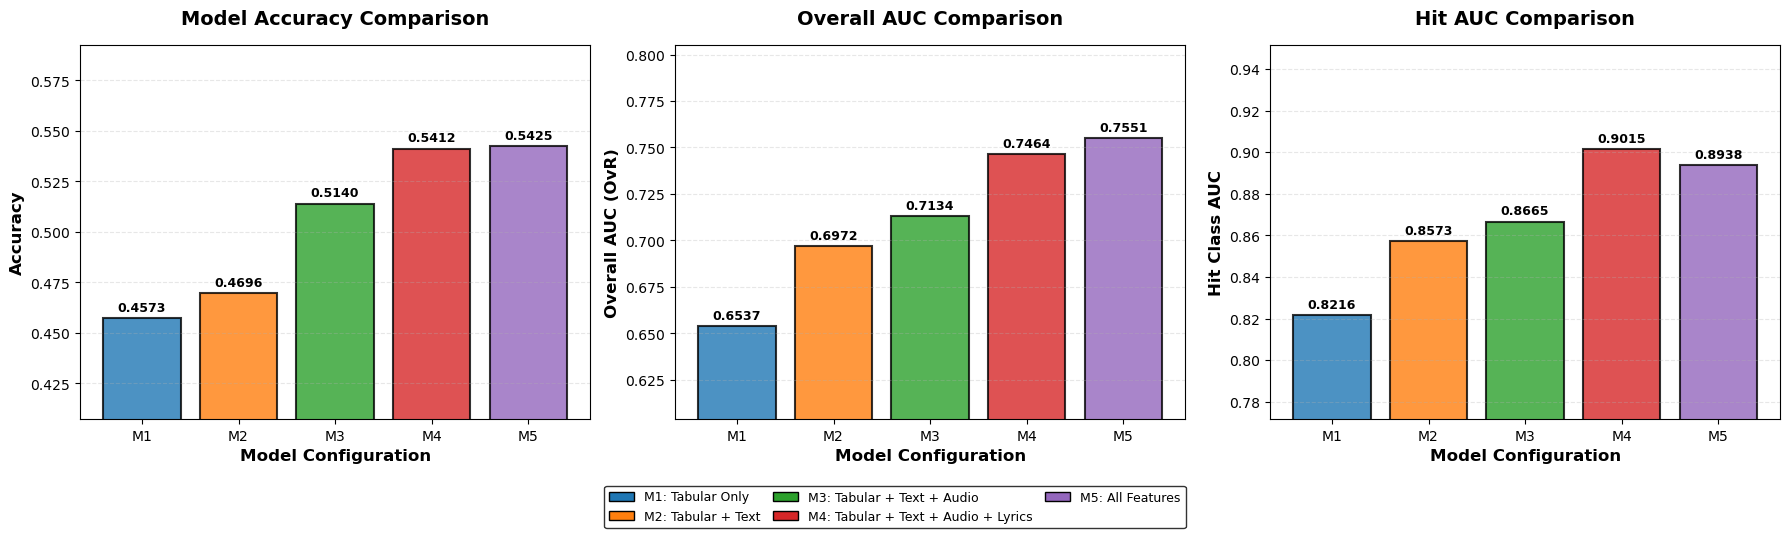


PERFORMANCE COMPARISON SUMMARY (NO ARTIST_PREV_POP)
Model                                                  Accuracy    Overall AUC      Hit AUC
------------------------------------------------------------------------------------------
M1: Tabular Only                                         0.4573         0.6537       0.8216
M2: Tabular + Text                                       0.4696         0.6972       0.8573
M3: Tabular + Text + Audio                               0.5140         0.7134       0.8665
M4: Tabular + Text + Audio + Lyrics                      0.5412         0.7464       0.9015
M5: All Features                                         0.5425         0.7551       0.8938

BEST MODELS BY METRIC
  🏆 Accuracy:    M5 (All Features) - 0.5425
  🏆 Overall AUC: M5 (All Features) - 0.7551
  🏆 Hit AUC:     M4 (Tabular + Text + Audio + Lyrics) - 0.9015


In [222]:
# For excluding artist_prev_pop
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PREPARING TEST DATASETS FOR 5 MODEL CONFIGURATIONS (NO ARTIST_PREV_POP)")
print("="*70)

# Define columns to exclude
exclude_cols = ['track_id', 'artist_name', 'track_name', 'pop']

# ============================================================================
# Model 1: Tabular Only
# ============================================================================
print("\n[1/5] Processing Tabular Only...")
train_1 = pd.get_dummies(train_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_1 = pd.get_dummies(test_tabular, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_1 = test_1[train_1.columns]

feature_cols_1 = [col for col in train_1.columns if col not in exclude_cols]
X_train_1 = train_1[feature_cols_1]
X_test_1 = test_1[feature_cols_1]

scaler_1 = StandardScaler()
X_train_1_scaled = scaler_1.fit_transform(X_train_1)
X_test_1_scaled = scaler_1.transform(X_test_1)
X_test_1_torch = X_test_1_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_1)}")
print(f"  ✓ Test shape: {X_test_1_torch.shape}")

# ============================================================================
# Model 2: Tabular + Text
# ============================================================================
print("\n[2/5] Processing Tabular + Text...")
train_2 = pd.get_dummies(train_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_2 = pd.get_dummies(test_tab_text, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_2 = test_2[train_2.columns]

feature_cols_2 = [col for col in train_2.columns if col not in exclude_cols]
X_train_2 = train_2[feature_cols_2]
X_test_2 = test_2[feature_cols_2]

scaler_2 = StandardScaler()
X_train_2_scaled = scaler_2.fit_transform(X_train_2)
X_test_2_scaled = scaler_2.transform(X_test_2)
X_test_2_torch = X_test_2_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_2)}")
print(f"  ✓ Test shape: {X_test_2_torch.shape}")

# ============================================================================
# Model 3: Tabular + Text + Audio
# ============================================================================
print("\n[3/5] Processing Tabular + Text + Audio...")
train_3 = pd.get_dummies(train_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_3 = pd.get_dummies(test_tab_text_audio, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_3 = test_3[train_3.columns]

feature_cols_3 = [col for col in train_3.columns if col not in exclude_cols]
X_train_3 = train_3[feature_cols_3]
X_test_3 = test_3[feature_cols_3]

scaler_3 = StandardScaler()
X_train_3_scaled = scaler_3.fit_transform(X_train_3)
X_test_3_scaled = scaler_3.transform(X_test_3)
X_test_3_torch = X_test_3_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_3)}")
print(f"  ✓ Test shape: {X_test_3_torch.shape}")

# ============================================================================
# Model 4: Tabular + Text + Audio + Lyrics
# ============================================================================
print("\n[4/5] Processing Tabular + Text + Audio + Lyrics...")
train_4 = pd.get_dummies(train_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_4 = pd.get_dummies(test_tab_text_audio_lyrics, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_4 = test_4[train_4.columns]

feature_cols_4 = [col for col in train_4.columns if col not in exclude_cols]
X_train_4 = train_4[feature_cols_4]
X_test_4 = test_4[feature_cols_4]

scaler_4 = StandardScaler()
X_train_4_scaled = scaler_4.fit_transform(X_train_4)
X_test_4_scaled = scaler_4.transform(X_test_4)
X_test_4_torch = X_test_4_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_4)}")
print(f"  ✓ Test shape: {X_test_4_torch.shape}")

# ============================================================================
# Model 5: All Features (Tabular + Text + Audio + Lyrics + Image)
# ============================================================================
print("\n[5/5] Processing All Features...")
train_5 = pd.get_dummies(train_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_5 = pd.get_dummies(test_tab_text_audio_lyrics_image, columns=['artist_tier'], prefix='artist_tier', drop_first=False)
test_5 = test_5[train_5.columns]

feature_cols_5 = [col for col in train_5.columns if col not in exclude_cols]
X_train_5 = train_5[feature_cols_5]
X_test_5 = test_5[feature_cols_5]

scaler_5 = StandardScaler()
X_train_5_scaled = scaler_5.fit_transform(X_train_5)
X_test_5_scaled = scaler_5.transform(X_test_5)
X_test_5_torch = X_test_5_scaled.astype(np.float32)

print(f"  ✓ Features: {len(feature_cols_5)}")
print(f"  ✓ Test shape: {X_test_5_torch.shape}")

print("\n" + "="*70)
print("✓ ALL TEST DATASETS PREPARED")
print("="*70)

# ============================================================================
# Load NEW Models and Evaluate
# ============================================================================
print("\n" + "="*70)
print("LOADING NEW MODELS (NO ARTIST_PREV_POP) AND EVALUATING PERFORMANCE")
print("="*70)

# Load the 5 NEW grid search models
grid_search_ffnn_1_new = joblib.load("models/grid_search_ffnn_1_new.pkl")
grid_search_ffnn_2_new = joblib.load("models/grid_search_ffnn_1_2_new.pkl")
grid_search_ffnn_3_new = joblib.load("models/grid_search_ffnn_1_2_3_new.pkl")
grid_search_ffnn_4_new = joblib.load("models/grid_search_ffnn_1_2_3_4_new.pkl")
grid_search_ffnn_5_new = joblib.load("models/grid_search_ffnn_1_2_3_4_5_new.pkl")

models = [grid_search_ffnn_1_new, grid_search_ffnn_2_new, grid_search_ffnn_3_new, 
          grid_search_ffnn_4_new, grid_search_ffnn_5_new]

test_datasets = [X_test_1_torch, X_test_2_torch, X_test_3_torch, 
                 X_test_4_torch, X_test_5_torch]

model_names = [
    'Tabular Only',
    'Tabular + Text',
    'Tabular + Text + Audio',
    'Tabular + Text + Audio + Lyrics',
    'All Features'
]

# Evaluate each model
accuracies = []
overall_aucs = []
hit_aucs = []

for i, (model, X_test_torch, name) in enumerate(zip(models, test_datasets, model_names)):
    print(f"\n{'='*70}")
    print(f"Evaluating Model {i+1}: {name}")
    print(f"{'='*70}")
    
    # Get best model from grid search
    best_model = model.best_estimator_
    
    print(f"  Input shape: {X_test_torch.shape}")
    
    # Get predictions
    y_test_pred = best_model.predict(X_test_torch)
    y_test_proba = best_model.predict_proba(X_test_torch)
    
    # Convert predictions back to original labels
    y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_test_pred_labels)
    accuracies.append(accuracy)
    
    # Calculate Overall AUC (OvR - One vs Rest)
    overall_auc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr')
    overall_aucs.append(overall_auc)
    
    # Calculate Hit AUC (per-class AUC for 'hit' class)
    y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])
    hit_class_idx = list(label_encoder.classes_).index('hit')
    
    fpr_hit, tpr_hit, _ = roc_curve(y_test_binarized[:, hit_class_idx], 
                                      y_test_proba[:, hit_class_idx])
    hit_auc = auc(fpr_hit, tpr_hit)
    hit_aucs.append(hit_auc)
    
    print(f"  ✓ Accuracy:    {accuracy:.4f}")
    print(f"  ✓ Overall AUC: {overall_auc:.4f}")
    print(f"  ✓ Hit AUC:     {hit_auc:.4f}")

# ============================================================================
# Visualization
# ============================================================================
print("\n" + "="*70)
print("CREATING COMPARISON CHARTS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
x_pos = range(len(model_names))

# Plot 1: Accuracy
axes[0].bar(x_pos, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[0].set_ylim([min(accuracies) - 0.05, min(1.0, max(accuracies) + 0.05)])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Overall AUC
axes[1].bar(x_pos, overall_aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Overall AUC (OvR)', fontsize=12, fontweight='bold')
axes[1].set_title('Overall AUC Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[1].set_ylim([min(overall_aucs) - 0.05, min(1.0, max(overall_aucs) + 0.05)])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(overall_aucs):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Hit AUC
axes[2].bar(x_pos, hit_aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Hit Class AUC', fontsize=12, fontweight='bold')
axes[2].set_title('Hit AUC Comparison', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'M{i+1}' for i in range(len(model_names))], fontsize=10)
axes[2].set_ylim([min(hit_aucs) - 0.05, min(1.0, max(hit_aucs) + 0.05)])
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(hit_aucs):
    axes[2].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add legend with proper colors - TIGHTER SPACING
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=f'M{i+1}: {name}') 
                   for i, name in enumerate(model_names)]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), 
           ncol=3, frameon=True, fontsize=9, edgecolor='black',
           columnspacing=1.0)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "="*90)
print("PERFORMANCE COMPARISON SUMMARY (NO ARTIST_PREV_POP)")
print("="*90)
print(f"{'Model':<50} {'Accuracy':>12} {'Overall AUC':>14} {'Hit AUC':>12}")
print("-"*90)
for i, name in enumerate(model_names):
    print(f"{f'M{i+1}: {name}':<50} {accuracies[i]:>12.4f} {overall_aucs[i]:>14.4f} {hit_aucs[i]:>12.4f}")
print("="*90)

# Best models
best_acc_idx = np.argmax(accuracies)
best_overall_auc_idx = np.argmax(overall_aucs)
best_hit_auc_idx = np.argmax(hit_aucs)

print(f"\n{'='*90}")
print("BEST MODELS BY METRIC")
print(f"{'='*90}")
print(f"  🏆 Accuracy:    M{best_acc_idx+1} ({model_names[best_acc_idx]}) - {accuracies[best_acc_idx]:.4f}")
print(f"  🏆 Overall AUC: M{best_overall_auc_idx+1} ({model_names[best_overall_auc_idx]}) - {overall_aucs[best_overall_auc_idx]:.4f}")
print(f"  🏆 Hit AUC:     M{best_hit_auc_idx+1} ({model_names[best_hit_auc_idx]}) - {hit_aucs[best_hit_auc_idx]:.4f}")
print(f"{'='*90}")